In [712]:
!pip install optuna

In [713]:
import optuna
import warnings
import os, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
warnings.filterwarnings('ignore')

In [714]:
# Set Seed - 일정한 성능의 유지 목적

def seed_everything(seed: int=42):
  random.seed(seed)
  np.random.seed(seed)
  os.environ['PYTHONASHSEED'] = str(seed)
my_seed = 42
seed_everything(my_seed)

In [715]:
train = pd.read_csv('/content/drive/MyDrive/nextorial/match_data.csv')
test = pd.read_csv('/content/drive/MyDrive/nextorial/test_data.csv')
print(train.shape)
train.head()

(410384, 16)


,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,tier,itemid,matchresult,matchscore,isDrop,isEscape
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,1812,G69102,1,0,0.428571,7,gold,1364,0,25,1,0
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,1868,NaN,1,0,0.333333,9,gold,1178,0,35,0,0
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,1809,G5900,0,2,0.200000,162,platinum,1385,0,39,0,0
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,1631,G424,2,0,0.300000,11,bronze,1338,0,0,1,0
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,1973,NaN,0,3,0.500000,412,platinum,1277,1,41,0,0


# Feature List(메모용)

1. 매치 정보
* createdatekst - 데이터 기록 시각
* matchid - 게임 식별자
* accountid - 유저 식별자
* teamid - 팀 번호(1또는2)

2. 매치 입장 시 상태
* mmr - 실력점수(0~3200 범위)
* guildid - 가입 길드 식별자. 미가입 유저는 빈칸
* winstreak - 연승 기록 수
* losestreak - 연패 기록 수
* recentwinprob - 최근 10개 게임의 승률
* accumatches - 누적 게임 수
* tier - 티어 정보(unranked, bronze, silver, gold, paltinum, diamond, master)
* itemid - 장착 아이템 식별자

3. 매치 결과
* matchresult - 게임 결과(1: 승리, 2: 패배)
* matchscore - 게임 점수(0~100 사이 범위)
* isDrop - 게임 기권 여부(1: 기권, 0: 기권 안함)
* isEscape - 게임 탈주 여부(1:탈주, 0:탈주 안함)

# 1. EDA 및 전처리
* 1) guildid 결측치 처리
* 2) 수치형 변수 상관관계 확인
* 3) recentwinprob 관련 EDA & 파생변수 생성
* 4) winstreak & losestreak 관련 EDA & 파생변수 생성
* 5) mmr 관련 EDA & 파생변수 생성
* 6) accountid별 평균 특성을 고려한 파생변수 생성
* 7) guildid별 평균 특성을 고려한 파생변수 생성
* 8) tier를 고려한 mmr 만들기
* 9) matchid & teamid별 평균 특성을 고려한 파생변수 생성
* 10) 왜도 확인 및 수치형 변수 로그 변환

## 1) guildid 결측치 처리
* guildid의 결측치는 길드 가입 안한 유저
* 해당 유저는 'None'으로 결측치 대체

In [716]:
# guildid 결측값을 None으로 대체
train['guildid'] = train['guildid'].fillna('None')
test['guildid'] = test['guildid'].fillna('None')

## 2) 수치형 변수 상관관계 확인
* 수치형 변수와 정답 레이블 간 상관관계 확인 및 시각화를 통한 기초 분석 수행

<히트맵 분석 결과>
* 게임 중 기권 & 탈주할수록 패배 확률이 높음
* 게임 점수가 높을 수록 승리 확률이 높음
* 상관관계 크기 : mmr > recentwinprob > losestreak > winstreak > accumatches
* mmr, accumatches, recentwinprob, matchscore는 높은 상관관계를 보임
* isEscape가 높은 사람들의 mmr은 낮은 편

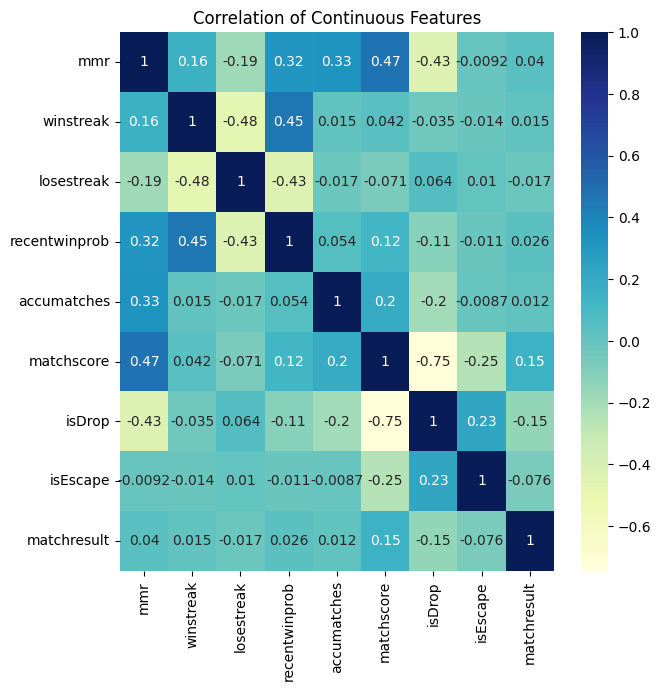

In [717]:
# 수치형 변수와 레이블 간 상관관계 히트맵
col_list = ['mmr', 'winstreak', 'losestreak', 'recentwinprob', 'accumatches', 'matchscore', 'isDrop', 'isEscape', 'matchresult']

plt.figure(figsize=(7,7))
plt.title('Correlation of Continuous Features')
sns.heatmap(train[col_list].corr(), annot=True, cmap="YlGnBu")
plt.show()

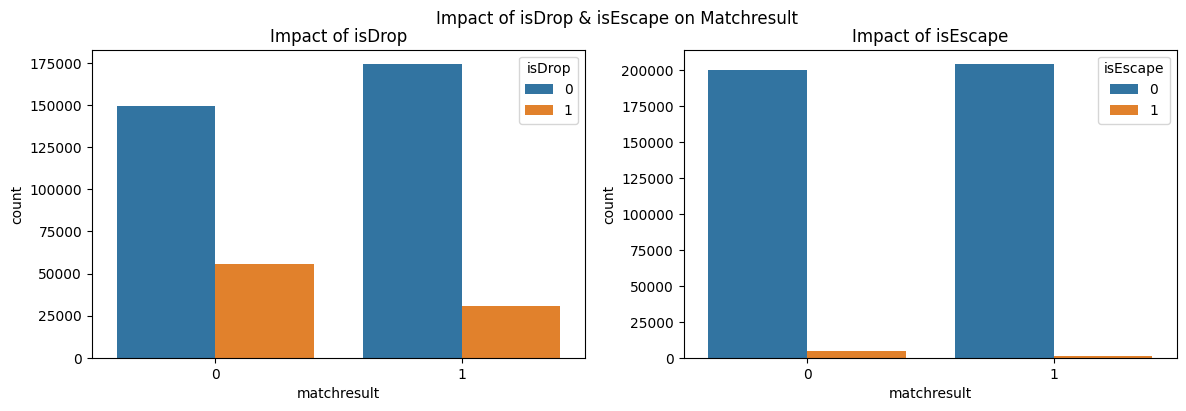

In [718]:
# isDrop이거나 isEscape한 사람들은 패배 확률이 높음

plt.figure(figsize=(14,4))
plt.suptitle('Impact of isDrop & isEscape on Matchresult')
plt.subplot(1,2,1)
sns.countplot(x=train['matchresult'], hue=train['isDrop'])
plt.title('Impact of isDrop')
plt.subplot(1,2,2)
sns.countplot(x=train['matchresult'], hue=train['isEscape'])
plt.title('Impact of isEscape')
plt.show()

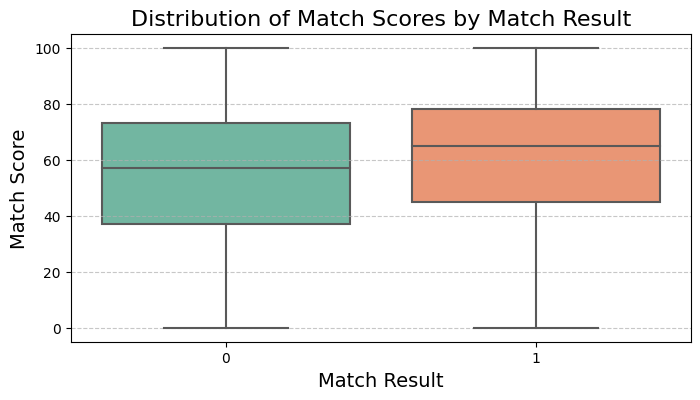

In [719]:
# matchscore 상관관계 분석 - matchscore가 높을수록 승리 확률 높음
color_palette = sns.color_palette("Set2")

plt.figure(figsize=(8, 4))
sns.boxplot(x='matchresult', y='matchscore', data=train, palette=color_palette)
plt.title('Distribution of Match Scores by Match Result', fontsize=16)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xlabel('Match Result', fontsize=14)
plt.ylabel('Match Score', fontsize=14)
plt.show()

<Axes: title={'center': 'Impact of tier on MatchResult'}, xlabel='matchresult', ylabel='count'>

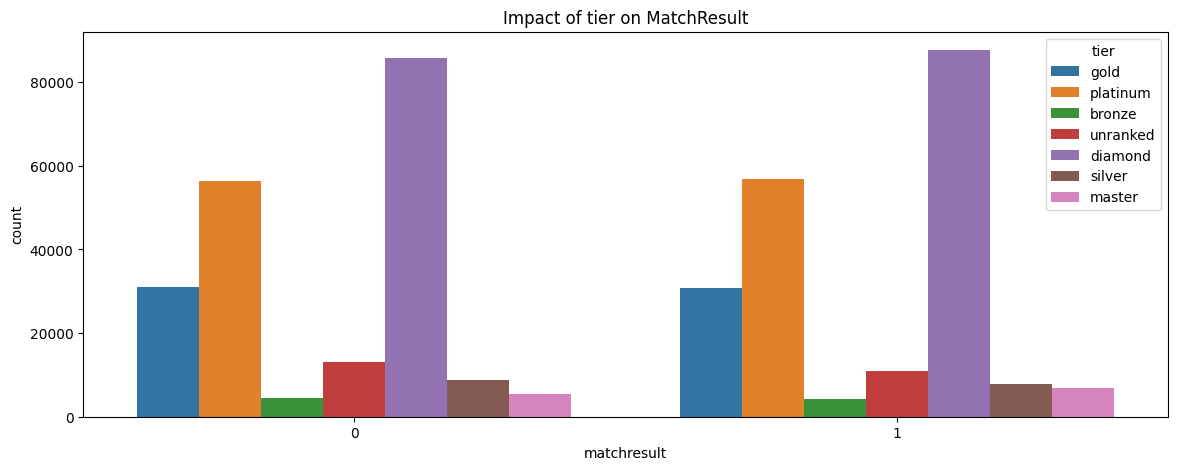

In [720]:
# tier별 승패 차이 --> 특별한 차이를 보이지 않음
plt.figure(figsize=(14,5))
plt.title('Impact of tier on MatchResult')
sns.countplot(x=train['matchresult'], hue=train['tier'])

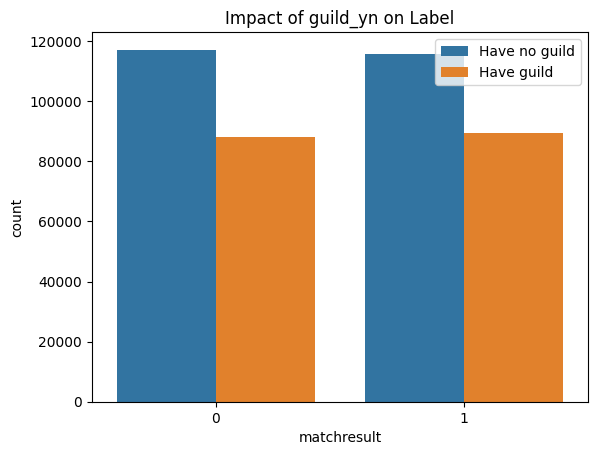

In [721]:
# 길드 가입 여부에 따른 승패 비교 --> 큰 영향을 미치지 않는 요인
def guild_yn(data):

  if data == 'None':
    x = 0
  else:
    x = 1

  return x

train['guild_yn'] = train['guildid'].apply(lambda x: guild_yn(x))
plt.title('Impact of guild_yn on Label')
sns.countplot(x=train['matchresult'], hue=train['guild_yn'])
plt.legend(['Have no guild', 'Have guild'])
plt.show()

## 3) recentwinprob 관련 EDA & 파생변수 생성
* recentwinprob가 승패 여부에 미치는 영향을 확인하고, 파생변수를 생성함

<recentwinprob 분석 결과>
* 최근 10경기 승리확률이 높을수록 승률이 미세하게 높아짐
* 특히, 0.3 이전에는 승률이 낮았으며, 0.8 ~ 0.9 사이는 승률이 크게 높았음
* 자세한 분석 결과 최근 10경기 승리확률이 0.35 이하인 경우, 승패에 영향을 어느정도 미치는 것으로 드러남

<파생변수 생성>
* 위 분석 결과를 통해 최근 10경기 승률 0.35 이하 여부를 구분하는 범주형 변수 'recentwinprob_35' 생성

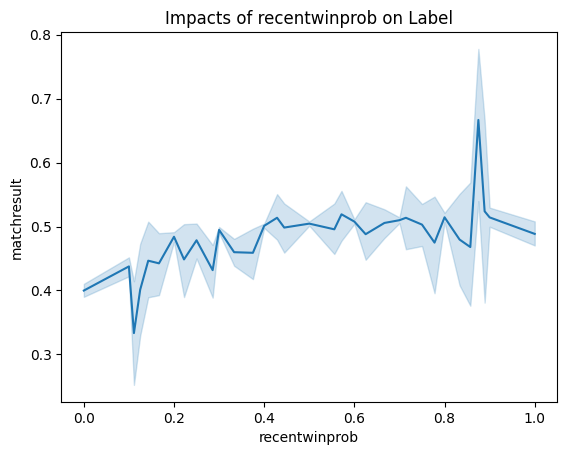

In [722]:
# recentwinprob이 승패 여부에 미치는 영향 확인
# recentwinprob이 높을수록 승률이 미세하게 높아짐
# 특히, 0.8 이후부터는 높은 승률을 보였으며 0.3 이전에는 낮은 승률을 보임
plt.title('Impacts of recentwinprob on Label')
sns.lineplot(x=train['recentwinprob'], y=train['matchresult'])
plt.show()

(79579, 17)
0    41684
1    37895
Name: matchresult, dtype: int64
(330805, 17)
1    167297
0    163508
Name: matchresult, dtype: int64


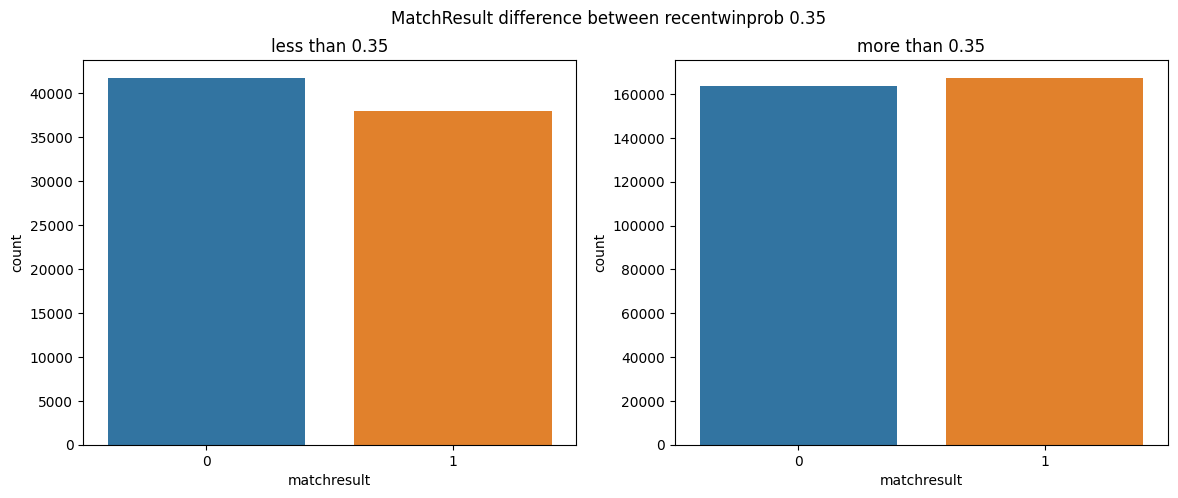

In [723]:
# recentwinprob을 0.35 전후로 나눈 결과, 최근 10경기 승률이 0.35 이하인 유저의 패배 확률이 높았음

prob_less_35 = train[(train['recentwinprob'] < 0.35)]
print(prob_less_35.shape)
print(prob_less_35['matchresult'].value_counts())

prob_more_35 = train[train['recentwinprob'] >= 0.35]
print(prob_more_35.shape)
print(prob_more_35['matchresult'].value_counts())

plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
sns.countplot(x=prob_less_35['matchresult'])
plt.title('less than 0.35')
plt.subplot(1,2,2)
sns.countplot(x=prob_more_35['matchresult'])
plt.title('more than 0.35')
plt.suptitle('MatchResult difference between recentwinprob 0.35')
plt.show()

In [724]:
# recentwinprob <= 0.35 인 경우 페널티를 주는 파생 변수(recentwinprob_35) 생성

def prob_class(data):

  if data >= 0.35:
    result = 1
  else: result = 0

  return result

train['recentwinprob_35'] = train['recentwinprob'].apply(lambda x: prob_class(x))
test['recentwinprob_35'] = test['recentwinprob'].apply(lambda x: prob_class(x))

## 4) winstreak & losestreak 관련 EDA & 파생변수 생성
* 연승/연패가 승패 여부에 미치는 영향을 확인하고, 파생변수를 생성함

<winstreak & losestreak 분석 결과>
* 데이터 시각화 및 추가 확인 결과, 연패 1~10인 경우 패배 확률이 크게 높아짐
* 연승이 승패 여부에 미치는 영향은 뚜렷하게 나타나지 않음

<파생변수 생성>
* 위 분석 결과를 통해 연패가 1~10 사이 내 존재 여부를 구분하는 범주형 변수 'losestreak_cat'생성

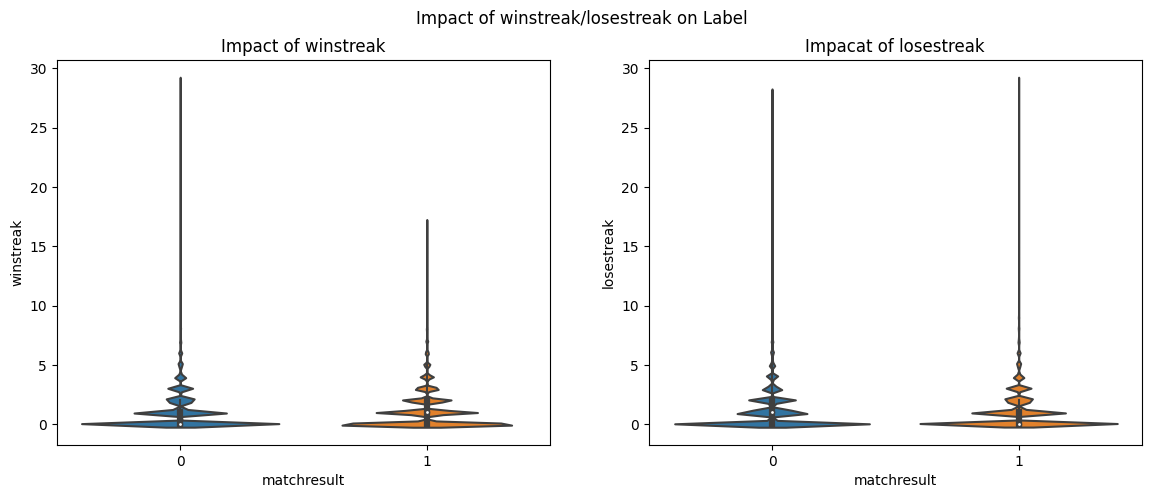

In [725]:
# 연승 및 연패와의 상관관계 분석
# 대부분의 연승&연패 데이터가 0~5 사이 분포하므로 구분해서 확인할 필요가 있을 듯
# 해당 그림만 봤을 때는 뚜렷한 차이를 보인다고 하기 어려움
plt.figure(figsize=(14,5))
plt.suptitle('Impact of winstreak/losestreak on Label')
plt.subplot(1,2,1)
sns.violinplot(x=train['matchresult'], y=train['winstreak'])
plt.title('Impact of winstreak')

plt.subplot(1,2,2)
sns.violinplot(x=train['matchresult'], y=train['losestreak'])
plt.title('Impacat of losestreak')
plt.show()

In [726]:
# 데이터 확인 결과, 연패가 1~10인 경우 패배할 확률이 크게 높음
# 연패 범위 1~10이면 0을, 아니면 1을 적용하는 변수 생성

def lose_10_more(data):

  if 1<= data <= 10:
    result = 0
  else:
    result = 1

  return result

train['losestreak_cat'] = train['losestreak'].apply(lambda x: lose_10_more(x))
test['losestreak_cat'] = test['losestreak'].apply(lambda x: lose_10_more(x))

## 5) mmr 관련 EDA & 파생변수 생성
* mmr이 승패 여부에 미치는 영향을 확인하고, 파생변수를 생성함

<mmr 분석 결과>
* mmr은 accumatches, recentwinprob과 높은 상관관계를 보였음
* mmr은 단순히 tier로 결정되는 변수가 아님을 확인
* mmr 상위 25% 이상인 유저의 누적 매치수는 상대적으로 많았고, 승률 또한 미세하게 높았음
* mmr 하위 25% 이하인 유저의 승리 확률은 미세하게 낮았음

<파생변수 생성>
* mmr 상위 25% 및 하위 25% 유저를 구분하는 범주형 변수 'mmr_cat' 생성

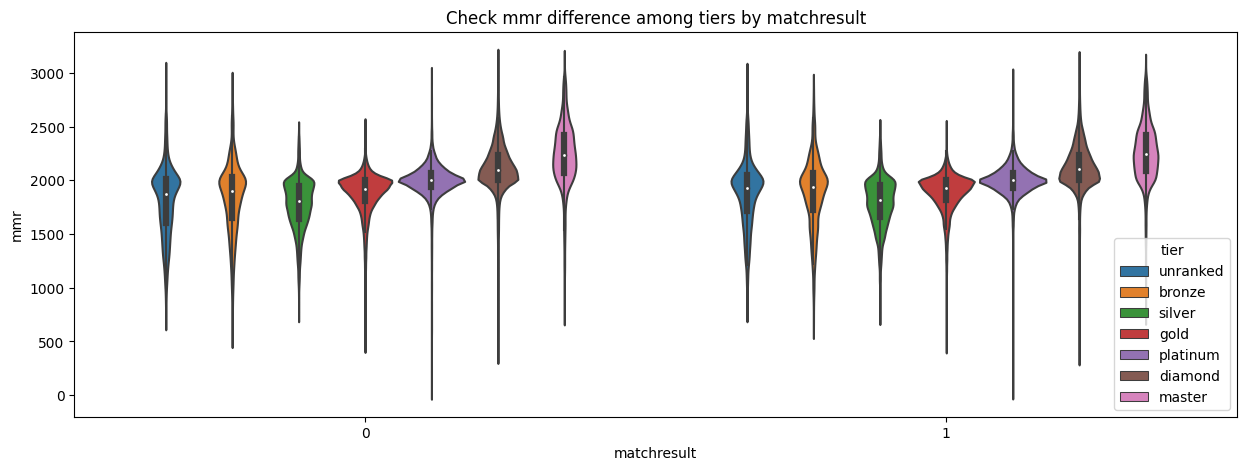

In [727]:
# mmr는 tier에 따라 나뉘는게 아닐까? & tier에 따른 승패 여부도 확인할 수 있지 않을까?
# mmr에 따라 tier가 꼭 확정지어지는 게 아닌 듯
# 승패 여부는 비슷했음

plt.figure(figsize=(15,5))
plt.title('Check mmr difference among tiers by matchresult')
sns.violinplot(x=train['matchresult'], y=train['mmr'], hue=train['tier'],
               hue_order=['unranked', 'bronze', 'silver', 'gold', 'platinum', 'diamond', 'master'])
plt.show()

In [728]:
# 그렇다면 mmr은 무엇에 따라 결정 되는가?
# 앞선 히트맵에서 recentwinprob, accumatches, matchscore 와 mmr 간의 상관관계가 높았음
# 특히, accumatches와 recentwinprob 은 mmr 변화에 큰 영향을 주는 듯

train['mmr'].describe()

count    410384.000000
mean       2017.942880
std         246.652163
min           0.000000
25%        1922.000000
50%        2013.000000
75%        2133.000000
max        3173.000000
Name: mmr, dtype: float64

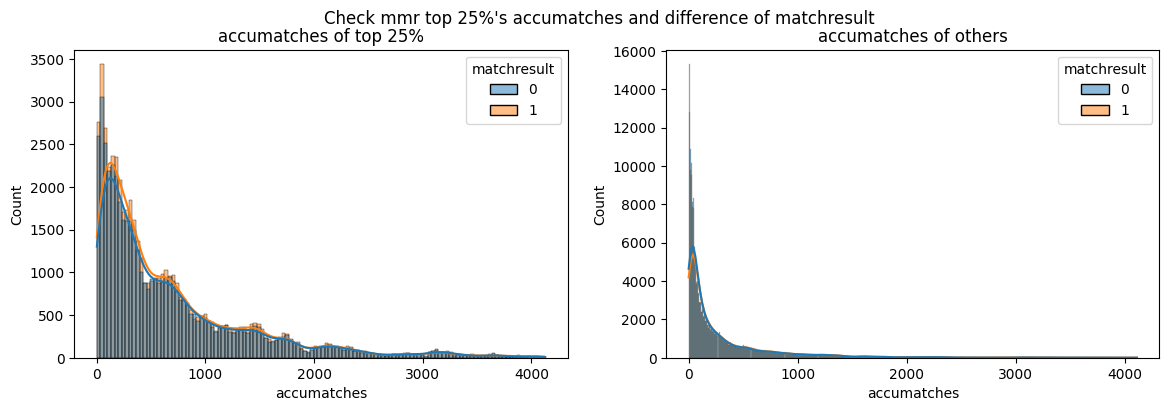

In [729]:
# mmr이 상위25%(2133)인 사람들의 승률과 누적매치수, 승패 연관성 확인
# 전반적으로 mmr이 상위 25% 이상인 사람들의 누적 매치 수가 높고, 승률 또한 근소하게 높은 것 확인 가능

mmr_25 = train[train['mmr'] >= 2133]
others = train[train['mmr'] < 2133]

plt.figure(figsize=(14,4))
plt.suptitle("Check mmr top 25%'s accumatches and difference of matchresult")
plt.subplot(1,2,1)
sns.histplot(x=mmr_25['accumatches'], hue=train['matchresult'], kde=True)
plt.title('accumatches of top 25%')
plt.subplot(1,2,2)
sns.histplot(x=others['accumatches'], hue=others['matchresult'], kde=True)
plt.title('accumatches of others')
plt.show()

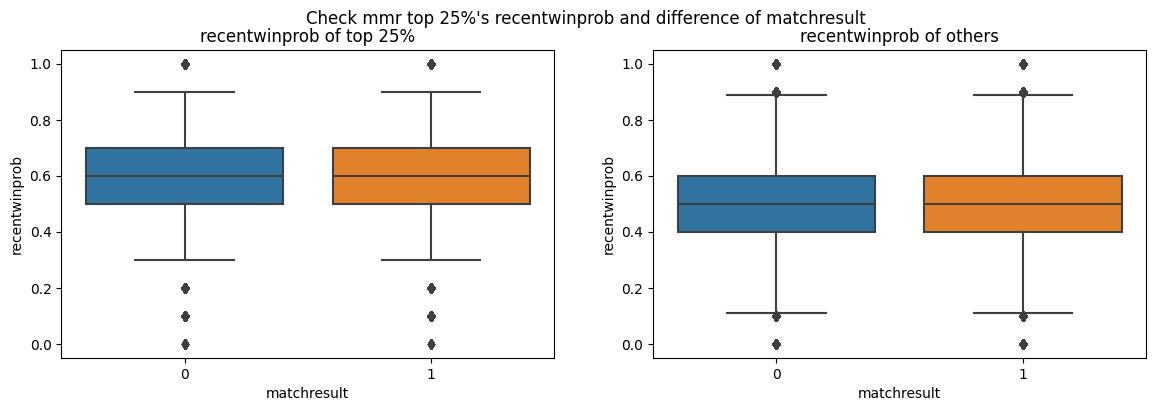

In [730]:
# 전반적으로 mmr이 상위 25% 이상인 사람들의 recentwinprob은 높지만, 승패에 큰 영향을 끼쳤는지는 판별하기 어려움

plt.figure(figsize=(14,4))
plt.suptitle("Check mmr top 25%'s recentwinprob and difference of matchresult")
plt.subplot(1,2,1)
plt.title('recentwinprob of top 25%')
sns.boxplot(x=mmr_25['matchresult'], y=mmr_25['recentwinprob'])
plt.subplot(1,2,2)
plt.title('recentwinprob of others')
sns.boxplot(x=others['matchresult'], y=others['recentwinprob'])
plt.show()

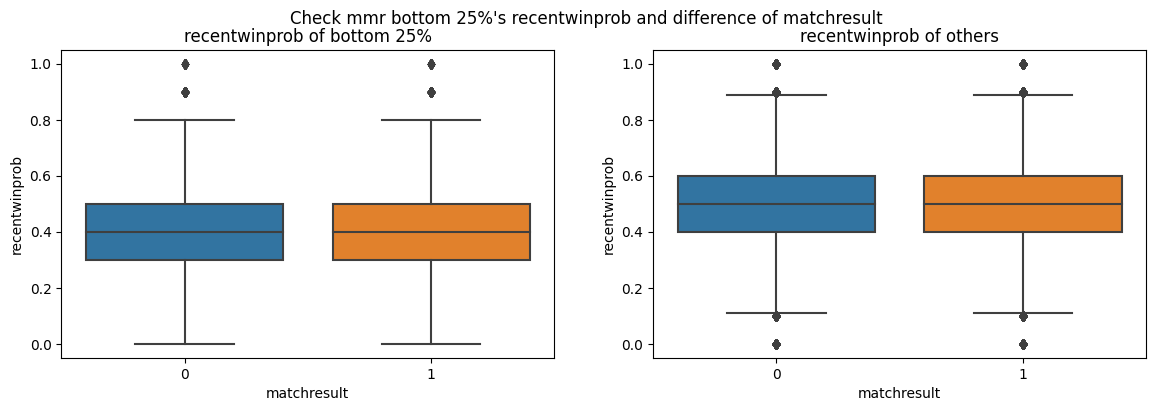

In [731]:
# mmr이 하위 25%인 사용자는 승리 확률이 낮은가?
# mmr이 낮은 유저는 승리 확률이 미세하게 낮다는 것을 확인 가능
mmr_75 = train[train['mmr'] <= 1922]
others = train[train['mmr'] > 1922]

plt.figure(figsize=(14,4))
plt.suptitle("Check mmr bottom 25%'s recentwinprob and difference of matchresult")
plt.subplot(1,2,1)
plt.title('recentwinprob of bottom 25%')
sns.boxplot(x=mmr_75['matchresult'], y=mmr_75['recentwinprob'])
plt.subplot(1,2,2)
plt.title('recentwinprob of others')
sns.boxplot(x=others['matchresult'], y=others['recentwinprob'])
plt.show()

In [732]:
# 확인 결과, mmr은 accumatches와 recentwinprob에 영향을 주는 변수이며 승패에도 소량 영향을 미치는 변수임
# mmr을 구분하는 파생변수(mmr_cat) 생성

top_25 = train['mmr'].quantile(0.75)
bot_25 = train['mmr'].quantile(0.25)

def mmr_class(data):
  '''
  상위 25%면 mmr_class = 1 로 베네핏 부여
  하위 25%면 mmr_class = -1 로 페널티 부여
  나머지는 큰 영향을 미치지 않는다고 판단해 0으로 변환
  '''
  if data >= top_25:
    result = 1
  elif data <= bot_25:
    result = -1
  else: result = 0

  return result

train['mmr_cat'] = train['mmr'].apply(lambda x: mmr_class(x))
test['mmr_cat'] = test['mmr'].apply(lambda x: mmr_class(x))

## 6) tier를 고려한 mmr 계산
* tier 보다는 mmr이 승패에 영향을 더 주기 때문에, tier를 그냥 버리기 보다는 tier를 고려한 mmr 점수를 생성하면 예측 성능이 향상될 것이라 판단
* unranked~master 순으로 가중치(n/7)를 매긴 tier_mmr 변수 생성

In [733]:
# tier를 고려한 mmr 점수 만들기

def tier_mmr(tier_name, mmr):

  if tier_name == 'unranked':
    result = (1/7) * mmr

  elif tier_name == 'bronze':
    result = (2/7) * mmr

  elif tier_name == 'silver':
    result = (3/7) * mmr

  elif tier_name == 'gold':
    result = (4/7) * mmr

  elif tier_name == 'platinum':
    result = (5/7) * mmr

  elif tier_name == 'diamond':
    result = (6/7) * mmr
  else:
    result = mmr

  return result

train['tier_mmr'] = train.apply(lambda x: tier_mmr(x['tier'], x['mmr']), axis=1)
test['tier_mmr'] = test.apply(lambda x: tier_mmr(x['tier'], x['mmr']), axis=1)

## 7) accountid별 평균 특성을 고려한 파생변수 생성
* 유저id별로 변수를 집계하면 승패에 영향을 미치는 유의미한 차이가 있을 것이라 판단
* 유저id별로 다양한 변수들을 집계하여 파생변수 생성

<유저 id별 집계 데이터>
* mmr, recentwinprob, winstreak, losestreak

In [734]:
# accountid별 평균 특성을 고려한 파생변수 생성
# 유저id별 특성을 평균 집계하고, 이를 변수화

train_winst_per_user = train.groupby('accountid')['winstreak'].mean()
train_losest_per_user = train.groupby('accountid')['losestreak'].mean()
train_prop_per_user = train.groupby('accountid')['recentwinprob'].mean()
train_mmr_per_user = train.groupby('accountid')['mmr'].mean()

test_winst_per_user = test.groupby('accountid')['winstreak'].mean()
test_losest_per_user = test.groupby('accountid')['losestreak'].mean()
test_prop_per_user = test.groupby('accountid')['recentwinprob'].mean()
test_mmr_per_user = test.groupby('accountid')['mmr'].mean()

train_userdf = [train_winst_per_user, train_losest_per_user, train_prop_per_user, train_mmr_per_user]
test_userdf = [test_winst_per_user, test_losest_per_user, test_prop_per_user, test_mmr_per_user]

for df in train_userdf:
  train = pd.merge(train, df, on='accountid', how='left')

for df in test_userdf:
  test = pd.merge(test, df, on='accountid', how='left')

train.rename(columns={'winstreak_x' : 'winstreak', 'winstreak_y' : 'mean_winstreak', 'losestreak_x' : 'losestreak', 'losestreak_y' : 'mean_losestreak',
                      'recentwinprob_x' : 'recentwinprob', 'recentwinprob_y' : 'mean_recentwinprob', 'mmr_x' : 'mmr', 'mmr_y' : 'mean_mmr'}, inplace=True)
test.rename(columns={'winstreak_x' : 'winstreak', 'winstreak_y' : 'mean_winstreak', 'losestreak_x' : 'losestreak', 'losestreak_y' : 'mean_losestreak',
                      'recentwinprob_x' : 'recentwinprob', 'recentwinprob_y' : 'mean_recentwinprob', 'mmr_x' : 'mmr', 'mmr_y' : 'mean_mmr'}, inplace=True)
print(train.shape)
train.head()

(410384, 25)


,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,...,isEscape,guild_yn,recentwinprob_35,losestreak_cat,mmr_cat,tier_mmr,mean_winstreak,mean_losestreak,mean_recentwinprob,mean_mmr
0,2022-07-04 00:27:58,m00160017353d8e81,2097311063,1,1812,G69102,1,0,0.428571,7,...,0,1,1,1,-1,1035.428571,0.333333,0.888889,0.459656,1887.000000
1,2022-07-04 00:27:58,m00160017353d8e81,1560653129,1,1868,None,1,0,0.333333,9,...,0,0,0,1,-1,1067.428571,0.550000,0.950000,0.265952,1866.150000
2,2022-07-04 00:27:58,m00160017353d8e81,872694401,1,1809,G5900,0,2,0.200000,162,...,0,1,0,0,-1,1292.142857,0.615385,1.349650,0.404196,1896.993007
3,2022-07-04 00:27:58,m00160017353d8e81,84538717,1,1631,G424,2,0,0.300000,11,...,0,1,0,1,-1,466.000000,0.210526,2.789474,0.162343,1646.894737
4,2022-07-04 00:27:58,m00160017353d8e81,142829,2,1973,None,0,3,0.500000,412,...,0,0,1,0,0,1409.285714,1.044444,0.844444,0.511111,1997.555556


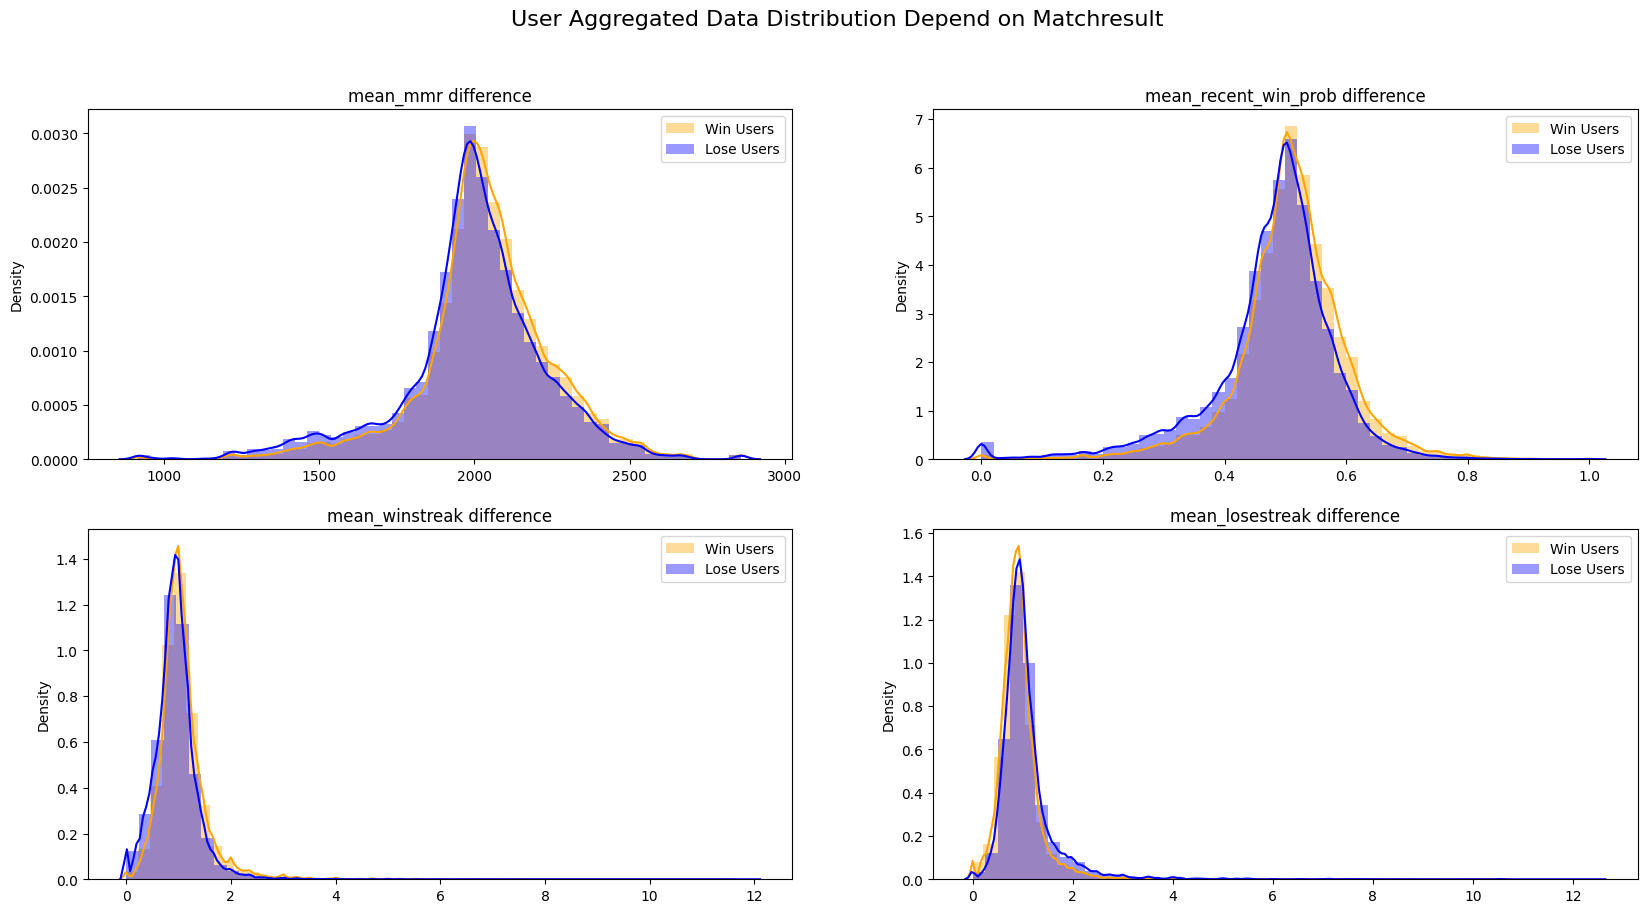

In [735]:
# 집계 데이터 반영 파생변수의 승패에 미치는 영향력 확인
# 미세하게 유저별 평균 실력점수, 평균 최근 10경기 승률, 평균 연승 횟수가 높은 유저들의 승률이 더 높은 것을 알 수 있음
# 또한, 평균 연패 횟수가 높은 유저들의 승률은 상대적을 낮았음

plt.figure(figsize=(20,10))
plt.suptitle('User Aggregated Data Distribution Depend on Matchresult', fontsize=16)
plt.subplot(2,2,1)
plt.title('mean_mmr difference')
sns.distplot(x=train[train['matchresult'] == 1]['mean_mmr'], color='orange', label='Win Users')
sns.distplot(x=train[train['matchresult'] == 0]['mean_mmr'], color='blue', label='Lose Users')
plt.legend()

plt.subplot(2,2,2)
plt.title('mean_recent_win_prob difference')
sns.distplot(x=train[train['matchresult'] == 1]['mean_recentwinprob'], color='orange', label='Win Users')
sns.distplot(x=train[train['matchresult'] == 0]['mean_recentwinprob'], color='blue', label='Lose Users')
plt.legend()

plt.subplot(2,2,3)
plt.title('mean_winstreak difference')
sns.distplot(x=train[train['matchresult'] == 1]['mean_winstreak'], color='orange', label='Win Users')
sns.distplot(x=train[train['matchresult'] == 0]['mean_winstreak'], color='blue', label='Lose Users')
plt.legend()

plt.subplot(2,2,4)
plt.title('mean_losestreak difference')
sns.distplot(x=train[train['matchresult'] == 1]['mean_losestreak'], color='orange', label='Win Users')
sns.distplot(x=train[train['matchresult'] == 0]['mean_losestreak'], color='blue', label='Lose Users')
plt.legend()
plt.show()

## 8) guildid별 평균 특성을 고려한 파생변수 생성
* 길드id별로 변수를 집계하면 승패에 영향을 미치는 유의미한 차이가 있을 것이라 판단
* 길드id별로 다양한 변수들을 집계하여 파생변수 생성

<유저 id별 집계 데이터>
* winstreak, losestreak

In [736]:
# guildid별 평균 특성을 고려한 파생변수 생성
# 길드id별 특성을 평균 집계하고, 이를 변수화

train_winstreak_per_guild = train.groupby('guildid')['winstreak'].mean()
train_losestreak_per_guild = train.groupby('guildid')['losestreak'].mean()
test_winstreak_per_guild = test.groupby('guildid')['winstreak'].mean()
test_losestreak_per_guild = test.groupby('guildid')['losestreak'].mean()

train_guilddf = [train_winstreak_per_guild, train_losestreak_per_guild]
test_guilddf = [test_winstreak_per_guild, test_losestreak_per_guild]

for df in train_guilddf:
  train = pd.merge(train, df, on='guildid', how='left')

for df in test_guilddf:
  test = pd.merge(test, df, on='guildid', how='left')


train.rename(columns={'winstreak_x' : 'winstreak', 'winstreak_y' : 'mean_winstreak_guild',
                      'losestreak_x' : 'losestreak', 'losestreak_y' : 'mean_losestreak_guild'}, inplace=True)
test.rename(columns={'winstreak_x' : 'winstreak', 'winstreak_y' : 'mean_winstreak_guild',
                      'losestreak_x' : 'losestreak', 'losestreak_y' : 'mean_losestreak_guild'}, inplace=True)

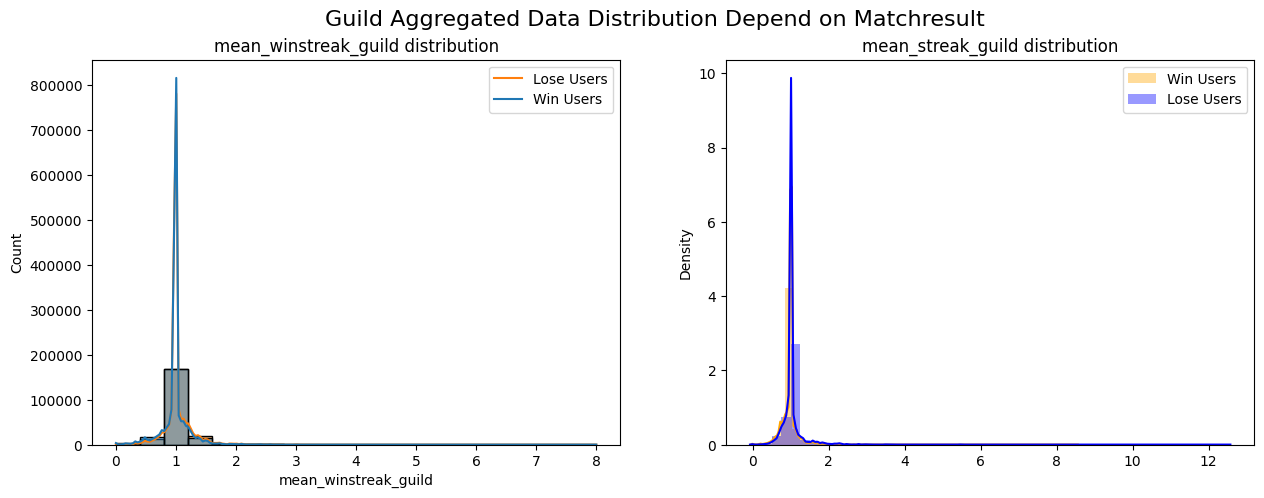

In [737]:
# 집계 데이터 반영 파생변수의 승패에 미치는 영향력 확인
# 길드 평균 연승 횟수가 높은 유저들의 승률이 미세하게 더 높은 것을 알 수 있음
# 또한, 길드 평균 연패 횟수가 낮은 유저들의 승률은 상대적으로 낮았음

plt.figure(figsize=(15,5))
plt.suptitle('Guild Aggregated Data Distribution Depend on Matchresult', fontsize=16)
plt.subplot(1,2,1)
plt.title('mean_winstreak_guild distribution')
sns.histplot(x=train['mean_winstreak_guild'], hue=train['matchresult'], kde=True)
plt.legend(['Lose Users', 'Win Users'])

plt.subplot(1,2,2)
plt.title('mean_streak_guild distribution')
sns.distplot(x=train[train['matchresult'] == 1]['mean_losestreak_guild'], color='orange', label='Win Users')
sns.distplot(x=train[train['matchresult'] == 0]['mean_losestreak_guild'], color='blue', label='Lose Users')
plt.legend()
plt.show()

## 9) matchid & teamid별 평균 특성을 고려한 파생변수 생성
* 매치id 및 팀id 별로 변수를 집계하면 승패에 영향을 미치는 유의미한 차이가 있을 것이라 판단
* 매치id 및 팀id 별로 다양한 변수들을 집계하여 파생변수 생성

<유저 id별 집계 데이터>
* tier, mmr, recentwinprob, winstreak, losestreak, accumatches

In [738]:
# 매치당 두 팀간 티어 차이 계산
# 매치가 성사된 팀별 tier의 합이 낮은 경우 패배할 확률이 높지 않을까?
# unranked(0), bronze(1), silver(2), gold(3), platinum(4), diamond(5), master(6) 변환 후 집계
map_tier = {'unranked' : 0, 'bronze' : 1, 'silver' : 2, 'gold' : 3, 'platinum' : 4,
            'diamond' : 5, 'master' : 6}
train[['tier_num']] = train[['tier']].applymap(map_tier.get)
tier_sum_train = train.groupby(['matchid', 'teamid'])['tier_num'].sum()
tier_sum_train = pd.DataFrame(tier_sum_train).reset_index()
tier_sum_train['tier_num_diff'] = tier_sum_train.groupby(['matchid'])['tier_num'].diff().fillna(0)  # 매치당 두팀의 티어 점수 차이 계산
tier_sum_train = tier_sum_train.drop(columns='tier_num')
train = pd.merge(train, tier_sum_train, on=['matchid', 'teamid'])
print(train.shape)


test[['tier_num']] = test[['tier']].applymap(map_tier.get)
tier_sum_test = test.groupby(['matchid', 'teamid'])['tier_num'].sum()
tier_sum_test = pd.DataFrame(tier_sum_test).reset_index()
tier_sum_test['tier_num_diff'] = tier_sum_test.groupby(['matchid'])['tier_num'].diff().fillna(0)  # 매치당 두팀의 티어 점수 차이 계산
tier_sum_test = tier_sum_test.drop(columns='tier_num')
test = pd.merge(test, tier_sum_test, on=['matchid', 'teamid'])
print(test.shape)

(410384, 29)
(140488, 24)


In [739]:
# 나머지 변수들 매치당 팀별 평균의 차이 계산

def get_match_team_diff(df, col):

  '''
  team_mean_df : 매치당 팀별 지정된 변수 col의 평균 차이를 계산하는 DataFrame
  최종적으로는 투입되는 df와 team_mean_df의 병합된 DataFrame을 리턴
  '''
  team_mean_df = df.groupby(['matchid', 'teamid'])[col].mean()
  team_mean_df = pd.DataFrame(team_mean_df).reset_index()
  team_mean_df[f'team_{col}_diff'] = team_mean_df.groupby(['matchid'])[col].diff().fillna(0)
  team_mean_df = team_mean_df.drop(columns=col)
  df = pd.merge(df, team_mean_df, on=['matchid', 'teamid'])
  return df

col_list = ['mmr', 'recentwinprob', 'winstreak', 'losestreak', 'accumatches']

for col in col_list:
  train = get_match_team_diff(train, col)
  test = get_match_team_diff(test, col)

print(train.shape)
print(test.shape)

(410384, 34)
(140488, 29)


## 10) 왜도 확인 및 수치형 변수 로그 변환
* 기존 변수 및 파생변수의 왜도를 확인하고, -2~+2 범위를 벗어난 경우 로그 변환

<로그 변환 대상 데이터>
* winstreak, losestreak, accumatches, mean_winstreak, mean_losestreak, mean_winstreak_guild, mean_losestreak_guild

In [740]:
# 훈련 데이터 왜도 확인
train.skew()

accountid                  0.037087
teamid                     0.000000
mmr                       -0.571039
winstreak                  2.210295
losestreak                 2.445538
recentwinprob             -0.209365
accumatches                2.681508
itemid                    -5.093509
matchresult                0.000000
matchscore                -0.796203
isDrop                     1.412775
isEscape                   8.340200
guild_yn                   0.273138
recentwinprob_35          -1.548392
losestreak_cat            -0.026309
mmr_cat                    0.002094
tier_mmr                  -0.688588
mean_winstreak             2.826225
mean_losestreak            4.090671
mean_recentwinprob        -1.027548
mean_mmr                  -0.586476
mean_winstreak_guild       2.849915
mean_losestreak_guild      5.937833
tier_num                  -1.381173
tier_num_diff             -0.044735
team_mmr_diff             -0.149268
team_recentwinprob_diff   -0.020752
team_winstreak_diff       -0

In [741]:
# 왜도 높은 수치형 변수에 대한 log 변환 수행
cols = ['winstreak', 'losestreak', 'accumatches', 'mean_winstreak', 'mean_losestreak', 'mean_winstreak_guild', 'mean_losestreak_guild']

for col in cols:
  train[col] = train[col].apply(lambda x: np.log1p(x))
  test[col] = test[col].apply(lambda x: np.log1p(x))

train.skew() # 왜도 재확인

accountid                  0.037087
teamid                     0.000000
mmr                       -0.571039
winstreak                  0.752738
losestreak                 0.778677
recentwinprob             -0.209365
accumatches               -0.454547
itemid                    -5.093509
matchresult                0.000000
matchscore                -0.796203
isDrop                     1.412775
isEscape                   8.340200
guild_yn                   0.273138
recentwinprob_35          -1.548392
losestreak_cat            -0.026309
mmr_cat                    0.002094
tier_mmr                  -0.688588
mean_winstreak             0.315054
mean_losestreak            1.078651
mean_recentwinprob        -1.027548
mean_mmr                  -0.586476
mean_winstreak_guild       0.087557
mean_losestreak_guild      1.514721
tier_num                  -1.381173
tier_num_diff             -0.044735
team_mmr_diff             -0.149268
team_recentwinprob_diff   -0.020752
team_winstreak_diff       -0

# 2. Modeling - LightGBM
* 1) 모델링에 사용할 컬럼 필터링
* 2) 모델 검증 및 개별 모델 변수 중요도 계산
* 3) optuna 기반 모델 튜닝
* 4) 최종 모델 학습 및 테스트 데이터 제출

In [742]:
# 모델링에 사용될 train, test 컬럼 필터링
train = train.drop(columns=['createdatekst', 'teamid', 'matchid', 'accountid', 'tier', 'guildid', 'isDrop', 'isEscape', 'matchscore', 'guild_yn', 'itemid', 'tier_num'])
test = test.drop(columns=['createdatekst', 'teamid', 'matchid', 'accountid', 'guildid', 'tier', 'itemid', 'tier_num'])

print(train.shape)
print(test.shape)

(410384, 22)
(140488, 21)


In [743]:
def model_valid(df=None):
  '''
  LGBM 모델을 학습&검증하는 함수
  훈련 데이터와 20% 비중의 검증 데이터를 추가하여 모델 학습 및 검증
  '''

  train_X = train.drop(columns='matchresult')
  train_y = train['matchresult']
  X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42, shuffle=True,
                                                        stratify=train_y)
  model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=0)
  model.fit(X_train, y_train)
  result = model.predict(X_valid)

  print(f'Accuracy Score : {accuracy_score(y_valid, result)}')
  print(f'Precision Score : {precision_score(y_valid, result)}')
  print(f'Recall Score : {recall_score(y_valid, result)}')
  print(f'F1 Score : {f1_score(y_valid, result)}')

  return model

model = model_valid(train)

Accuracy Score : 0.6226835776161409
Precision Score : 0.6183669151012156
Recall Score : 0.6408938057410205
F1 Score : 0.6294288688659943


Accuracy Score : 0.6291668291161449
Precision Score : 0.6246378992513449
Recall Score : 0.6473351787594058
F1 Score : 0.6357840321654221


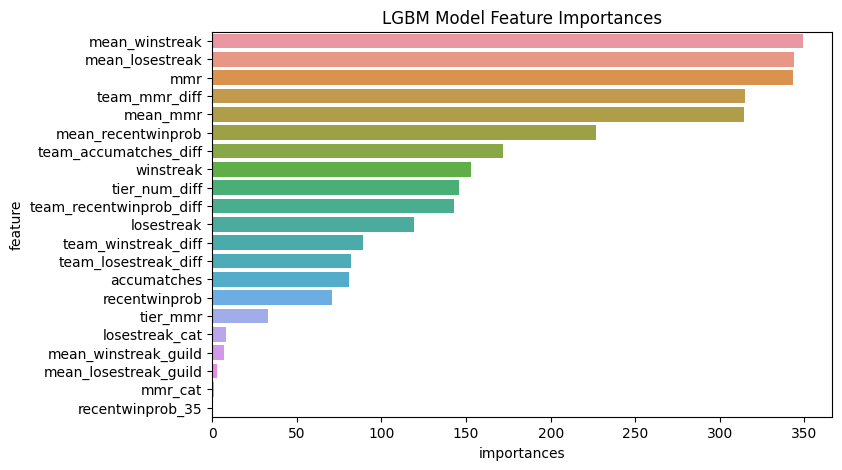

In [744]:
def check_fi(df, model_name=None):
  '''
  전체 훈련 데이터 학습 시 LightGBM 모델의 정확도5 및 Feature Importance 도출
  '''

  train_X = df.drop(columns='matchresult')
  train_y = df['matchresult']

  if model_name == 'lgbm':
    model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=0)
    model.fit(train_X, train_y)
    result = model.predict(train_X)

    print(f'Accuracy Score : {accuracy_score(train_y, result)}')
    print(f'Precision Score : {precision_score(train_y, result)}')
    print(f'Recall Score : {recall_score(train_y, result)}')
    print(f'F1 Score : {f1_score(train_y, result)}')

  fi = model.feature_importances_
  imp = pd.DataFrame()
  imp['feature'] = train_X.columns
  imp['importances'] = fi
  imp.sort_values(by='importances', ascending=False, inplace=True)
  imp.reset_index(drop=True, inplace=True)

  return model, imp

lgbm, lgbm_imp = check_fi(train, model_name='lgbm')

plt.figure(figsize=(8,5))
sns.barplot(x=lgbm_imp['importances'], y=lgbm_imp['feature'])
plt.title('LGBM Model Feature Importances')
plt.show()
# Feature Importance 도출 결과, [mean_losestreak, mean_winstreak, mean_mmr, mean_recentwinprob, mmr, ...] 순으로 변수 중요도를 보임
# 특히, 유저의 데이터를 집계한 mean_losestreak, mean_winstreak, mean_mmr, mean_recentwinprob은 모델 성능에 큰 영향을 미치는 요인

In [ ]:
def tune_lgbm(trial):
  '''
  optuna를 활용한 LGBM 모델 튜닝
  '''
  params = {
      'n_estimators' : trial.suggest_int('n_estimators', 100, 2000),
      'max_depth' : trial.suggest_int('max_depth', 4, 16),
      'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 1),
      'min_child_samples' : trial.suggest_int('min_child_samples', 1, 30),
      'colsample_bytree' : trial.suggest_float('colsample_bytree', 0.4, 1),
      'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
  }


  train_X = train.drop(columns='matchresult')
  train_y = train['matchresult']

  X_train, X_valid, y_train, y_valid = train_test_split(train_X, train_y, test_size=0.2, random_state=42, shuffle=True,
                                                        stratify=train_y)


  model = LGBMClassifier(**params, random_state=42, n_jobs=-1, verbose=0)
  model.fit(X_train, y_train)
  score = accuracy_score(model.predict(X_valid), y_valid)

  return score

lgbm_study = optuna.create_study(direction='maximize')
lgbm_study.optimize(tune_lgbm, n_trials=500)
print(f'Best Trial : {lgbm_study.best_trial.value}, \nParams : {lgbm_study.best_trial.params}')

[I 2023-11-02 06:40:03,053] A new study created in memory with name: no-name-440adf68-df28-47aa-bb56-bdd378bbedfe


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:09,132] Trial 0 finished with value: 0.6027023404851541 and parameters: {'n_estimators': 327, 'max_depth': 14, 'learning_rate': 0.3555651062536887, 'min_child_samples': 1, 'colsample_bytree': 0.5775113769919858, 'subsample': 0.9162321167457494}. Best is trial 0 with value: 0.6027023404851541.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:15,414] Trial 1 finished with value: 0.5739001181817074 and parameters: {'n_estimators': 727, 'max_depth': 10, 'learning_rate': 0.9465285138061096, 'min_child_samples': 10, 'colsample_bytree': 0.4543655060789026, 'subsample': 0.6937468831525226}. Best is trial 0 with value: 0.6027023404851541.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:22,744] Trial 2 finished with value: 0.5884596171887374 and parameters: {'n_estimators': 646, 'max_depth': 13, 'learning_rate': 0.6070964328715734, 'min_child_samples': 4, 'colsample_bytree': 0.9658797566618982, 'subsample': 0.9756935775388872}. Best is trial 0 with value: 0.6027023404851541.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:24,893] Trial 3 finished with value: 0.5976704801588753 and parameters: {'n_estimators': 254, 'max_depth': 16, 'learning_rate': 0.5736785640504803, 'min_child_samples': 20, 'colsample_bytree': 0.577501224624783, 'subsample': 0.41522961387903906}. Best is trial 0 with value: 0.6027023404851541.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:26,401] Trial 4 finished with value: 0.5970856634623585 and parameters: {'n_estimators': 161, 'max_depth': 15, 'learning_rate': 0.7947207626580753, 'min_child_samples': 1, 'colsample_bytree': 0.8787739846085554, 'subsample': 0.8336403908719796}. Best is trial 0 with value: 0.6027023404851541.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:41,277] Trial 5 finished with value: 0.6085139564067887 and parameters: {'n_estimators': 1409, 'max_depth': 8, 'learning_rate': 0.022990231909581306, 'min_child_samples': 29, 'colsample_bytree': 0.6772783908134626, 'subsample': 0.833892120471718}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:40:45,204] Trial 6 finished with value: 0.5869001059980262 and parameters: {'n_estimators': 421, 'max_depth': 7, 'learning_rate': 0.934868445390428, 'min_child_samples': 2, 'colsample_bytree': 0.46309900963997974, 'subsample': 0.6852369512849169}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 06:41:02,676] Trial 7 finished with value: 0.5853771458508473 and parameters: {'n_estimators': 1693, 'max_depth': 5, 'learning_rate': 0.5204938434073624, 'min_child_samples': 5, 'colsample_bytree': 0.778673085839811, 'subsample': 0.6001472483467429}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:41:06,144] Trial 8 finished with value: 0.6065523837372223 and parameters: {'n_estimators': 174, 'max_depth': 15, 'learning_rate': 0.05730386611364995, 'min_child_samples': 15, 'colsample_bytree': 0.6334796975226652, 'subsample': 0.9915587762056314}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

[I 2023-11-02 06:41:22,570] Trial 9 finished with value: 0.5908476186995139 and parameters: {'n_estimators': 1521, 'max_depth': 5, 'learning_rate': 0.4285647845631605, 'min_child_samples': 14, 'colsample_bytree': 0.5718195851638841, 'subsample': 0.5737186723883456}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:41:33,791] Trial 10 finished with value: 0.6076976497679009 and parameters: {'n_estimators': 1299, 'max_depth': 9, 'learning_rate': 0.07481486705537181, 'min_child_samples': 30, 'colsample_bytree': 0.757856537159349, 'subsample': 0.8039806657468813}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:41:49,622] Trial 11 finished with value: 0.6080631602032238 and parameters: {'n_estimators': 1272, 'max_depth': 9, 'learning_rate': 0.08058265812373241, 'min_child_samples': 30, 'colsample_bytree': 0.7259134514890563, 'subsample': 0.8035852660147825}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:42:05,843] Trial 12 finished with value: 0.6010088088014913 and parameters: {'n_estimators': 1122, 'max_depth': 8, 'learning_rate': 0.18482933505849683, 'min_child_samples': 28, 'colsample_bytree': 0.71730895206547, 'subsample': 0.8307475491739903}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:42:21,687] Trial 13 finished with value: 0.5972440513176651 and parameters: {'n_estimators': 1909, 'max_depth': 11, 'learning_rate': 0.19706130671077715, 'min_child_samples': 24, 'colsample_bytree': 0.8075148078351783, 'subsample': 0.7475402645785546}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:42:40,276] Trial 14 finished with value: 0.6013012171497496 and parameters: {'n_estimators': 1339, 'max_depth': 12, 'learning_rate': 0.0023397038152814936, 'min_child_samples': 25, 'colsample_bytree': 0.6784340308076999, 'subsample': 0.8783924951587427}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:42:50,146] Trial 15 finished with value: 0.6018372991215566 and parameters: {'n_estimators': 948, 'max_depth': 7, 'learning_rate': 0.24057805581816583, 'min_child_samples': 21, 'colsample_bytree': 0.6793754750671577, 'subsample': 0.7433636918214092}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-02 06:43:05,527] Trial 16 finished with value: 0.6068569757666581 and parameters: {'n_estimators': 1656, 'max_depth': 4, 'learning_rate': 0.12283994238778817, 'min_child_samples': 30, 'colsample_bytree': 0.8538343430781665, 'subsample': 0.9026488313475102}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:43:18,667] Trial 17 finished with value: 0.6071615677960939 and parameters: {'n_estimators': 1018, 'max_depth': 10, 'learning_rate': 0.011133525722951123, 'min_child_samples': 26, 'colsample_bytree': 0.7569311970508187, 'subsample': 0.7777810621931531}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:43:33,413] Trial 18 finished with value: 0.5927970076879028 and parameters: {'n_estimators': 1346, 'max_depth': 7, 'learning_rate': 0.31388076110100416, 'min_child_samples': 21, 'colsample_bytree': 0.6433216655265961, 'subsample': 0.6536216471698191}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:43:49,456] Trial 19 finished with value: 0.6010088088014913 and parameters: {'n_estimators': 1902, 'max_depth': 9, 'learning_rate': 0.17073471989525657, 'min_child_samples': 11, 'colsample_bytree': 0.8200985737309991, 'subsample': 0.9984254215894293}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 06:43:58,937] Trial 20 finished with value: 0.6000462979884742 and parameters: {'n_estimators': 830, 'max_depth': 6, 'learning_rate': 0.2654471441211222, 'min_child_samples': 23, 'colsample_bytree': 0.7212850678980972, 'subsample': 0.8728214081676572}. Best is trial 5 with value: 0.6085139564067887.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:44:07,867] Trial 21 finished with value: 0.6088672831609342 and parameters: {'n_estimators': 1208, 'max_depth': 9, 'learning_rate': 0.070634180691937, 'min_child_samples': 30, 'colsample_bytree': 0.7515865834271686, 'subsample': 0.7695079006934515}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:44:19,221] Trial 22 finished with value: 0.6056386076489151 and parameters: {'n_estimators': 1155, 'max_depth': 9, 'learning_rate': 0.12169100842702976, 'min_child_samples': 27, 'colsample_bytree': 0.7324425900783764, 'subsample': 0.7605851952832782}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:44:33,515] Trial 23 finished with value: 0.6060772201713026 and parameters: {'n_estimators': 1504, 'max_depth': 8, 'learning_rate': 0.09198192623275181, 'min_child_samples': 30, 'colsample_bytree': 0.7868127265091657, 'subsample': 0.8326728693588165}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:44:49,640] Trial 24 finished with value: 0.6077707518549654 and parameters: {'n_estimators': 1218, 'max_depth': 11, 'learning_rate': 0.010766552568374782, 'min_child_samples': 19, 'colsample_bytree': 0.6908488561377655, 'subsample': 0.7217410898054128}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:45:04,398] Trial 25 finished with value: 0.6040912801393813 and parameters: {'n_estimators': 1542, 'max_depth': 11, 'learning_rate': 0.1392304560361078, 'min_child_samples': 28, 'colsample_bytree': 0.8670222061452924, 'subsample': 0.7939638709757826}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:45:18,762] Trial 26 finished with value: 0.5973293370859072 and parameters: {'n_estimators': 1415, 'max_depth': 8, 'learning_rate': 0.2427378472867553, 'min_child_samples': 23, 'colsample_bytree': 0.6315547151865611, 'subsample': 0.9193749906956447}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:45:39,173] Trial 27 finished with value: 0.6081606296526433 and parameters: {'n_estimators': 1726, 'max_depth': 12, 'learning_rate': 0.05769538776297106, 'min_child_samples': 17, 'colsample_bytree': 0.7521532218659595, 'subsample': 0.7005549458489972}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:46:00,915] Trial 28 finished with value: 0.6006798494097007 and parameters: {'n_estimators': 1764, 'max_depth': 12, 'learning_rate': 0.1816623583553953, 'min_child_samples': 17, 'colsample_bytree': 0.8212501226874446, 'subsample': 0.6672148428191392}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:46:18,121] Trial 29 finished with value: 0.5900434957418035 and parameters: {'n_estimators': 1967, 'max_depth': 13, 'learning_rate': 0.33745840976397146, 'min_child_samples': 7, 'colsample_bytree': 0.7664738976020536, 'subsample': 0.7111723458657409}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:46:35,224] Trial 30 finished with value: 0.5874971063757204 and parameters: {'n_estimators': 1642, 'max_depth': 13, 'learning_rate': 0.4256055469659511, 'min_child_samples': 17, 'colsample_bytree': 0.9112199257565123, 'subsample': 0.6125500591604487}. Best is trial 21 with value: 0.6088672831609342.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:46:47,330] Trial 31 finished with value: 0.6100856512786773 and parameters: {'n_estimators': 943, 'max_depth': 10, 'learning_rate': 0.0645152156591331, 'min_child_samples': 27, 'colsample_bytree': 0.7415737628834664, 'subsample': 0.773884585048124}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:46:58,378] Trial 32 finished with value: 0.6087698137115148 and parameters: {'n_estimators': 915, 'max_depth': 10, 'learning_rate': 0.06414680335832423, 'min_child_samples': 28, 'colsample_bytree': 0.7532452657234612, 'subsample': 0.7294484551745503}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:03,080] Trial 33 finished with value: 0.6078316702608526 and parameters: {'n_estimators': 595, 'max_depth': 10, 'learning_rate': 0.13967845613620722, 'min_child_samples': 27, 'colsample_bytree': 0.7899799564198141, 'subsample': 0.7553642316836414}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:17,393] Trial 34 finished with value: 0.6028363609781059 and parameters: {'n_estimators': 902, 'max_depth': 10, 'learning_rate': 0.0037479616044056377, 'min_child_samples': 28, 'colsample_bytree': 0.6953284807885421, 'subsample': 0.9315622230140661}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:26,347] Trial 35 finished with value: 0.6086479768997405 and parameters: {'n_estimators': 749, 'max_depth': 10, 'learning_rate': 0.07765126557604383, 'min_child_samples': 25, 'colsample_bytree': 0.8335682555950393, 'subsample': 0.8501641103845272}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:31,736] Trial 36 finished with value: 0.6088185484362245 and parameters: {'n_estimators': 673, 'max_depth': 10, 'learning_rate': 0.09193216133301393, 'min_child_samples': 25, 'colsample_bytree': 0.9190424689647575, 'subsample': 0.724814034340247}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:36,170] Trial 37 finished with value: 0.6029581977898802 and parameters: {'n_estimators': 534, 'max_depth': 11, 'learning_rate': 0.29211403592924723, 'min_child_samples': 23, 'colsample_bytree': 0.9759518547438095, 'subsample': 0.6452182006093047}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:43,578] Trial 38 finished with value: 0.6029094630651705 and parameters: {'n_estimators': 729, 'max_depth': 9, 'learning_rate': 0.2547200546578442, 'min_child_samples': 27, 'colsample_bytree': 0.9138851156572861, 'subsample': 0.6952221673908092}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:47,871] Trial 39 finished with value: 0.6074417924631749 and parameters: {'n_estimators': 398, 'max_depth': 14, 'learning_rate': 0.2149352962304704, 'min_child_samples': 25, 'colsample_bytree': 0.8763632018947292, 'subsample': 0.7293237100068649}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:47:59,084] Trial 40 finished with value: 0.6062112406642542 and parameters: {'n_estimators': 1037, 'max_depth': 11, 'learning_rate': 0.14462844954915016, 'min_child_samples': 21, 'colsample_bytree': 0.9553616133575125, 'subsample': 0.6767118160319422}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:08,302] Trial 41 finished with value: 0.6095739366692252 and parameters: {'n_estimators': 827, 'max_depth': 10, 'learning_rate': 0.06872613208161477, 'min_child_samples': 26, 'colsample_bytree': 0.8181791966104451, 'subsample': 0.7755042204706181}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:17,202] Trial 42 finished with value: 0.6092206099150798 and parameters: {'n_estimators': 868, 'max_depth': 10, 'learning_rate': 0.0536141325338048, 'min_child_samples': 26, 'colsample_bytree': 0.7948116800994292, 'subsample': 0.7784406563138903}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:26,728] Trial 43 finished with value: 0.6070031799407873 and parameters: {'n_estimators': 832, 'max_depth': 9, 'learning_rate': 0.12018653309267294, 'min_child_samples': 26, 'colsample_bytree': 0.8414221818615323, 'subsample': 0.7836183407070045}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:32,245] Trial 44 finished with value: 0.6089038342044666 and parameters: {'n_estimators': 607, 'max_depth': 12, 'learning_rate': 0.0429980480123094, 'min_child_samples': 24, 'colsample_bytree': 0.7956552112182361, 'subsample': 0.8111093415039157}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:40,188] Trial 45 finished with value: 0.6088794668421117 and parameters: {'n_estimators': 521, 'max_depth': 12, 'learning_rate': 0.04077116266488041, 'min_child_samples': 29, 'colsample_bytree': 0.7910206571906812, 'subsample': 0.8221627297044076}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:44,848] Trial 46 finished with value: 0.6095373856256929 and parameters: {'n_estimators': 520, 'max_depth': 12, 'learning_rate': 0.05023924137871187, 'min_child_samples': 26, 'colsample_bytree': 0.8020881017744577, 'subsample': 0.8010751532110191}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:47,685] Trial 47 finished with value: 0.606454914287803 and parameters: {'n_estimators': 341, 'max_depth': 14, 'learning_rate': 0.2065744424089267, 'min_child_samples': 22, 'colsample_bytree': 0.8115559649443489, 'subsample': 0.857064622585391}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:55,908] Trial 48 finished with value: 0.6087332626679826 and parameters: {'n_estimators': 525, 'max_depth': 13, 'learning_rate': 0.0337904223283325, 'min_child_samples': 24, 'colsample_bytree': 0.8016765015988332, 'subsample': 0.8148041343146768}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:48:58,307] Trial 49 finished with value: 0.6078804049855623 and parameters: {'n_estimators': 239, 'max_depth': 14, 'learning_rate': 0.16181747042455175, 'min_child_samples': 19, 'colsample_bytree': 0.8439111890418058, 'subsample': 0.8045418994167597}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:08,025] Trial 50 finished with value: 0.6086236095373856 and parameters: {'n_estimators': 792, 'max_depth': 16, 'learning_rate': 0.1071269992121392, 'min_child_samples': 26, 'colsample_bytree': 0.7803331233616125, 'subsample': 0.8926528670299002}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:12,902] Trial 51 finished with value: 0.6092449772774347 and parameters: {'n_estimators': 484, 'max_depth': 12, 'learning_rate': 0.03990474167039074, 'min_child_samples': 29, 'colsample_bytree': 0.7983658275479433, 'subsample': 0.8381827642912261}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:21,645] Trial 52 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 622, 'max_depth': 12, 'learning_rate': 0.03935869649407173, 'min_child_samples': 29, 'colsample_bytree': 0.8213646868433222, 'subsample': 0.9573325931285994}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:25,781] Trial 53 finished with value: 0.6072346698831586 and parameters: {'n_estimators': 414, 'max_depth': 11, 'learning_rate': 0.03995658401479486, 'min_child_samples': 29, 'colsample_bytree': 0.8273230013887981, 'subsample': 0.9536131558103643}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:32,041] Trial 54 finished with value: 0.6085626911314985 and parameters: {'n_estimators': 649, 'max_depth': 12, 'learning_rate': 0.1010547857813304, 'min_child_samples': 27, 'colsample_bytree': 0.863374423011651, 'subsample': 0.8725358511901472}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:38,391] Trial 55 finished with value: 0.6075758129561266 and parameters: {'n_estimators': 483, 'max_depth': 15, 'learning_rate': 0.18130074477584382, 'min_child_samples': 12, 'colsample_bytree': 0.7720997079335405, 'subsample': 0.9677625890979721}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:47,960] Trial 56 finished with value: 0.6085992421750308 and parameters: {'n_estimators': 974, 'max_depth': 13, 'learning_rate': 0.01816848461887336, 'min_child_samples': 26, 'colsample_bytree': 0.8487057583011498, 'subsample': 0.9004926023380122}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:49:58,069] Trial 57 finished with value: 0.6084043032761919 and parameters: {'n_estimators': 870, 'max_depth': 11, 'learning_rate': 0.09238914945477288, 'min_child_samples': 29, 'colsample_bytree': 0.8140003814699722, 'subsample': 0.8510766700595995}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:10,015] Trial 58 finished with value: 0.6047979336476723 and parameters: {'n_estimators': 1104, 'max_depth': 13, 'learning_rate': 0.13697763629510487, 'min_child_samples': 28, 'colsample_bytree': 0.7328238071729216, 'subsample': 0.774394527668237}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:14,026] Trial 59 finished with value: 0.5895561484947062 and parameters: {'n_estimators': 273, 'max_depth': 12, 'learning_rate': 0.0019931835270828938, 'min_child_samples': 30, 'colsample_bytree': 0.772693850129088, 'subsample': 0.9164643752516818}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:24,434] Trial 60 finished with value: 0.609342446726854 and parameters: {'n_estimators': 787, 'max_depth': 10, 'learning_rate': 0.05133718944253512, 'min_child_samples': 29, 'colsample_bytree': 0.807921512937758, 'subsample': 0.9441500455182021}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:31,152] Trial 61 finished with value: 0.6099759981480805 and parameters: {'n_estimators': 678, 'max_depth': 10, 'learning_rate': 0.06302079886344945, 'min_child_samples': 29, 'colsample_bytree': 0.8016620418085044, 'subsample': 0.9519018855911311}. Best is trial 31 with value: 0.6100856512786773.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:39,427] Trial 62 finished with value: 0.6102805901775162 and parameters: {'n_estimators': 701, 'max_depth': 10, 'learning_rate': 0.06915390015440526, 'min_child_samples': 27, 'colsample_bytree': 0.8005959484673204, 'subsample': 0.9827402657772503}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:46,292] Trial 63 finished with value: 0.6076367313620137 and parameters: {'n_estimators': 774, 'max_depth': 8, 'learning_rate': 0.10785081577141559, 'min_child_samples': 28, 'colsample_bytree': 0.739177249723399, 'subsample': 0.9986892102523657}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:52,270] Trial 64 finished with value: 0.6088063647550471 and parameters: {'n_estimators': 461, 'max_depth': 11, 'learning_rate': 0.16056877186739701, 'min_child_samples': 27, 'colsample_bytree': 0.7694147687287484, 'subsample': 0.9468889186051017}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:50:57,994] Trial 65 finished with value: 0.6093789977703864 and parameters: {'n_estimators': 696, 'max_depth': 10, 'learning_rate': 0.07619650173233387, 'min_child_samples': 30, 'colsample_bytree': 0.8442946755431711, 'subsample': 0.977390783275949}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:06,674] Trial 66 finished with value: 0.608209364377353 and parameters: {'n_estimators': 692, 'max_depth': 9, 'learning_rate': 0.07713400518215625, 'min_child_samples': 30, 'colsample_bytree': 0.7153176836177579, 'subsample': 0.9748263648967288}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:19,368] Trial 67 finished with value: 0.6026048710357348 and parameters: {'n_estimators': 971, 'max_depth': 8, 'learning_rate': 0.21533737503011002, 'min_child_samples': 8, 'colsample_bytree': 0.8546019438232709, 'subsample': 0.9402613350287152}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:24,865] Trial 68 finished with value: 0.6089769362915312 and parameters: {'n_estimators': 574, 'max_depth': 10, 'learning_rate': 0.1199567836901049, 'min_child_samples': 24, 'colsample_bytree': 0.8282157554099264, 'subsample': 0.9177120657124958}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:32,323] Trial 69 finished with value: 0.6057848118230442 and parameters: {'n_estimators': 721, 'max_depth': 9, 'learning_rate': 0.15738196632826001, 'min_child_samples': 3, 'colsample_bytree': 0.8736406203881033, 'subsample': 0.9919979465558099}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:39,075] Trial 70 finished with value: 0.6086601605809179 and parameters: {'n_estimators': 807, 'max_depth': 9, 'learning_rate': 0.06355031138216743, 'min_child_samples': 27, 'colsample_bytree': 0.747717556457035, 'subsample': 0.8872664375288717}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:48,780] Trial 71 finished with value: 0.6067229552737063 and parameters: {'n_estimators': 681, 'max_depth': 11, 'learning_rate': 0.02143748503884659, 'min_child_samples': 29, 'colsample_bytree': 0.8157569171398346, 'subsample': 0.9228116296293006}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:53,366] Trial 72 finished with value: 0.6086357932185631 and parameters: {'n_estimators': 548, 'max_depth': 10, 'learning_rate': 0.07879105414874824, 'min_child_samples': 28, 'colsample_bytree': 0.8047006644281778, 'subsample': 0.9678657670584806}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:51:56,939] Trial 73 finished with value: 0.6097566918868867 and parameters: {'n_estimators': 369, 'max_depth': 10, 'learning_rate': 0.05771489514911063, 'min_child_samples': 30, 'colsample_bytree': 0.8915201324709778, 'subsample': 0.8726989580819708}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:02,305] Trial 74 finished with value: 0.5864736771568162 and parameters: {'n_estimators': 173, 'max_depth': 10, 'learning_rate': 0.0013559807482243502, 'min_child_samples': 30, 'colsample_bytree': 0.8927096006525659, 'subsample': 0.8737244506475856}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:10,353] Trial 75 finished with value: 0.6063818122007383 and parameters: {'n_estimators': 1072, 'max_depth': 10, 'learning_rate': 0.11761977921981837, 'min_child_samples': 25, 'colsample_bytree': 0.8387660816580221, 'subsample': 0.8983208280961428}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:20,468] Trial 76 finished with value: 0.6078682213043849 and parameters: {'n_estimators': 919, 'max_depth': 11, 'learning_rate': 0.0940901149495774, 'min_child_samples': 30, 'colsample_bytree': 0.7800591628378495, 'subsample': 0.9433444327529145}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:26,546] Trial 77 finished with value: 0.60917187519037 and parameters: {'n_estimators': 751, 'max_depth': 8, 'learning_rate': 0.060732675994016855, 'min_child_samples': 28, 'colsample_bytree': 0.8860067504567756, 'subsample': 0.9815730466112792}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:35,852] Trial 78 finished with value: 0.603884157559365 and parameters: {'n_estimators': 861, 'max_depth': 10, 'learning_rate': 0.18489896376944304, 'min_child_samples': 26, 'colsample_bytree': 0.8516160454853783, 'subsample': 0.9373977479970773}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:43,265] Trial 79 finished with value: 0.6062721590701414 and parameters: {'n_estimators': 989, 'max_depth': 9, 'learning_rate': 0.14341694441204741, 'min_child_samples': 27, 'colsample_bytree': 0.75955007966097, 'subsample': 0.8632965915861257}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:48,658] Trial 80 finished with value: 0.6080753438844012 and parameters: {'n_estimators': 352, 'max_depth': 7, 'learning_rate': 0.06965037326034487, 'min_child_samples': 22, 'colsample_bytree': 0.8333325246794487, 'subsample': 0.9085578057227359}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:52:53,452] Trial 81 finished with value: 0.6075148945502394 and parameters: {'n_estimators': 476, 'max_depth': 11, 'learning_rate': 0.02639686360237104, 'min_child_samples': 29, 'colsample_bytree': 0.8075906956386515, 'subsample': 0.8265129861113325}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:01,839] Trial 82 finished with value: 0.6097445082057092 and parameters: {'n_estimators': 644, 'max_depth': 10, 'learning_rate': 0.05645776186490715, 'min_child_samples': 29, 'colsample_bytree': 0.7994394829756103, 'subsample': 0.8825735656550826}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:06,869] Trial 83 finished with value: 0.6086114258562082 and parameters: {'n_estimators': 622, 'max_depth': 10, 'learning_rate': 0.08507970793858607, 'min_child_samples': 28, 'colsample_bytree': 0.7833050433499685, 'subsample': 0.8782890473636092}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:12,419] Trial 84 finished with value: 0.6072590372455133 and parameters: {'n_estimators': 707, 'max_depth': 9, 'learning_rate': 0.1285271253632637, 'min_child_samples': 30, 'colsample_bytree': 0.8567430209793274, 'subsample': 0.8477934935648946}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:22,401] Trial 85 finished with value: 0.6099516307857256 and parameters: {'n_estimators': 796, 'max_depth': 10, 'learning_rate': 0.05193334950914529, 'min_child_samples': 25, 'colsample_bytree': 0.8275523679844287, 'subsample': 0.7983880432853621}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:31,112] Trial 86 finished with value: 0.6072712209266908 and parameters: {'n_estimators': 582, 'max_depth': 10, 'learning_rate': 0.023121182747651736, 'min_child_samples': 25, 'colsample_bytree': 0.8312955355625159, 'subsample': 0.7943082236283214}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:36,343] Trial 87 finished with value: 0.6087576300303373 and parameters: {'n_estimators': 654, 'max_depth': 11, 'learning_rate': 0.10507866145463338, 'min_child_samples': 27, 'colsample_bytree': 0.7600955389827321, 'subsample': 0.7478607557658329}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:46,384] Trial 88 finished with value: 0.6100125491916127 and parameters: {'n_estimators': 833, 'max_depth': 9, 'learning_rate': 0.05537382244749783, 'min_child_samples': 26, 'colsample_bytree': 0.7944682169834208, 'subsample': 0.7637036771483782}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:53:53,516] Trial 89 finished with value: 0.6060528528089477 and parameters: {'n_estimators': 933, 'max_depth': 9, 'learning_rate': 0.15807982219126598, 'min_child_samples': 24, 'colsample_bytree': 0.7878862339674088, 'subsample': 0.7641300567277134}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:04,248] Trial 90 finished with value: 0.6089891199727085 and parameters: {'n_estimators': 876, 'max_depth': 9, 'learning_rate': 0.034621854834707866, 'min_child_samples': 23, 'colsample_bytree': 0.8657431810485279, 'subsample': 0.8069558524353175}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:11,290] Trial 91 finished with value: 0.6098663450174836 and parameters: {'n_estimators': 839, 'max_depth': 10, 'learning_rate': 0.057904142912460245, 'min_child_samples': 26, 'colsample_bytree': 0.8165156290026289, 'subsample': 0.7954624743555208}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:20,457] Trial 92 finished with value: 0.6091353241468377 and parameters: {'n_estimators': 847, 'max_depth': 10, 'learning_rate': 0.06432022071165479, 'min_child_samples': 26, 'colsample_bytree': 0.8241159532029412, 'subsample': 0.7904045229398512}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:29,931] Trial 93 finished with value: 0.6091109567844829 and parameters: {'n_estimators': 752, 'max_depth': 9, 'learning_rate': 0.050765092996455236, 'min_child_samples': 26, 'colsample_bytree': 0.7941507325175224, 'subsample': 0.8287214071440128}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:46,516] Trial 94 finished with value: 0.5952824786480987 and parameters: {'n_estimators': 1037, 'max_depth': 11, 'learning_rate': 0.0013571849124475038, 'min_child_samples': 24, 'colsample_bytree': 0.7691514202294831, 'subsample': 0.7459385568624147}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:54:52,778] Trial 95 finished with value: 0.6082459154208852 and parameters: {'n_estimators': 806, 'max_depth': 10, 'learning_rate': 0.11012890709366144, 'min_child_samples': 25, 'colsample_bytree': 0.8125373070050064, 'subsample': 0.7751802791789711}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:02,410] Trial 96 finished with value: 0.607673282405546 and parameters: {'n_estimators': 820, 'max_depth': 9, 'learning_rate': 0.09117636654023603, 'min_child_samples': 22, 'colsample_bytree': 0.7494272169667312, 'subsample': 0.7950346606736747}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:06,225] Trial 97 finished with value: 0.6061015875336574 and parameters: {'n_estimators': 291, 'max_depth': 8, 'learning_rate': 0.022793291982716478, 'min_child_samples': 27, 'colsample_bytree': 0.7979328961780514, 'subsample': 0.8142596182404818}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:12,588] Trial 98 finished with value: 0.6097445082057092 and parameters: {'n_estimators': 384, 'max_depth': 10, 'learning_rate': 0.12884725652975837, 'min_child_samples': 28, 'colsample_bytree': 0.7806158983338862, 'subsample': 0.7577927272375389}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:14,165] Trial 99 finished with value: 0.6075027108690619 and parameters: {'n_estimators': 116, 'max_depth': 10, 'learning_rate': 0.14504015003614004, 'min_child_samples': 28, 'colsample_bytree': 0.7799411851747334, 'subsample': 0.7629282557021784}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:21,108] Trial 100 finished with value: 0.6072955882890456 and parameters: {'n_estimators': 883, 'max_depth': 11, 'learning_rate': 0.12544023018577408, 'min_child_samples': 29, 'colsample_bytree': 0.7410620284405436, 'subsample': 0.7135688935542319}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:28,194] Trial 101 finished with value: 0.6082824664644175 and parameters: {'n_estimators': 429, 'max_depth': 9, 'learning_rate': 0.05146385198025415, 'min_child_samples': 26, 'colsample_bytree': 0.8266666190653057, 'subsample': 0.8413292637904555}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:31,914] Trial 102 finished with value: 0.609257160958612 and parameters: {'n_estimators': 393, 'max_depth': 10, 'learning_rate': 0.08722232971731411, 'min_child_samples': 25, 'colsample_bytree': 0.7654715025099047, 'subsample': 0.7345199456648813}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:38,068] Trial 103 finished with value: 0.6084530380009016 and parameters: {'n_estimators': 637, 'max_depth': 11, 'learning_rate': 0.0310636956852865, 'min_child_samples': 27, 'colsample_bytree': 0.8163421948101856, 'subsample': 0.785140831164186}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:44,893] Trial 104 finished with value: 0.6084774053632565 and parameters: {'n_estimators': 379, 'max_depth': 10, 'learning_rate': 0.061214180349731674, 'min_child_samples': 14, 'colsample_bytree': 0.8015973251692594, 'subsample': 0.7599692579083046}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:47,272] Trial 105 finished with value: 0.6079169560290947 and parameters: {'n_estimators': 206, 'max_depth': 10, 'learning_rate': 0.09927579512542059, 'min_child_samples': 28, 'colsample_bytree': 0.7890539738132816, 'subsample': 0.8609474544948374}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:50,789] Trial 106 finished with value: 0.6075636292749491 and parameters: {'n_estimators': 306, 'max_depth': 11, 'learning_rate': 0.03984953443137426, 'min_child_samples': 26, 'colsample_bytree': 0.8387289908969711, 'subsample': 0.8207866216941673}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:55:58,440] Trial 107 finished with value: 0.6087332626679826 and parameters: {'n_estimators': 508, 'max_depth': 9, 'learning_rate': 0.07558147626397144, 'min_child_samples': 28, 'colsample_bytree': 0.7786655820735728, 'subsample': 0.8034378456428443}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:10,436] Trial 108 finished with value: 0.6059431996783509 and parameters: {'n_estimators': 445, 'max_depth': 10, 'learning_rate': 0.019528475421554975, 'min_child_samples': 27, 'colsample_bytree': 0.7269973090564503, 'subsample': 0.8348672962546416}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:15,253] Trial 109 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 566, 'max_depth': 9, 'learning_rate': 0.12674611024664284, 'min_child_samples': 29, 'colsample_bytree': 0.8201679350015911, 'subsample': 0.7390600828893085}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:24,675] Trial 110 finished with value: 0.6097688755680641 and parameters: {'n_estimators': 776, 'max_depth': 11, 'learning_rate': 0.0547951415046812, 'min_child_samples': 25, 'colsample_bytree': 0.7612297118425136, 'subsample': 0.7690143830997346}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:31,295] Trial 111 finished with value: 0.6098054266115964 and parameters: {'n_estimators': 774, 'max_depth': 11, 'learning_rate': 0.0618875082430838, 'min_child_samples': 25, 'colsample_bytree': 0.7629484796516862, 'subsample': 0.7749495089960843}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:40,463] Trial 112 finished with value: 0.606796057360771 and parameters: {'n_estimators': 778, 'max_depth': 11, 'learning_rate': 0.10628157797757268, 'min_child_samples': 25, 'colsample_bytree': 0.7620204228194289, 'subsample': 0.7792395808808141}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:48,400] Trial 113 finished with value: 0.60874544634916 and parameters: {'n_estimators': 943, 'max_depth': 11, 'learning_rate': 0.06874238780721983, 'min_child_samples': 23, 'colsample_bytree': 0.7448796630942967, 'subsample': 0.746824402223546}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:56:57,827] Trial 114 finished with value: 0.6098541613363061 and parameters: {'n_estimators': 748, 'max_depth': 10, 'learning_rate': 0.04673930842044802, 'min_child_samples': 24, 'colsample_bytree': 0.7751052251333884, 'subsample': 0.7713421927438847}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:57:06,000] Trial 115 finished with value: 0.6066620368678193 and parameters: {'n_estimators': 750, 'max_depth': 10, 'learning_rate': 0.012738680442592236, 'min_child_samples': 24, 'colsample_bytree': 0.7089565175099327, 'subsample': 0.7216045731516258}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:57:14,254] Trial 116 finished with value: 0.6086357932185631 and parameters: {'n_estimators': 732, 'max_depth': 10, 'learning_rate': 0.049057777933759636, 'min_child_samples': 25, 'colsample_bytree': 0.7345512180572739, 'subsample': 0.7567746742283913}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:57:24,490] Trial 117 finished with value: 0.6088794668421117 and parameters: {'n_estimators': 904, 'max_depth': 11, 'learning_rate': 0.0860659847151547, 'min_child_samples': 27, 'colsample_bytree': 0.7568988069921639, 'subsample': 0.7059618516156828}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:57:33,030] Trial 118 finished with value: 0.6096714061186447 and parameters: {'n_estimators': 1006, 'max_depth': 10, 'learning_rate': 0.03557780293996693, 'min_child_samples': 23, 'colsample_bytree': 0.7693951953732386, 'subsample': 0.767997634566332}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:57:44,614] Trial 119 finished with value: 0.5973780718106169 and parameters: {'n_estimators': 674, 'max_depth': 11, 'learning_rate': 0.003156509648190968, 'min_child_samples': 21, 'colsample_bytree': 0.7860299775098458, 'subsample': 0.6868886474939853}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:58:09,888] Trial 120 finished with value: 0.6065767510995772 and parameters: {'n_estimators': 1158, 'max_depth': 10, 'learning_rate': 0.11383242127716431, 'min_child_samples': 20, 'colsample_bytree': 0.7169073890085077, 'subsample': 0.8820166617124007}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:58:18,515] Trial 121 finished with value: 0.6099516307857256 and parameters: {'n_estimators': 1011, 'max_depth': 10, 'learning_rate': 0.045100955465570455, 'min_child_samples': 23, 'colsample_bytree': 0.7740416604288272, 'subsample': 0.769755392433504}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:58:29,659] Trial 122 finished with value: 0.6096592224374673 and parameters: {'n_estimators': 961, 'max_depth': 10, 'learning_rate': 0.056551744247942994, 'min_child_samples': 24, 'colsample_bytree': 0.7469774284375892, 'subsample': 0.7877175911470833}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:58:41,258] Trial 123 finished with value: 0.6088672831609342 and parameters: {'n_estimators': 1066, 'max_depth': 10, 'learning_rate': 0.07380769592036351, 'min_child_samples': 25, 'colsample_bytree': 0.7985054040603383, 'subsample': 0.8119369941478958}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:58:51,875] Trial 124 finished with value: 0.6082580991020627 and parameters: {'n_estimators': 840, 'max_depth': 9, 'learning_rate': 0.028606028571299486, 'min_child_samples': 28, 'colsample_bytree': 0.772007811945787, 'subsample': 0.7377832469694725}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-02 06:59:01,288] Trial 125 finished with value: 0.6090013036538859 and parameters: {'n_estimators': 774, 'max_depth': 4, 'learning_rate': 0.08523776068328504, 'min_child_samples': 22, 'colsample_bytree': 0.7306490103489667, 'subsample': 0.755023842091718}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:09,976] Trial 126 finished with value: 0.6066985879113516 and parameters: {'n_estimators': 710, 'max_depth': 11, 'learning_rate': 0.13603203832181715, 'min_child_samples': 27, 'colsample_bytree': 0.778473048956388, 'subsample': 0.7991182645905476}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:18,612] Trial 127 finished with value: 0.6095861203504027 and parameters: {'n_estimators': 831, 'max_depth': 10, 'learning_rate': 0.05023675458271486, 'min_child_samples': 26, 'colsample_bytree': 0.754925767320359, 'subsample': 0.7718605842089106}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:28,396] Trial 128 finished with value: 0.6083190175079498 and parameters: {'n_estimators': 901, 'max_depth': 9, 'learning_rate': 0.10750004166644811, 'min_child_samples': 23, 'colsample_bytree': 0.8086591699217482, 'subsample': 0.849045094035558}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:36,036] Trial 129 finished with value: 0.6053340156194793 and parameters: {'n_estimators': 607, 'max_depth': 11, 'learning_rate': 0.17213862541316546, 'min_child_samples': 29, 'colsample_bytree': 0.7903009935225515, 'subsample': 0.7250098818453027}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:42,449] Trial 130 finished with value: 0.6078682213043849 and parameters: {'n_estimators': 662, 'max_depth': 12, 'learning_rate': 0.021029054588189995, 'min_child_samples': 25, 'colsample_bytree': 0.7625011413643819, 'subsample': 0.8220031803984054}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 06:59:53,834] Trial 131 finished with value: 0.6094886509009833 and parameters: {'n_estimators': 995, 'max_depth': 10, 'learning_rate': 0.037853397388361285, 'min_child_samples': 23, 'colsample_bytree': 0.7720338932920623, 'subsample': 0.7707993582613307}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:00:05,709] Trial 132 finished with value: 0.6088672831609342 and parameters: {'n_estimators': 1114, 'max_depth': 10, 'learning_rate': 0.06243463051130148, 'min_child_samples': 24, 'colsample_bytree': 0.740744000886749, 'subsample': 0.7516054892251942}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:00:13,327] Trial 133 finished with value: 0.6065645674183998 and parameters: {'n_estimators': 1001, 'max_depth': 10, 'learning_rate': 0.08911821901453487, 'min_child_samples': 24, 'colsample_bytree': 0.7868775729547797, 'subsample': 0.7917508361273561}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:00:23,180] Trial 134 finished with value: 0.6095861203504027 and parameters: {'n_estimators': 795, 'max_depth': 9, 'learning_rate': 0.039884426148214844, 'min_child_samples': 26, 'colsample_bytree': 0.8032270649487943, 'subsample': 0.7695035319811766}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:00:40,723] Trial 135 finished with value: 0.5948682334880661 and parameters: {'n_estimators': 1177, 'max_depth': 10, 'learning_rate': 0.0011708994874391337, 'min_child_samples': 30, 'colsample_bytree': 0.774576502043321, 'subsample': 0.9254600811647379}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:00:52,746] Trial 136 finished with value: 0.608379935913837 and parameters: {'n_estimators': 860, 'max_depth': 6, 'learning_rate': 0.025313044784091708, 'min_child_samples': 22, 'colsample_bytree': 0.7551265964654881, 'subsample': 0.7857212108813638}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:05,296] Trial 137 finished with value: 0.6084895890444338 and parameters: {'n_estimators': 933, 'max_depth': 11, 'learning_rate': 0.06748550274597134, 'min_child_samples': 20, 'colsample_bytree': 0.834642721555923, 'subsample': 0.9011801109247883}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:11,228] Trial 138 finished with value: 0.608124078609111 and parameters: {'n_estimators': 745, 'max_depth': 9, 'learning_rate': 0.09794386728291386, 'min_child_samples': 29, 'colsample_bytree': 0.814555171584615, 'subsample': 0.7339585819159434}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:22,762] Trial 139 finished with value: 0.6093058956833217 and parameters: {'n_estimators': 1028, 'max_depth': 10, 'learning_rate': 0.04769336538478876, 'min_child_samples': 27, 'colsample_bytree': 0.7252401680640561, 'subsample': 0.8071771909215747}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:33,532] Trial 140 finished with value: 0.6061015875336574 and parameters: {'n_estimators': 1072, 'max_depth': 10, 'learning_rate': 0.12355822509246028, 'min_child_samples': 18, 'colsample_bytree': 0.7709287405022788, 'subsample': 0.7611910606222282}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:41,146] Trial 141 finished with value: 0.6094886509009833 and parameters: {'n_estimators': 945, 'max_depth': 10, 'learning_rate': 0.05902228463894593, 'min_child_samples': 23, 'colsample_bytree': 0.7460283547047899, 'subsample': 0.7858752462627866}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:51,079] Trial 142 finished with value: 0.6085992421750308 and parameters: {'n_estimators': 885, 'max_depth': 10, 'learning_rate': 0.08210934046836213, 'min_child_samples': 24, 'colsample_bytree': 0.7955491768831844, 'subsample': 0.8300394924754324}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:01:58,054] Trial 143 finished with value: 0.6094033651327412 and parameters: {'n_estimators': 814, 'max_depth': 11, 'learning_rate': 0.03798428629681892, 'min_child_samples': 24, 'colsample_bytree': 0.7446116892342735, 'subsample': 0.7839594442195271}. Best is trial 62 with value: 0.6102805901775162.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:10,125] Trial 144 finished with value: 0.6104024269892906 and parameters: {'n_estimators': 962, 'max_depth': 10, 'learning_rate': 0.053295968438285275, 'min_child_samples': 25, 'colsample_bytree': 0.7843350714012085, 'subsample': 0.8678975496898379}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:19,676] Trial 145 finished with value: 0.6080266091596915 and parameters: {'n_estimators': 702, 'max_depth': 10, 'learning_rate': 0.027724337710383077, 'min_child_samples': 25, 'colsample_bytree': 0.7840550153649851, 'subsample': 0.8624336526494769}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:27,583] Trial 146 finished with value: 0.6087819973926922 and parameters: {'n_estimators': 1009, 'max_depth': 9, 'learning_rate': 0.07018112076410957, 'min_child_samples': 26, 'colsample_bytree': 0.8034992704542202, 'subsample': 0.9544626035605328}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:37,520] Trial 147 finished with value: 0.6077463844926106 and parameters: {'n_estimators': 966, 'max_depth': 11, 'learning_rate': 0.10254757603192446, 'min_child_samples': 28, 'colsample_bytree': 0.761265701374765, 'subsample': 0.8481230280837293}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:43,346] Trial 148 finished with value: 0.5935158448773713 and parameters: {'n_estimators': 794, 'max_depth': 10, 'learning_rate': 0.40040036222870834, 'min_child_samples': 26, 'colsample_bytree': 0.8260675607548631, 'subsample': 0.8886850792209688}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:02:52,001] Trial 149 finished with value: 0.6075027108690619 and parameters: {'n_estimators': 903, 'max_depth': 10, 'learning_rate': 0.14992596594103497, 'min_child_samples': 25, 'colsample_bytree': 0.8498354058980022, 'subsample': 0.8168775789259914}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:02,116] Trial 150 finished with value: 0.6075392619125942 and parameters: {'n_estimators': 726, 'max_depth': 11, 'learning_rate': 0.01733566049252005, 'min_child_samples': 1, 'colsample_bytree': 0.7895656663376062, 'subsample': 0.9113499542209363}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:09,723] Trial 151 finished with value: 0.6097323245245319 and parameters: {'n_estimators': 954, 'max_depth': 10, 'learning_rate': 0.052818274418196136, 'min_child_samples': 23, 'colsample_bytree': 0.7687376703917563, 'subsample': 0.795612150526117}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:19,564] Trial 152 finished with value: 0.6096348550751124 and parameters: {'n_estimators': 844, 'max_depth': 10, 'learning_rate': 0.04892798076052729, 'min_child_samples': 23, 'colsample_bytree': 0.7645621174886577, 'subsample': 0.7663271493332882}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:27,758] Trial 153 finished with value: 0.6079169560290947 and parameters: {'n_estimators': 1045, 'max_depth': 10, 'learning_rate': 0.08116570311609254, 'min_child_samples': 26, 'colsample_bytree': 0.7796666426532187, 'subsample': 0.8682059284296784}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:31,820] Trial 154 finished with value: 0.607758568173788 and parameters: {'n_estimators': 230, 'max_depth': 9, 'learning_rate': 0.06123071722494645, 'min_child_samples': 27, 'colsample_bytree': 0.8079947573309313, 'subsample': 0.7425157542563948}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:03:47,979] Trial 155 finished with value: 0.6031896877322515 and parameters: {'n_estimators': 1098, 'max_depth': 10, 'learning_rate': 0.003301074105650788, 'min_child_samples': 25, 'colsample_bytree': 0.7977643965371362, 'subsample': 0.801257020219528}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:00,508] Trial 156 finished with value: 0.6100125491916127 and parameters: {'n_estimators': 1241, 'max_depth': 11, 'learning_rate': 0.039632663646340625, 'min_child_samples': 23, 'colsample_bytree': 0.7702889297884192, 'subsample': 0.9994832019808796}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:11,650] Trial 157 finished with value: 0.6062843427513189 and parameters: {'n_estimators': 1496, 'max_depth': 11, 'learning_rate': 0.0926218468393918, 'min_child_samples': 28, 'colsample_bytree': 0.8173768155391122, 'subsample': 0.9451758839548747}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:24,982] Trial 158 finished with value: 0.6049685051841563 and parameters: {'n_estimators': 1314, 'max_depth': 11, 'learning_rate': 0.11688021519254499, 'min_child_samples': 22, 'colsample_bytree': 0.7843507266085131, 'subsample': 0.9955889700693114}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:36,493] Trial 159 finished with value: 0.587911351535753 and parameters: {'n_estimators': 1255, 'max_depth': 11, 'learning_rate': 0.49533875674302996, 'min_child_samples': 30, 'colsample_bytree': 0.7348313673987719, 'subsample': 0.9747495621249441}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:39,762] Trial 160 finished with value: 0.6080753438844012 and parameters: {'n_estimators': 337, 'max_depth': 12, 'learning_rate': 0.07097306319911609, 'min_child_samples': 21, 'colsample_bytree': 0.7595369687529387, 'subsample': 0.9818016052544065}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:04:50,265] Trial 161 finished with value: 0.6094155488139187 and parameters: {'n_estimators': 771, 'max_depth': 10, 'learning_rate': 0.03683201596928366, 'min_child_samples': 24, 'colsample_bytree': 0.773290539451428, 'subsample': 0.9651804235876293}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:05:01,520] Trial 162 finished with value: 0.608550507450321 and parameters: {'n_estimators': 919, 'max_depth': 10, 'learning_rate': 0.021270405449749324, 'min_child_samples': 23, 'colsample_bytree': 0.772454533539331, 'subsample': 0.9333424240088604}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:05:06,759] Trial 163 finished with value: 0.6092206099150798 and parameters: {'n_estimators': 643, 'max_depth': 10, 'learning_rate': 0.05500658632901648, 'min_child_samples': 25, 'colsample_bytree': 0.7924981539939522, 'subsample': 0.8349143854165886}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:05:20,303] Trial 164 finished with value: 0.6101709370469194 and parameters: {'n_estimators': 1380, 'max_depth': 9, 'learning_rate': 0.04494775178104905, 'min_child_samples': 23, 'colsample_bytree': 0.7522899387707804, 'subsample': 0.7713593075251353}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:05:34,153] Trial 165 finished with value: 0.6083921195950145 and parameters: {'n_estimators': 1480, 'max_depth': 9, 'learning_rate': 0.07835226991958877, 'min_child_samples': 27, 'colsample_bytree': 0.7548319692448429, 'subsample': 0.7538754697987171}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:05:50,390] Trial 166 finished with value: 0.6089647526103537 and parameters: {'n_estimators': 1452, 'max_depth': 8, 'learning_rate': 0.051064977749131074, 'min_child_samples': 22, 'colsample_bytree': 0.724190903646629, 'subsample': 0.8029082541090428}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:06:04,757] Trial 167 finished with value: 0.606345261157206 and parameters: {'n_estimators': 1571, 'max_depth': 9, 'learning_rate': 0.09409513950927142, 'min_child_samples': 16, 'colsample_bytree': 0.9049415892589145, 'subsample': 0.8920275715339574}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:06:23,523] Trial 168 finished with value: 0.6097810592492415 and parameters: {'n_estimators': 1812, 'max_depth': 9, 'learning_rate': 0.017350306776436727, 'min_child_samples': 24, 'colsample_bytree': 0.8108907532516613, 'subsample': 0.7197222626409258}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:06:47,380] Trial 169 finished with value: 0.6097445082057092 and parameters: {'n_estimators': 1786, 'max_depth': 8, 'learning_rate': 0.019551713239019185, 'min_child_samples': 29, 'colsample_bytree': 0.8436965189316726, 'subsample': 0.7164281573263949}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:07:17,283] Trial 170 finished with value: 0.605017239908866 and parameters: {'n_estimators': 1978, 'max_depth': 9, 'learning_rate': 0.002821240548322994, 'min_child_samples': 6, 'colsample_bytree': 0.8241572574451339, 'subsample': 0.7279055164060153}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:07:36,383] Trial 171 finished with value: 0.6102684064963388 and parameters: {'n_estimators': 1875, 'max_depth': 8, 'learning_rate': 0.022555219380971145, 'min_child_samples': 29, 'colsample_bytree': 0.8390581077928824, 'subsample': 0.7045321355324591}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:07:59,300] Trial 172 finished with value: 0.6104024269892906 and parameters: {'n_estimators': 1840, 'max_depth': 7, 'learning_rate': 0.03047690425778172, 'min_child_samples': 30, 'colsample_bytree': 0.8607630720938253, 'subsample': 0.7101883155466411}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:08:17,248] Trial 173 finished with value: 0.6095617529880478 and parameters: {'n_estimators': 1844, 'max_depth': 7, 'learning_rate': 0.03258411488210173, 'min_child_samples': 30, 'colsample_bytree': 0.8580739972490123, 'subsample': 0.6885964727977936}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:08:33,922] Trial 174 finished with value: 0.5905795777136104 and parameters: {'n_estimators': 1818, 'max_depth': 7, 'learning_rate': 0.2925223843516289, 'min_child_samples': 30, 'colsample_bytree': 0.8727839533394024, 'subsample': 0.7021491268426983}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:08:54,935] Trial 175 finished with value: 0.6097810592492415 and parameters: {'n_estimators': 1860, 'max_depth': 8, 'learning_rate': 0.019806071620733758, 'min_child_samples': 29, 'colsample_bytree': 0.8619719858160417, 'subsample': 0.7004662436102744}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:09:13,530] Trial 176 finished with value: 0.609513018263338 and parameters: {'n_estimators': 1750, 'max_depth': 7, 'learning_rate': 0.016996552101154867, 'min_child_samples': 24, 'colsample_bytree': 0.8649425368647131, 'subsample': 0.7045264223663671}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:09:31,187] Trial 177 finished with value: 0.6085139564067887 and parameters: {'n_estimators': 1844, 'max_depth': 8, 'learning_rate': 0.037677648296226815, 'min_child_samples': 25, 'colsample_bytree': 0.841260696657566, 'subsample': 0.6988760925171179}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:09:52,008] Trial 178 finished with value: 0.610049100235145 and parameters: {'n_estimators': 1881, 'max_depth': 8, 'learning_rate': 0.01793827637875109, 'min_child_samples': 29, 'colsample_bytree': 0.8831184761349351, 'subsample': 0.7164143324097675}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:10:16,549] Trial 179 finished with value: 0.6015692581356531 and parameters: {'n_estimators': 1891, 'max_depth': 6, 'learning_rate': 0.001663447962901278, 'min_child_samples': 29, 'colsample_bytree': 0.8566992388594619, 'subsample': 0.7226989349987115}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:10:40,525] Trial 180 finished with value: 0.6096957734809996 and parameters: {'n_estimators': 1944, 'max_depth': 8, 'learning_rate': 0.02569139135836756, 'min_child_samples': 11, 'colsample_bytree': 0.8739389420513817, 'subsample': 0.7406248414566543}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:11:01,292] Trial 181 finished with value: 0.6075758129561266 and parameters: {'n_estimators': 1687, 'max_depth': 8, 'learning_rate': 0.06861662034167886, 'min_child_samples': 29, 'colsample_bytree': 0.8759639554545767, 'subsample': 0.7094154491115238}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:11:17,291] Trial 182 finished with value: 0.5974024391729718 and parameters: {'n_estimators': 1892, 'max_depth': 8, 'learning_rate': 0.22360536275401488, 'min_child_samples': 28, 'colsample_bytree': 0.8342122990691652, 'subsample': 0.9989417384571336}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:11:36,670] Trial 183 finished with value: 0.6093302630456766 and parameters: {'n_estimators': 1929, 'max_depth': 7, 'learning_rate': 0.044685757643957054, 'min_child_samples': 29, 'colsample_bytree': 0.8912753105166528, 'subsample': 0.6726178129039718}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:11:58,089] Trial 184 finished with value: 0.6096592224374673 and parameters: {'n_estimators': 1869, 'max_depth': 5, 'learning_rate': 0.018970911019251947, 'min_child_samples': 30, 'colsample_bytree': 0.9020538687136156, 'subsample': 0.6879052699476369}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:12:14,564] Trial 185 finished with value: 0.6094764672198058 and parameters: {'n_estimators': 1589, 'max_depth': 8, 'learning_rate': 0.04325454676399964, 'min_child_samples': 26, 'colsample_bytree': 0.889457171077604, 'subsample': 0.7340228611086501}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:12:32,766] Trial 186 finished with value: 0.6085992421750308 and parameters: {'n_estimators': 1768, 'max_depth': 7, 'learning_rate': 0.0699896540809804, 'min_child_samples': 25, 'colsample_bytree': 0.8796581907649961, 'subsample': 0.6591770764479191}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:12:54,203] Trial 187 finished with value: 0.5776161409408238 and parameters: {'n_estimators': 1840, 'max_depth': 9, 'learning_rate': 0.6193815301291066, 'min_child_samples': 24, 'colsample_bytree': 0.8478245781487668, 'subsample': 0.7771575309199225}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:13:12,766] Trial 188 finished with value: 0.6096104877127575 and parameters: {'n_estimators': 1785, 'max_depth': 8, 'learning_rate': 0.01781114393647939, 'min_child_samples': 30, 'colsample_bytree': 0.9219396992121731, 'subsample': 0.7504092674725152}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:13:39,253] Trial 189 finished with value: 0.6014352376427013 and parameters: {'n_estimators': 1723, 'max_depth': 6, 'learning_rate': 0.0018671297164599213, 'min_child_samples': 27, 'colsample_bytree': 0.8153969718538547, 'subsample': 0.7159742909518231}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:13:53,868] Trial 190 finished with value: 0.6097810592492415 and parameters: {'n_estimators': 1382, 'max_depth': 8, 'learning_rate': 0.040340302142555545, 'min_child_samples': 28, 'colsample_bytree': 0.6998486680374975, 'subsample': 0.675058893422455}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:14:11,849] Trial 191 finished with value: 0.6099028960610159 and parameters: {'n_estimators': 1941, 'max_depth': 8, 'learning_rate': 0.04408188364867509, 'min_child_samples': 28, 'colsample_bytree': 0.7091077324635822, 'subsample': 0.6930050398972845}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:14:26,264] Trial 192 finished with value: 0.6091596915091926 and parameters: {'n_estimators': 1409, 'max_depth': 8, 'learning_rate': 0.03797106699999709, 'min_child_samples': 28, 'colsample_bytree': 0.6969874014435022, 'subsample': 0.6825739636064783}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:14:43,765] Trial 193 finished with value: 0.6067716899984161 and parameters: {'n_estimators': 1902, 'max_depth': 8, 'learning_rate': 0.060080113615138396, 'min_child_samples': 28, 'colsample_bytree': 0.6863385045579014, 'subsample': 0.6955425508053219}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:15:00,942] Trial 194 finished with value: 0.6096348550751124 and parameters: {'n_estimators': 1370, 'max_depth': 8, 'learning_rate': 0.03105074705559642, 'min_child_samples': 27, 'colsample_bytree': 0.7084541230469639, 'subsample': 0.6790968119075795}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:15:18,535] Trial 195 finished with value: 0.6048710357347369 and parameters: {'n_estimators': 1938, 'max_depth': 8, 'learning_rate': 0.08476038833480093, 'min_child_samples': 29, 'colsample_bytree': 0.7011140353819239, 'subsample': 0.7051712717092532}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:15:39,268] Trial 196 finished with value: 0.6084043032761919 and parameters: {'n_estimators': 1992, 'max_depth': 7, 'learning_rate': 0.04748775434462926, 'min_child_samples': 26, 'colsample_bytree': 0.6837244470813081, 'subsample': 0.7173686328705402}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:15:56,597] Trial 197 finished with value: 0.6070153636219647 and parameters: {'n_estimators': 1926, 'max_depth': 8, 'learning_rate': 0.07399092788738736, 'min_child_samples': 28, 'colsample_bytree': 0.7124285000520081, 'subsample': 0.6659704297357497}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:16:10,404] Trial 198 finished with value: 0.608721078986805 and parameters: {'n_estimators': 1229, 'max_depth': 9, 'learning_rate': 0.02058993637969138, 'min_child_samples': 26, 'colsample_bytree': 0.7380250997115511, 'subsample': 0.741252427717044}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:16:26,781] Trial 199 finished with value: 0.594271233110372 and parameters: {'n_estimators': 1869, 'max_depth': 8, 'learning_rate': 0.24859497438000083, 'min_child_samples': 27, 'colsample_bytree': 0.6775875900769672, 'subsample': 0.6506268150247257}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:16:43,252] Trial 200 finished with value: 0.6046029947488334 and parameters: {'n_estimators': 1834, 'max_depth': 9, 'learning_rate': 0.1051381299843251, 'min_child_samples': 24, 'colsample_bytree': 0.7224706713680199, 'subsample': 0.692760093235136}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:16:58,059] Trial 201 finished with value: 0.60917187519037 and parameters: {'n_estimators': 1369, 'max_depth': 7, 'learning_rate': 0.056612392738331144, 'min_child_samples': 29, 'colsample_bytree': 0.8629617892635341, 'subsample': 0.7754294823369668}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:17:18,135] Trial 202 finished with value: 0.6099759981480805 and parameters: {'n_estimators': 1962, 'max_depth': 8, 'learning_rate': 0.03915810271629723, 'min_child_samples': 30, 'colsample_bytree': 0.8068653638571911, 'subsample': 0.6729957585666975}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:17:36,609] Trial 203 finished with value: 0.6091840588715475 and parameters: {'n_estimators': 1982, 'max_depth': 8, 'learning_rate': 0.0355805599361248, 'min_child_samples': 30, 'colsample_bytree': 0.8073392610800013, 'subsample': 0.6735191055877514}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:17:54,953] Trial 204 finished with value: 0.6098541613363061 and parameters: {'n_estimators': 1813, 'max_depth': 8, 'learning_rate': 0.017517870536705282, 'min_child_samples': 29, 'colsample_bytree': 0.8247605784063713, 'subsample': 0.7270530782292891}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:18:22,834] Trial 205 finished with value: 0.6023611974121861 and parameters: {'n_estimators': 1805, 'max_depth': 8, 'learning_rate': 0.0017803942373336573, 'min_child_samples': 29, 'colsample_bytree': 0.8273436505462347, 'subsample': 0.7249180593288169}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:18:41,434] Trial 206 finished with value: 0.6099028960610159 and parameters: {'n_estimators': 1946, 'max_depth': 8, 'learning_rate': 0.02230306716945837, 'min_child_samples': 28, 'colsample_bytree': 0.8366195613284104, 'subsample': 0.6423077681385134}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:19:05,407] Trial 207 finished with value: 0.6095617529880478 and parameters: {'n_estimators': 1964, 'max_depth': 7, 'learning_rate': 0.023180648540433606, 'min_child_samples': 29, 'colsample_bytree': 0.8321034437108754, 'subsample': 0.6266966672702136}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:19:24,431] Trial 208 finished with value: 0.6090134873350634 and parameters: {'n_estimators': 1907, 'max_depth': 8, 'learning_rate': 0.017532734884929062, 'min_child_samples': 28, 'colsample_bytree': 0.8139971951000333, 'subsample': 0.7071073963290594}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:19:45,523] Trial 209 finished with value: 0.597353704448262 and parameters: {'n_estimators': 1891, 'max_depth': 9, 'learning_rate': 0.19018973459283423, 'min_child_samples': 30, 'colsample_bytree': 0.8467924394636516, 'subsample': 0.715914121418503}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:20:02,451] Trial 210 finished with value: 0.6063818122007383 and parameters: {'n_estimators': 1865, 'max_depth': 8, 'learning_rate': 0.0733345764244296, 'min_child_samples': 28, 'colsample_bytree': 0.8350964420550707, 'subsample': 0.6938773872399173}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:20:23,684] Trial 211 finished with value: 0.6091962425527249 and parameters: {'n_estimators': 1999, 'max_depth': 8, 'learning_rate': 0.04166791562872807, 'min_child_samples': 29, 'colsample_bytree': 0.8215088270505535, 'subsample': 0.661814527295716}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:20:46,813] Trial 212 finished with value: 0.6100003655104353 and parameters: {'n_estimators': 1960, 'max_depth': 8, 'learning_rate': 0.04011753796252569, 'min_child_samples': 28, 'colsample_bytree': 0.8021991998762652, 'subsample': 0.9781308552931512}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:21:05,424] Trial 213 finished with value: 0.608014425478514 and parameters: {'n_estimators': 1946, 'max_depth': 8, 'learning_rate': 0.058860884834523716, 'min_child_samples': 27, 'colsample_bytree': 0.8012284921352153, 'subsample': 0.6420310548109905}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:21:28,165] Trial 214 finished with value: 0.6098541613363061 and parameters: {'n_estimators': 1947, 'max_depth': 8, 'learning_rate': 0.020025340909323026, 'min_child_samples': 30, 'colsample_bytree': 0.8050992974576631, 'subsample': 0.9844470282471236}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:21:47,908] Trial 215 finished with value: 0.6094642835386284 and parameters: {'n_estimators': 1944, 'max_depth': 9, 'learning_rate': 0.035232568072775736, 'min_child_samples': 30, 'colsample_bytree': 0.8060171674375985, 'subsample': 0.9670247570772996}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:22:18,569] Trial 216 finished with value: 0.6035795655299292 and parameters: {'n_estimators': 1925, 'max_depth': 7, 'learning_rate': 0.0022633324818642775, 'min_child_samples': 30, 'colsample_bytree': 0.787833678489963, 'subsample': 0.9857121075422793}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:22:37,282] Trial 217 finished with value: 0.6054071177065439 and parameters: {'n_estimators': 1958, 'max_depth': 7, 'learning_rate': 0.0876536803224549, 'min_child_samples': 29, 'colsample_bytree': 0.7950716315745419, 'subsample': 0.9582301805000192}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:22:58,399] Trial 218 finished with value: 0.6076976497679009 and parameters: {'n_estimators': 1903, 'max_depth': 9, 'learning_rate': 0.057714541642229354, 'min_child_samples': 28, 'colsample_bytree': 0.8221301906176974, 'subsample': 0.985547035316264}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:23:16,296] Trial 219 finished with value: 0.6086601605809179 and parameters: {'n_estimators': 1819, 'max_depth': 8, 'learning_rate': 0.03425518580496771, 'min_child_samples': 30, 'colsample_bytree': 0.8118344611335333, 'subsample': 0.9707771078226449}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:23:35,234] Trial 220 finished with value: 0.6066498531866418 and parameters: {'n_estimators': 1969, 'max_depth': 8, 'learning_rate': 0.07473157009472095, 'min_child_samples': 26, 'colsample_bytree': 0.7964911781914952, 'subsample': 0.9501889321937974}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:23:57,422] Trial 221 finished with value: 0.5915786395701598 and parameters: {'n_estimators': 1849, 'max_depth': 8, 'learning_rate': 0.3325047011371785, 'min_child_samples': 29, 'colsample_bytree': 0.8378486994707381, 'subsample': 0.7300704464342862}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:24:17,768] Trial 222 finished with value: 0.6098297939739513 and parameters: {'n_estimators': 1869, 'max_depth': 8, 'learning_rate': 0.021907017517724576, 'min_child_samples': 29, 'colsample_bytree': 0.7834750738341272, 'subsample': 0.933564041687728}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:24:41,574] Trial 223 finished with value: 0.6100125491916127 and parameters: {'n_estimators': 1885, 'max_depth': 8, 'learning_rate': 0.01709915964044035, 'min_child_samples': 29, 'colsample_bytree': 0.7830870801727908, 'subsample': 0.9381744981445721}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:25:00,136] Trial 224 finished with value: 0.6088916505232891 and parameters: {'n_estimators': 1893, 'max_depth': 8, 'learning_rate': 0.04787192522202681, 'min_child_samples': 28, 'colsample_bytree': 0.782354782520579, 'subsample': 0.9171688845688063}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:25:21,661] Trial 225 finished with value: 0.6091353241468377 and parameters: {'n_estimators': 1918, 'max_depth': 8, 'learning_rate': 0.01894773555121097, 'min_child_samples': 29, 'colsample_bytree': 0.7794700556057658, 'subsample': 0.9398025087901382}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:25:49,643] Trial 226 finished with value: 0.6026779731227994 and parameters: {'n_estimators': 1879, 'max_depth': 8, 'learning_rate': 0.0018020457204065768, 'min_child_samples': 30, 'colsample_bytree': 0.7927487930886499, 'subsample': 0.9595236944390106}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:25:58,420] Trial 227 finished with value: 0.6100247328727901 and parameters: {'n_estimators': 696, 'max_depth': 8, 'learning_rate': 0.04476676668960794, 'min_child_samples': 27, 'colsample_bytree': 0.7542453008241006, 'subsample': 0.9195162750128612}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:26:17,300] Trial 228 finished with value: 0.609257160958612 and parameters: {'n_estimators': 1999, 'max_depth': 7, 'learning_rate': 0.034903264149154706, 'min_child_samples': 27, 'colsample_bytree': 0.7502816674146456, 'subsample': 0.9286747007229421}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:26:35,379] Trial 229 finished with value: 0.608916017885644 and parameters: {'n_estimators': 1949, 'max_depth': 8, 'learning_rate': 0.05004181656529223, 'min_child_samples': 28, 'colsample_bytree': 0.8014779170537375, 'subsample': 0.9970525490939829}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:26:44,031] Trial 230 finished with value: 0.6079778744349817 and parameters: {'n_estimators': 689, 'max_depth': 8, 'learning_rate': 0.024179467257023638, 'min_child_samples': 29, 'colsample_bytree': 0.7775613023924037, 'subsample': 0.9729615701846245}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:26:53,143] Trial 231 finished with value: 0.6095373856256929 and parameters: {'n_estimators': 747, 'max_depth': 8, 'learning_rate': 0.06808925866064937, 'min_child_samples': 27, 'colsample_bytree': 0.7664725950924647, 'subsample': 0.9269402440209581}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:26:59,507] Trial 232 finished with value: 0.6101222023222096 and parameters: {'n_estimators': 723, 'max_depth': 8, 'learning_rate': 0.05034826480318872, 'min_child_samples': 29, 'colsample_bytree': 0.7531389062085976, 'subsample': 0.9552906477681045}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:27:08,407] Trial 233 finished with value: 0.6093789977703864 and parameters: {'n_estimators': 660, 'max_depth': 8, 'learning_rate': 0.04644042446210155, 'min_child_samples': 30, 'colsample_bytree': 0.7481905882314884, 'subsample': 0.9490256385754048}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:27:15,027] Trial 234 finished with value: 0.6084530380009016 and parameters: {'n_estimators': 699, 'max_depth': 8, 'learning_rate': 0.031305693409561755, 'min_child_samples': 28, 'colsample_bytree': 0.7850416016446816, 'subsample': 0.958057619170919}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:27:24,628] Trial 235 finished with value: 0.6096714061186447 and parameters: {'n_estimators': 744, 'max_depth': 8, 'learning_rate': 0.061025342067934044, 'min_child_samples': 29, 'colsample_bytree': 0.8193831923870443, 'subsample': 0.9799407484046835}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:27:44,297] Trial 236 finished with value: 0.6097566918868867 and parameters: {'n_estimators': 1920, 'max_depth': 8, 'learning_rate': 0.018882977949616565, 'min_child_samples': 29, 'colsample_bytree': 0.7533812953525966, 'subsample': 0.9411947341694089}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:27:54,126] Trial 237 finished with value: 0.6093668140892089 and parameters: {'n_estimators': 810, 'max_depth': 7, 'learning_rate': 0.08227612194223856, 'min_child_samples': 28, 'colsample_bytree': 0.792487720342424, 'subsample': 0.9049290248328098}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:28:11,910] Trial 238 finished with value: 0.6101831207280968 and parameters: {'n_estimators': 1870, 'max_depth': 8, 'learning_rate': 0.04590078260939459, 'min_child_samples': 30, 'colsample_bytree': 0.7373924609812009, 'subsample': 0.926234686094893}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:28:20,822] Trial 239 finished with value: 0.6094277324950961 and parameters: {'n_estimators': 713, 'max_depth': 8, 'learning_rate': 0.049218142792266405, 'min_child_samples': 30, 'colsample_bytree': 0.8292291456070012, 'subsample': 0.9111039549896867}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:28:38,544] Trial 240 finished with value: 0.604676096835898 and parameters: {'n_estimators': 1969, 'max_depth': 10, 'learning_rate': 0.09518733807028203, 'min_child_samples': 30, 'colsample_bytree': 0.7346132581177266, 'subsample': 0.9982580626627509}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:28:54,855] Trial 241 finished with value: 0.594356518878614 and parameters: {'n_estimators': 1862, 'max_depth': 8, 'learning_rate': 0.2788401524989994, 'min_child_samples': 29, 'colsample_bytree': 0.7698074902100257, 'subsample': 0.9321192563772742}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:29:11,671] Trial 242 finished with value: 0.5717557902944795 and parameters: {'n_estimators': 1909, 'max_depth': 8, 'learning_rate': 0.982279511615817, 'min_child_samples': 29, 'colsample_bytree': 0.7406191295829274, 'subsample': 0.969573075752534}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:29:28,245] Trial 243 finished with value: 0.5951606418363244 and parameters: {'n_estimators': 1816, 'max_depth': 8, 'learning_rate': 0.23370499430589142, 'min_child_samples': 30, 'colsample_bytree': 0.4944280357940414, 'subsample': 0.916820366544004}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:29:46,372] Trial 244 finished with value: 0.6092327935962571 and parameters: {'n_estimators': 1873, 'max_depth': 8, 'learning_rate': 0.03648761862663638, 'min_child_samples': 28, 'colsample_bytree': 0.7585252061997794, 'subsample': 0.9488212765405531}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:30:10,154] Trial 245 finished with value: 0.5981943784495047 and parameters: {'n_estimators': 1290, 'max_depth': 8, 'learning_rate': 0.0017124372158341152, 'min_child_samples': 27, 'colsample_bytree': 0.8069539151391235, 'subsample': 0.9307895010580335}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:30:28,582] Trial 246 finished with value: 0.6072955882890456 and parameters: {'n_estimators': 1934, 'max_depth': 7, 'learning_rate': 0.06762854972530874, 'min_child_samples': 29, 'colsample_bytree': 0.7267186429005479, 'subsample': 0.9827336117577903}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:30:38,023] Trial 247 finished with value: 0.5921269052231442 and parameters: {'n_estimators': 847, 'max_depth': 10, 'learning_rate': 0.39626118602375515, 'min_child_samples': 30, 'colsample_bytree': 0.7791815974609387, 'subsample': 0.9597021683933883}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:30:42,832] Trial 248 finished with value: 0.6049441378218015 and parameters: {'n_estimators': 621, 'max_depth': 8, 'learning_rate': 0.19627291382953133, 'min_child_samples': 28, 'colsample_bytree': 0.8058379575080129, 'subsample': 0.8938162150885263}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:31:00,477] Trial 249 finished with value: 0.609793242930419 and parameters: {'n_estimators': 1743, 'max_depth': 9, 'learning_rate': 0.026915041463825024, 'min_child_samples': 27, 'colsample_bytree': 0.7519580638190074, 'subsample': 0.7578601554560915}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:31:22,245] Trial 250 finished with value: 0.6099759981480805 and parameters: {'n_estimators': 1879, 'max_depth': 8, 'learning_rate': 0.04960254133451095, 'min_child_samples': 29, 'colsample_bytree': 0.7904370033950068, 'subsample': 0.9403678933435445}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:31:38,533] Trial 251 finished with value: 0.6085626911314985 and parameters: {'n_estimators': 1633, 'max_depth': 10, 'learning_rate': 0.052702909156689036, 'min_child_samples': 30, 'colsample_bytree': 0.8208398280103542, 'subsample': 0.7918486435715273}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:31:56,021] Trial 252 finished with value: 0.6077342008114331 and parameters: {'n_estimators': 1902, 'max_depth': 8, 'learning_rate': 0.06698983096118681, 'min_child_samples': 28, 'colsample_bytree': 0.7947545716306152, 'subsample': 0.972038200687919}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:32:13,597] Trial 253 finished with value: 0.6059310159971734 and parameters: {'n_estimators': 1956, 'max_depth': 9, 'learning_rate': 0.08440496008833284, 'min_child_samples': 29, 'colsample_bytree': 0.7698375592037517, 'subsample': 0.6347945122566472}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:32:32,720] Trial 254 finished with value: 0.5916639253384017 and parameters: {'n_estimators': 1999, 'max_depth': 10, 'learning_rate': 0.3069726935510929, 'min_child_samples': 26, 'colsample_bytree': 0.8384572992345779, 'subsample': 0.9505285988102276}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:32:38,072] Trial 255 finished with value: 0.6016179928603629 and parameters: {'n_estimators': 722, 'max_depth': 8, 'learning_rate': 0.2673062997364175, 'min_child_samples': 27, 'colsample_bytree': 0.6572169767515439, 'subsample': 0.7804554129741018}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:32:49,602] Trial 256 finished with value: 0.6090744057409506 and parameters: {'n_estimators': 987, 'max_depth': 10, 'learning_rate': 0.044356531218563304, 'min_child_samples': 30, 'colsample_bytree': 0.736081039340218, 'subsample': 0.4072448343909808}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:33:05,457] Trial 257 finished with value: 0.6001559511190712 and parameters: {'n_estimators': 1796, 'max_depth': 9, 'learning_rate': 0.16537658621121126, 'min_child_samples': 29, 'colsample_bytree': 0.8130915732426109, 'subsample': 0.6114250587681112}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:33:22,934] Trial 258 finished with value: 0.6094642835386284 and parameters: {'n_estimators': 1849, 'max_depth': 8, 'learning_rate': 0.038678026175023424, 'min_child_samples': 28, 'colsample_bytree': 0.8505463547651112, 'subsample': 0.7603843595948183}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:33:33,044] Trial 259 finished with value: 0.6075270782314168 and parameters: {'n_estimators': 883, 'max_depth': 8, 'learning_rate': 0.09940375375239638, 'min_child_samples': 30, 'colsample_bytree': 0.7963564403063847, 'subsample': 0.7433352278453074}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:33:39,807] Trial 260 finished with value: 0.6094277324950961 and parameters: {'n_estimators': 802, 'max_depth': 7, 'learning_rate': 0.060515506602117415, 'min_child_samples': 28, 'colsample_bytree': 0.7607688851812625, 'subsample': 0.9829706371198429}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:33:47,922] Trial 261 finished with value: 0.5800406934951327 and parameters: {'n_estimators': 680, 'max_depth': 7, 'learning_rate': 0.880305907004056, 'min_child_samples': 27, 'colsample_bytree': 0.8290342505660164, 'subsample': 0.9992421360281464}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:34:04,067] Trial 262 finished with value: 0.5767998343019359 and parameters: {'n_estimators': 1928, 'max_depth': 10, 'learning_rate': 0.6723523015673601, 'min_child_samples': 29, 'colsample_bytree': 0.7111590565412863, 'subsample': 0.4906988029101915}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:34:11,711] Trial 263 finished with value: 0.6067473226360612 and parameters: {'n_estimators': 762, 'max_depth': 8, 'learning_rate': 0.01902505332011584, 'min_child_samples': 26, 'colsample_bytree': 0.7453937486362548, 'subsample': 0.9587906866167918}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:34:23,991] Trial 264 finished with value: 0.5983893173483437 and parameters: {'n_estimators': 1135, 'max_depth': 10, 'learning_rate': 0.25579799668947373, 'min_child_samples': 23, 'colsample_bytree': 0.7862621921253343, 'subsample': 0.688673554757804}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:34:49,046] Trial 265 finished with value: 0.6062112406642542 and parameters: {'n_estimators': 1891, 'max_depth': 6, 'learning_rate': 0.07692320017120244, 'min_child_samples': 29, 'colsample_bytree': 0.7744263655256085, 'subsample': 0.9067001850230193}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:35:05,144] Trial 266 finished with value: 0.5824896134117963 and parameters: {'n_estimators': 1938, 'max_depth': 15, 'learning_rate': 0.49016932189895773, 'min_child_samples': 26, 'colsample_bytree': 0.806152259434382, 'subsample': 0.812855649181698}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:35:22,449] Trial 267 finished with value: 0.6097688755680641 and parameters: {'n_estimators': 1849, 'max_depth': 9, 'learning_rate': 0.042530012893198695, 'min_child_samples': 30, 'colsample_bytree': 0.8176777646142084, 'subsample': 0.7885458626707202}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:35:32,921] Trial 268 finished with value: 0.6017154623097822 and parameters: {'n_estimators': 1043, 'max_depth': 8, 'learning_rate': 0.22753577059910263, 'min_child_samples': 22, 'colsample_bytree': 0.7248692744755565, 'subsample': 0.6553503903830419}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:35:49,370] Trial 269 finished with value: 0.5870950448968651 and parameters: {'n_estimators': 1969, 'max_depth': 10, 'learning_rate': 0.35791217973886696, 'min_child_samples': 28, 'colsample_bytree': 0.8467461863105663, 'subsample': 0.7673963249001192}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:35:59,308] Trial 270 finished with value: 0.6072468535643359 and parameters: {'n_estimators': 652, 'max_depth': 8, 'learning_rate': 0.01730760924970208, 'min_child_samples': 14, 'colsample_bytree': 0.7913656770474002, 'subsample': 0.8685447975100573}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:36:05,207] Trial 271 finished with value: 0.608550507450321 and parameters: {'n_estimators': 729, 'max_depth': 9, 'learning_rate': 0.055556006085890904, 'min_child_samples': 29, 'colsample_bytree': 0.7685600499290819, 'subsample': 0.9256440579341552}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:36:21,521] Trial 272 finished with value: 0.6034820960805097 and parameters: {'n_estimators': 1820, 'max_depth': 8, 'learning_rate': 0.11441569080465619, 'min_child_samples': 27, 'colsample_bytree': 0.8318265592527312, 'subsample': 0.9424162454715306}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:36:31,873] Trial 273 finished with value: 0.6093911814515638 and parameters: {'n_estimators': 826, 'max_depth': 10, 'learning_rate': 0.032465952424028305, 'min_child_samples': 13, 'colsample_bytree': 0.8031068239274821, 'subsample': 0.7506563182245849}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:36:49,368] Trial 274 finished with value: 0.6060041180842379 and parameters: {'n_estimators': 1899, 'max_depth': 7, 'learning_rate': 0.07757443663359964, 'min_child_samples': 30, 'colsample_bytree': 0.758275094016089, 'subsample': 0.7310019588016944}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:04,352] Trial 275 finished with value: 0.5940153758056459 and parameters: {'n_estimators': 967, 'max_depth': 8, 'learning_rate': 0.0012308219571013114, 'min_child_samples': 28, 'colsample_bytree': 0.8561670836041301, 'subsample': 0.8836546949807216}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:15,037] Trial 276 finished with value: 0.6100003655104353 and parameters: {'n_estimators': 914, 'max_depth': 9, 'learning_rate': 0.051462328520104995, 'min_child_samples': 29, 'colsample_bytree': 0.7803341347073436, 'subsample': 0.9664020502999359}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:26,781] Trial 277 finished with value: 0.6101100186410322 and parameters: {'n_estimators': 932, 'max_depth': 9, 'learning_rate': 0.05706462171406249, 'min_child_samples': 25, 'colsample_bytree': 0.778084951326201, 'subsample': 0.7113134910039267}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:33,783] Trial 278 finished with value: 0.6082824664644175 and parameters: {'n_estimators': 916, 'max_depth': 9, 'learning_rate': 0.08762414608251581, 'min_child_samples': 9, 'colsample_bytree': 0.7759399273828088, 'subsample': 0.8475573073972452}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:44,063] Trial 279 finished with value: 0.6083190175079498 and parameters: {'n_estimators': 880, 'max_depth': 9, 'learning_rate': 0.0607063403739172, 'min_child_samples': 25, 'colsample_bytree': 0.7665076452456232, 'subsample': 0.6665900580902394}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:37:55,890] Trial 280 finished with value: 0.6071006493902068 and parameters: {'n_estimators': 962, 'max_depth': 9, 'learning_rate': 0.10192525602484337, 'min_child_samples': 25, 'colsample_bytree': 0.7484310903592385, 'subsample': 0.6890550378009095}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:04,004] Trial 281 finished with value: 0.6090500383785957 and parameters: {'n_estimators': 1001, 'max_depth': 9, 'learning_rate': 0.07072291939618443, 'min_child_samples': 25, 'colsample_bytree': 0.783641831063709, 'subsample': 0.7076702959499906}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:14,858] Trial 282 finished with value: 0.6096348550751124 and parameters: {'n_estimators': 951, 'max_depth': 9, 'learning_rate': 0.04915555308691209, 'min_child_samples': 24, 'colsample_bytree': 0.7343685693290157, 'subsample': 0.8233417340542449}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:25,251] Trial 283 finished with value: 0.6091962425527249 and parameters: {'n_estimators': 904, 'max_depth': 9, 'learning_rate': 0.045458060435800106, 'min_child_samples': 26, 'colsample_bytree': 0.7576035718482127, 'subsample': 0.6761672115250391}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:31,609] Trial 284 finished with value: 0.6062234243454317 and parameters: {'n_estimators': 853, 'max_depth': 10, 'learning_rate': 0.1454551393848341, 'min_child_samples': 23, 'colsample_bytree': 0.7848041306512471, 'subsample': 0.9667666471796518}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:40,494] Trial 285 finished with value: 0.6012646661062173 and parameters: {'n_estimators': 799, 'max_depth': 10, 'learning_rate': 0.21521106215501273, 'min_child_samples': 24, 'colsample_bytree': 0.7733994853607175, 'subsample': 0.9172559042150759}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:47,658] Trial 286 finished with value: 0.6089403852479989 and parameters: {'n_estimators': 915, 'max_depth': 9, 'learning_rate': 0.08247768977586512, 'min_child_samples': 26, 'colsample_bytree': 0.7461023041357017, 'subsample': 0.8050970994960251}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:38:57,966] Trial 287 finished with value: 0.5908354350183365 and parameters: {'n_estimators': 1023, 'max_depth': 10, 'learning_rate': 0.4719721398599528, 'min_child_samples': 27, 'colsample_bytree': 0.7180538662148848, 'subsample': 0.7832774605834832}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:05,006] Trial 288 finished with value: 0.6094642835386284 and parameters: {'n_estimators': 872, 'max_depth': 9, 'learning_rate': 0.06387709819321233, 'min_child_samples': 25, 'colsample_bytree': 0.7910015231042485, 'subsample': 0.8992205326375592}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:15,257] Trial 289 finished with value: 0.6090500383785957 and parameters: {'n_estimators': 772, 'max_depth': 10, 'learning_rate': 0.037429369144191996, 'min_child_samples': 28, 'colsample_bytree': 0.7624828463316519, 'subsample': 0.9402689652539864}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:28,013] Trial 290 finished with value: 0.606881343129013 and parameters: {'n_estimators': 938, 'max_depth': 10, 'learning_rate': 0.09663147665204389, 'min_child_samples': 26, 'colsample_bytree': 0.6234238446976829, 'subsample': 0.7007827825131837}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:33,238] Trial 291 finished with value: 0.6072834046078682 and parameters: {'n_estimators': 687, 'max_depth': 9, 'learning_rate': 0.13177582025109563, 'min_child_samples': 27, 'colsample_bytree': 0.8821507905811756, 'subsample': 0.798465573578764}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:44,783] Trial 292 finished with value: 0.6097566918868867 and parameters: {'n_estimators': 1077, 'max_depth': 10, 'learning_rate': 0.05850961978936819, 'min_child_samples': 29, 'colsample_bytree': 0.7785068417205968, 'subsample': 0.835145287394912}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:55,001] Trial 293 finished with value: 0.6094155488139187 and parameters: {'n_estimators': 815, 'max_depth': 9, 'learning_rate': 0.03366992834624717, 'min_child_samples': 23, 'colsample_bytree': 0.7982103968799795, 'subsample': 0.7627394092538163}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:39:59,858] Trial 294 finished with value: 0.6101709370469194 and parameters: {'n_estimators': 597, 'max_depth': 10, 'learning_rate': 0.0749511899330467, 'min_child_samples': 28, 'colsample_bytree': 0.769872521666475, 'subsample': 0.6516644257011467}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:07,287] Trial 295 finished with value: 0.6088794668421117 and parameters: {'n_estimators': 563, 'max_depth': 10, 'learning_rate': 0.07355322974266651, 'min_child_samples': 28, 'colsample_bytree': 0.8671282789053498, 'subsample': 0.6481320809983505}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:12,128] Trial 296 finished with value: 0.6093789977703864 and parameters: {'n_estimators': 590, 'max_depth': 9, 'learning_rate': 0.08170618942708435, 'min_child_samples': 27, 'colsample_bytree': 0.7511255556480149, 'subsample': 0.6600305501183997}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:22,567] Trial 297 finished with value: 0.6068204247231258 and parameters: {'n_estimators': 996, 'max_depth': 9, 'learning_rate': 0.11862801126763739, 'min_child_samples': 20, 'colsample_bytree': 0.7357499929261989, 'subsample': 0.9726590221971995}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:28,158] Trial 298 finished with value: 0.6086601605809179 and parameters: {'n_estimators': 643, 'max_depth': 7, 'learning_rate': 0.05180881003602063, 'min_child_samples': 28, 'colsample_bytree': 0.7674040417850163, 'subsample': 0.6376664092682875}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:39,641] Trial 299 finished with value: 0.5842927982260561 and parameters: {'n_estimators': 1211, 'max_depth': 8, 'learning_rate': 0.5875167641944241, 'min_child_samples': 18, 'colsample_bytree': 0.4360894762728317, 'subsample': 0.9550247315908301}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:44,422] Trial 300 finished with value: 0.6079169560290947 and parameters: {'n_estimators': 604, 'max_depth': 10, 'learning_rate': 0.10240569978963768, 'min_child_samples': 29, 'colsample_bytree': 0.7878332120354948, 'subsample': 0.9228840464992144}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:40:57,109] Trial 301 finished with value: 0.6082580991020627 and parameters: {'n_estimators': 861, 'max_depth': 8, 'learning_rate': 0.02411715220115208, 'min_child_samples': 27, 'colsample_bytree': 0.8127970392174859, 'subsample': 0.6821571591800194}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:41:07,554] Trial 302 finished with value: 0.6091475078280152 and parameters: {'n_estimators': 931, 'max_depth': 10, 'learning_rate': 0.06340681042236496, 'min_child_samples': 28, 'colsample_bytree': 0.9228347684094329, 'subsample': 0.7151206633619206}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:41:25,899] Trial 303 finished with value: 0.6095252019445155 and parameters: {'n_estimators': 2000, 'max_depth': 8, 'learning_rate': 0.035062682822873045, 'min_child_samples': 29, 'colsample_bytree': 0.757325078432678, 'subsample': 0.9408277428450084}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:41:30,072] Trial 304 finished with value: 0.6063330774760286 and parameters: {'n_estimators': 529, 'max_depth': 8, 'learning_rate': 0.20518079875030198, 'min_child_samples': 27, 'colsample_bytree': 0.798710031524276, 'subsample': 0.8561061536438932}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:42:01,172] Trial 305 finished with value: 0.6056629750112699 and parameters: {'n_estimators': 1881, 'max_depth': 7, 'learning_rate': 0.003561001320454102, 'min_child_samples': 28, 'colsample_bytree': 0.7790133824196085, 'subsample': 0.6467102947025195}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:42:11,670] Trial 306 finished with value: 0.6089038342044666 and parameters: {'n_estimators': 969, 'max_depth': 9, 'learning_rate': 0.08396844675179937, 'min_child_samples': 21, 'colsample_bytree': 0.7282191633217524, 'subsample': 0.6694754501246487}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:42:27,143] Trial 307 finished with value: 0.5868879223168488 and parameters: {'n_estimators': 1328, 'max_depth': 5, 'learning_rate': 0.5582038012272666, 'min_child_samples': 29, 'colsample_bytree': 0.7408158320005718, 'subsample': 0.9610554728762378}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:42:44,691] Trial 308 finished with value: 0.6090500383785957 and parameters: {'n_estimators': 1926, 'max_depth': 10, 'learning_rate': 0.04695486900499186, 'min_child_samples': 29, 'colsample_bytree': 0.6976622528171894, 'subsample': 0.6212587439095268}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:42:53,498] Trial 309 finished with value: 0.6080753438844012 and parameters: {'n_estimators': 693, 'max_depth': 8, 'learning_rate': 0.02999699298484896, 'min_child_samples': 26, 'colsample_bytree': 0.8448214563539794, 'subsample': 0.9801101023313192}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:42:59,891] Trial 310 finished with value: 0.5942346820668397 and parameters: {'n_estimators': 893, 'max_depth': 10, 'learning_rate': 0.369012685732534, 'min_child_samples': 28, 'colsample_bytree': 0.8157057827596851, 'subsample': 0.9035841857893607}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:43:25,426] Trial 311 finished with value: 0.6082702827832401 and parameters: {'n_estimators': 1962, 'max_depth': 6, 'learning_rate': 0.06360123731641915, 'min_child_samples': 30, 'colsample_bytree': 0.7659485125708706, 'subsample': 0.6968324611201117}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:43:38,657] Trial 312 finished with value: 0.5732543830793035 and parameters: {'n_estimators': 1463, 'max_depth': 9, 'learning_rate': 0.7812498878223583, 'min_child_samples': 27, 'colsample_bytree': 0.7913177845348158, 'subsample': 0.9971355126048533}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:43:54,117] Trial 313 finished with value: 0.5958672953446155 and parameters: {'n_estimators': 1777, 'max_depth': 8, 'learning_rate': 0.2366171009419787, 'min_child_samples': 28, 'colsample_bytree': 0.7726139609577792, 'subsample': 0.7411098542477471}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:44:09,040] Trial 314 finished with value: 0.6007895025402975 and parameters: {'n_estimators': 1694, 'max_depth': 11, 'learning_rate': 0.1733053268570206, 'min_child_samples': 30, 'colsample_bytree': 0.7111520957935855, 'subsample': 0.8799394205591605}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:44:30,185] Trial 315 finished with value: 0.6085748748126759 and parameters: {'n_estimators': 1875, 'max_depth': 7, 'learning_rate': 0.016901905037917907, 'min_child_samples': 29, 'colsample_bytree': 0.8030472258667353, 'subsample': 0.8134005706856083}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:44:36,762] Trial 316 finished with value: 0.5999975632637645 and parameters: {'n_estimators': 618, 'max_depth': 8, 'learning_rate': 0.29614561374380055, 'min_child_samples': 27, 'colsample_bytree': 0.5033649956593369, 'subsample': 0.6800626341951478}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:44:44,883] Trial 317 finished with value: 0.6076367313620137 and parameters: {'n_estimators': 1046, 'max_depth': 10, 'learning_rate': 0.09825994358215717, 'min_child_samples': 30, 'colsample_bytree': 0.8249226182884783, 'subsample': 0.9357997842146374}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:45:00,442] Trial 318 finished with value: 0.58844743350756 and parameters: {'n_estimators': 1921, 'max_depth': 9, 'learning_rate': 0.34432041847885475, 'min_child_samples': 26, 'colsample_bytree': 0.7493371382650144, 'subsample': 0.649505734051707}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:45:10,654] Trial 319 finished with value: 0.6093911814515638 and parameters: {'n_estimators': 845, 'max_depth': 8, 'learning_rate': 0.04720662463631231, 'min_child_samples': 28, 'colsample_bytree': 0.994463928416049, 'subsample': 0.9523472580740973}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:45:18,981] Trial 320 finished with value: 0.6094764672198058 and parameters: {'n_estimators': 664, 'max_depth': 10, 'learning_rate': 0.07709498833151725, 'min_child_samples': 29, 'colsample_bytree': 0.7821226291136526, 'subsample': 0.7490766005666676}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:45:28,676] Trial 321 finished with value: 0.609452099857451 and parameters: {'n_estimators': 923, 'max_depth': 9, 'learning_rate': 0.037776575630332716, 'min_child_samples': 29, 'colsample_bytree': 0.8560055012841093, 'subsample': 0.9163253575510215}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:45:39,508] Trial 322 finished with value: 0.5930772323549838 and parameters: {'n_estimators': 753, 'max_depth': 11, 'learning_rate': 0.4649976313269104, 'min_child_samples': 25, 'colsample_bytree': 0.8713824496121497, 'subsample': 0.7095056558854167}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:46:21,790] Trial 323 finished with value: 0.5987182767401342 and parameters: {'n_estimators': 1845, 'max_depth': 8, 'learning_rate': 0.0012249030130460636, 'min_child_samples': 3, 'colsample_bytree': 0.9416400972082484, 'subsample': 0.7783603432434797}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:46:56,102] Trial 324 finished with value: 0.6088916505232891 and parameters: {'n_estimators': 1902, 'max_depth': 10, 'learning_rate': 0.06412280710917113, 'min_child_samples': 28, 'colsample_bytree': 0.890676795183615, 'subsample': 0.6342925903782192}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:47:07,888] Trial 325 finished with value: 0.6085017727256113 and parameters: {'n_estimators': 714, 'max_depth': 8, 'learning_rate': 0.12150521302928093, 'min_child_samples': 26, 'colsample_bytree': 0.8388346521316192, 'subsample': 0.7289235470179191}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:47:22,284] Trial 326 finished with value: 0.6091109567844829 and parameters: {'n_estimators': 1174, 'max_depth': 9, 'learning_rate': 0.02159518317421226, 'min_child_samples': 30, 'colsample_bytree': 0.7573458143114211, 'subsample': 0.6650685903313057}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:47:40,453] Trial 327 finished with value: 0.6087941810738696 and parameters: {'n_estimators': 1968, 'max_depth': 10, 'learning_rate': 0.05396045813327508, 'min_child_samples': 27, 'colsample_bytree': 0.7228137259246405, 'subsample': 0.9710586966680669}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:47:52,923] Trial 328 finished with value: 0.5869732080850908 and parameters: {'n_estimators': 982, 'max_depth': 8, 'learning_rate': 0.5136871186833222, 'min_child_samples': 19, 'colsample_bytree': 0.7919383393829598, 'subsample': 0.8632752645627905}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:48:02,564] Trial 329 finished with value: 0.597524275984746 and parameters: {'n_estimators': 841, 'max_depth': 7, 'learning_rate': 0.2907816135291523, 'min_child_samples': 29, 'colsample_bytree': 0.8052558235418622, 'subsample': 0.8971042615290623}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:48:17,949] Trial 330 finished with value: 0.6017763807156694 and parameters: {'n_estimators': 1543, 'max_depth': 8, 'learning_rate': 0.1519539600782617, 'min_child_samples': 28, 'colsample_bytree': 0.6694278985016046, 'subsample': 0.8236590247810763}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:48:25,327] Trial 331 finished with value: 0.6085139564067887 and parameters: {'n_estimators': 893, 'max_depth': 9, 'learning_rate': 0.08738192613919324, 'min_child_samples': 30, 'colsample_bytree': 0.769970131427145, 'subsample': 0.7940244012747294}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:48:34,592] Trial 332 finished with value: 0.6031287693263643 and parameters: {'n_estimators': 779, 'max_depth': 9, 'learning_rate': 0.26211050226247223, 'min_child_samples': 27, 'colsample_bytree': 0.8181594794254595, 'subsample': 0.6902497111734704}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:48:51,462] Trial 333 finished with value: 0.5968419898388099 and parameters: {'n_estimators': 1925, 'max_depth': 10, 'learning_rate': 0.18085475309629806, 'min_child_samples': 26, 'colsample_bytree': 0.7418507097740317, 'subsample': 0.8445568338879034}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:49:16,102] Trial 334 finished with value: 0.6099028960610159 and parameters: {'n_estimators': 1839, 'max_depth': 8, 'learning_rate': 0.0320480074632845, 'min_child_samples': 29, 'colsample_bytree': 0.7810833902456696, 'subsample': 0.9992545566833517}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:49:34,864] Trial 335 finished with value: 0.6091475078280152 and parameters: {'n_estimators': 1798, 'max_depth': 8, 'learning_rate': 0.031648411486299086, 'min_child_samples': 29, 'colsample_bytree': 0.7810001843182264, 'subsample': 0.9850915955189952}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:49:55,102] Trial 336 finished with value: 0.6098054266115964 and parameters: {'n_estimators': 1867, 'max_depth': 8, 'learning_rate': 0.02280285805632718, 'min_child_samples': 29, 'colsample_bytree': 0.7613139334937702, 'subsample': 0.9956830996749464}. Best is trial 144 with value: 0.6104024269892906.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:50:18,521] Trial 337 finished with value: 0.6104267943516454 and parameters: {'n_estimators': 1834, 'max_depth': 16, 'learning_rate': 0.04791888493312444, 'min_child_samples': 28, 'colsample_bytree': 0.776213340071805, 'subsample': 0.9592070454656526}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:50:36,471] Trial 338 finished with value: 0.6076367313620137 and parameters: {'n_estimators': 1873, 'max_depth': 15, 'learning_rate': 0.07034181944149756, 'min_child_samples': 28, 'colsample_bytree': 0.7501917703347225, 'subsample': 0.9548654263351991}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:50:48,693] Trial 339 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 1028, 'max_depth': 16, 'learning_rate': 0.04968269801659428, 'min_child_samples': 28, 'colsample_bytree': 0.7666539862605289, 'subsample': 0.9342619317705306}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:51:05,971] Trial 340 finished with value: 0.6050416072712209 and parameters: {'n_estimators': 1757, 'max_depth': 7, 'learning_rate': 0.10525112374854861, 'min_child_samples': 28, 'colsample_bytree': 0.788268466542887, 'subsample': 0.9677719287523846}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:51:23,530] Trial 341 finished with value: 0.5860594319967835 and parameters: {'n_estimators': 1905, 'max_depth': 16, 'learning_rate': 0.408176498015304, 'min_child_samples': 30, 'colsample_bytree': 0.7968955891933586, 'subsample': 0.5897068146799802}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:51:41,574] Trial 342 finished with value: 0.5934914775150164 and parameters: {'n_estimators': 1966, 'max_depth': 7, 'learning_rate': 0.27844552548140045, 'min_child_samples': 27, 'colsample_bytree': 0.7335889324242911, 'subsample': 0.9447055672899308}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:52:19,271] Trial 343 finished with value: 0.5987060930589568 and parameters: {'n_estimators': 1842, 'max_depth': 8, 'learning_rate': 0.001244790954615032, 'min_child_samples': 16, 'colsample_bytree': 0.7743460482849623, 'subsample': 0.9177523080739081}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:52:35,919] Trial 344 finished with value: 0.6060650364901251 and parameters: {'n_estimators': 1807, 'max_depth': 9, 'learning_rate': 0.07223139088416547, 'min_child_samples': 29, 'colsample_bytree': 0.7067367012798057, 'subsample': 0.9626003357638989}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:52:53,742] Trial 345 finished with value: 0.6080631602032238 and parameters: {'n_estimators': 1895, 'max_depth': 14, 'learning_rate': 0.053734560647216316, 'min_child_samples': 28, 'colsample_bytree': 0.6931755006914838, 'subsample': 0.9257299069730283}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:53:07,326] Trial 346 finished with value: 0.6099516307857256 and parameters: {'n_estimators': 1098, 'max_depth': 13, 'learning_rate': 0.037158058749485134, 'min_child_samples': 22, 'colsample_bytree': 0.8781984637908654, 'subsample': 0.718553386408296}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:53:19,980] Trial 347 finished with value: 0.6078804049855623 and parameters: {'n_estimators': 1233, 'max_depth': 16, 'learning_rate': 0.08900714782300079, 'min_child_samples': 22, 'colsample_bytree': 0.8861827598403157, 'subsample': 0.6993405490599629}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:53:32,345] Trial 348 finished with value: 0.6100369165539676 and parameters: {'n_estimators': 1075, 'max_depth': 14, 'learning_rate': 0.043698984512738216, 'min_child_samples': 23, 'colsample_bytree': 0.8736564583667302, 'subsample': 0.7179519287366485}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:53:44,004] Trial 349 finished with value: 0.6068204247231258 and parameters: {'n_estimators': 1103, 'max_depth': 14, 'learning_rate': 0.13447259570220982, 'min_child_samples': 22, 'colsample_bytree': 0.9040123017352873, 'subsample': 0.7266637765080809}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:53:57,946] Trial 350 finished with value: 0.6090622220597731 and parameters: {'n_estimators': 1054, 'max_depth': 13, 'learning_rate': 0.03862465225772807, 'min_child_samples': 23, 'colsample_bytree': 0.8634306193746704, 'subsample': 0.717398034731994}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:54:07,396] Trial 351 finished with value: 0.6087576300303373 and parameters: {'n_estimators': 1121, 'max_depth': 13, 'learning_rate': 0.06773679817935259, 'min_child_samples': 23, 'colsample_bytree': 0.873401037132672, 'subsample': 0.7144667484552606}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:54:19,494] Trial 352 finished with value: 0.5899582099735614 and parameters: {'n_estimators': 1135, 'max_depth': 15, 'learning_rate': 0.45058441028982554, 'min_child_samples': 22, 'colsample_bytree': 0.9014356250889394, 'subsample': 0.7642283968640468}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:54:31,656] Trial 353 finished with value: 0.6095983040315801 and parameters: {'n_estimators': 1032, 'max_depth': 14, 'learning_rate': 0.0509063116863921, 'min_child_samples': 21, 'colsample_bytree': 0.881352717562045, 'subsample': 0.736039609289834}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:54:45,751] Trial 354 finished with value: 0.6085748748126759 and parameters: {'n_estimators': 1073, 'max_depth': 12, 'learning_rate': 0.0197539920615199, 'min_child_samples': 23, 'colsample_bytree': 0.8803271556717073, 'subsample': 0.7468679355613439}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:54:58,242] Trial 355 finished with value: 0.6078682213043849 and parameters: {'n_estimators': 1190, 'max_depth': 14, 'learning_rate': 0.09948071760996355, 'min_child_samples': 24, 'colsample_bytree': 0.8687365763654276, 'subsample': 0.7246622636260484}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:55:06,608] Trial 356 finished with value: 0.5946854782704046 and parameters: {'n_estimators': 1081, 'max_depth': 12, 'learning_rate': 0.3313355769775066, 'min_child_samples': 24, 'colsample_bytree': 0.7607684961667879, 'subsample': 0.7075846302928609}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:55:21,059] Trial 357 finished with value: 0.608294650145595 and parameters: {'n_estimators': 1429, 'max_depth': 13, 'learning_rate': 0.07345400707991082, 'min_child_samples': 22, 'colsample_bytree': 0.8976061661898105, 'subsample': 0.7407539084067342}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:55:33,480] Trial 358 finished with value: 0.5883499640581406 and parameters: {'n_estimators': 1272, 'max_depth': 15, 'learning_rate': 0.36622351598756003, 'min_child_samples': 23, 'colsample_bytree': 0.8590181976391952, 'subsample': 0.9778632338308625}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:55:44,119] Trial 359 finished with value: 0.5945027230527432 and parameters: {'n_estimators': 991, 'max_depth': 15, 'learning_rate': 0.37922370646620074, 'min_child_samples': 24, 'colsample_bytree': 0.9152250265976408, 'subsample': 0.9462304045669255}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:55:52,493] Trial 360 finished with value: 0.6092206099150798 and parameters: {'n_estimators': 940, 'max_depth': 13, 'learning_rate': 0.03900045345291538, 'min_child_samples': 30, 'colsample_bytree': 0.7925557268399035, 'subsample': 0.7639641202732299}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:04,602] Trial 361 finished with value: 0.606174689620722 and parameters: {'n_estimators': 1019, 'max_depth': 14, 'learning_rate': 0.11537034256457553, 'min_child_samples': 25, 'colsample_bytree': 0.7685383096145666, 'subsample': 0.7513266921426697}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:15,420] Trial 362 finished with value: 0.6061625059395446 and parameters: {'n_estimators': 565, 'max_depth': 12, 'learning_rate': 0.012352992243635768, 'min_child_samples': 23, 'colsample_bytree': 0.6028429702156994, 'subsample': 0.8708260093998025}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:29,564] Trial 363 finished with value: 0.6088429157985794 and parameters: {'n_estimators': 1162, 'max_depth': 10, 'learning_rate': 0.060259719853234965, 'min_child_samples': 30, 'colsample_bytree': 0.7820009756213063, 'subsample': 0.8930414257496987}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:34,320] Trial 364 finished with value: 0.5843902676754754 and parameters: {'n_estimators': 670, 'max_depth': 11, 'learning_rate': 0.6587335435537929, 'min_child_samples': 22, 'colsample_bytree': 0.8933097179602669, 'subsample': 0.7142898705439961}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:43,206] Trial 365 finished with value: 0.6082702827832401 and parameters: {'n_estimators': 715, 'max_depth': 13, 'learning_rate': 0.08461729014786842, 'min_child_samples': 23, 'colsample_bytree': 0.7498216856868337, 'subsample': 0.9323480805172337}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:56:51,167] Trial 366 finished with value: 0.6094399161762735 and parameters: {'n_estimators': 949, 'max_depth': 16, 'learning_rate': 0.03854374974008237, 'min_child_samples': 25, 'colsample_bytree': 0.8046138644051593, 'subsample': 0.7332662154677974}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:00,732] Trial 367 finished with value: 0.6071493841149165 and parameters: {'n_estimators': 619, 'max_depth': 15, 'learning_rate': 0.01844170622557595, 'min_child_samples': 24, 'colsample_bytree': 0.7770291089835967, 'subsample': 0.531894163485573}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:12,774] Trial 368 finished with value: 0.6088672831609342 and parameters: {'n_estimators': 1110, 'max_depth': 9, 'learning_rate': 0.05648778543459414, 'min_child_samples': 29, 'colsample_bytree': 0.8513226280526558, 'subsample': 0.9108676472162964}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:27,815] Trial 369 finished with value: 0.5793705910303739 and parameters: {'n_estimators': 1714, 'max_depth': 10, 'learning_rate': 0.5476966471306768, 'min_child_samples': 30, 'colsample_bytree': 0.7591817029876439, 'subsample': 0.955316148843729}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:34,278] Trial 370 finished with value: 0.6083190175079498 and parameters: {'n_estimators': 722, 'max_depth': 11, 'learning_rate': 0.03591978517272039, 'min_child_samples': 29, 'colsample_bytree': 0.875452554132878, 'subsample': 0.978860000504606}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:45,088] Trial 371 finished with value: 0.6083677522326596 and parameters: {'n_estimators': 991, 'max_depth': 9, 'learning_rate': 0.08986040718654546, 'min_child_samples': 25, 'colsample_bytree': 0.7912430094880007, 'subsample': 0.7755170140609257}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:57:55,804] Trial 372 finished with value: 0.6067716899984161 and parameters: {'n_estimators': 963, 'max_depth': 10, 'learning_rate': 0.06657792340682128, 'min_child_samples': 30, 'colsample_bytree': 0.407150296542285, 'subsample': 0.7068461226680351}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 07:58:01,192] Trial 373 finished with value: 0.5952581112857439 and parameters: {'n_estimators': 641, 'max_depth': 6, 'learning_rate': 0.4050085941950473, 'min_child_samples': 21, 'colsample_bytree': 0.8117691637509827, 'subsample': 0.9680644218844396}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:58:20,269] Trial 374 finished with value: 0.6088672831609342 and parameters: {'n_estimators': 1781, 'max_depth': 9, 'learning_rate': 0.013518565010564407, 'min_child_samples': 29, 'colsample_bytree': 0.7726062927596532, 'subsample': 0.8864579047532867}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:58:30,543] Trial 375 finished with value: 0.6099028960610159 and parameters: {'n_estimators': 777, 'max_depth': 10, 'learning_rate': 0.04748414470026394, 'min_child_samples': 27, 'colsample_bytree': 0.7415496954087784, 'subsample': 0.6909540552089216}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:58:43,941] Trial 376 finished with value: 0.5937838858632747 and parameters: {'n_estimators': 1296, 'max_depth': 10, 'learning_rate': 0.35229457053884045, 'min_child_samples': 26, 'colsample_bytree': 0.9585692224516149, 'subsample': 0.6754960882616372}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:58:51,214] Trial 377 finished with value: 0.591164394410127 and parameters: {'n_estimators': 913, 'max_depth': 9, 'learning_rate': 0.43832992645274166, 'min_child_samples': 24, 'colsample_bytree': 0.7923877002453235, 'subsample': 0.9432204232173579}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:59:12,983] Trial 378 finished with value: 0.6092084262339023 and parameters: {'n_estimators': 1836, 'max_depth': 16, 'learning_rate': 0.0311710406973653, 'min_child_samples': 28, 'colsample_bytree': 0.7585776899934572, 'subsample': 0.7545906733815637}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:59:17,930] Trial 379 finished with value: 0.5938813553126941 and parameters: {'n_estimators': 670, 'max_depth': 10, 'learning_rate': 0.4751917843215445, 'min_child_samples': 30, 'colsample_bytree': 0.7989827984861169, 'subsample': 0.7288617234293315}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:59:44,216] Trial 380 finished with value: 0.6019956869768632 and parameters: {'n_estimators': 1596, 'max_depth': 14, 'learning_rate': 0.0019231689122454019, 'min_child_samples': 29, 'colsample_bytree': 0.7818548203103542, 'subsample': 0.7832949272230445}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 07:59:57,625] Trial 381 finished with value: 0.6063087101136737 and parameters: {'n_estimators': 1341, 'max_depth': 9, 'learning_rate': 0.11225825165966088, 'min_child_samples': 27, 'colsample_bytree': 0.7710341133812542, 'subsample': 0.9257730222631978}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:09,183] Trial 382 finished with value: 0.6038110554723004 and parameters: {'n_estimators': 1059, 'max_depth': 7, 'learning_rate': 0.16965317628305987, 'min_child_samples': 24, 'colsample_bytree': 0.8585069107462474, 'subsample': 0.983980599223169}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:24,874] Trial 383 finished with value: 0.6088916505232891 and parameters: {'n_estimators': 1662, 'max_depth': 11, 'learning_rate': 0.07570397588006192, 'min_child_samples': 30, 'colsample_bytree': 0.8853817397781838, 'subsample': 0.8414206283650874}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:33,372] Trial 384 finished with value: 0.6087576300303373 and parameters: {'n_estimators': 1006, 'max_depth': 9, 'learning_rate': 0.05346063362234078, 'min_child_samples': 29, 'colsample_bytree': 0.752169939603986, 'subsample': 0.9576832268224057}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:42,408] Trial 385 finished with value: 0.6090744057409506 and parameters: {'n_estimators': 745, 'max_depth': 10, 'learning_rate': 0.032304642790626295, 'min_child_samples': 22, 'colsample_bytree': 0.9791430395857803, 'subsample': 0.7207125305257966}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:51,529] Trial 386 finished with value: 0.606625485824287 and parameters: {'n_estimators': 814, 'max_depth': 8, 'learning_rate': 0.13790166735007406, 'min_child_samples': 23, 'colsample_bytree': 0.808124738636375, 'subsample': 0.8165380597065807}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:00:58,004] Trial 387 finished with value: 0.5936864164138553 and parameters: {'n_estimators': 887, 'max_depth': 9, 'learning_rate': 0.38981713460028466, 'min_child_samples': 26, 'colsample_bytree': 0.8236533869077638, 'subsample': 0.4377858526355155}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:01:13,973] Trial 388 finished with value: 0.5879235352169304 and parameters: {'n_estimators': 1819, 'max_depth': 13, 'learning_rate': 0.3315206761531544, 'min_child_samples': 28, 'colsample_bytree': 0.8414022054564161, 'subsample': 0.9098170852174178}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:01:21,932] Trial 389 finished with value: 0.6094033651327412 and parameters: {'n_estimators': 599, 'max_depth': 12, 'learning_rate': 0.08830662373264767, 'min_child_samples': 20, 'colsample_bytree': 0.7289277965459645, 'subsample': 0.695882406175987}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:01:32,198] Trial 390 finished with value: 0.6073686903761102 and parameters: {'n_estimators': 1253, 'max_depth': 8, 'learning_rate': 0.06455317521731248, 'min_child_samples': 29, 'colsample_bytree': 0.5573750228789084, 'subsample': 0.6587096187723739}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:01:45,556] Trial 391 finished with value: 0.608379935913837 and parameters: {'n_estimators': 956, 'max_depth': 10, 'learning_rate': 0.019771377386947703, 'min_child_samples': 25, 'colsample_bytree': 0.7896404558671762, 'subsample': 0.7452504370967039}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:01:58,594] Trial 392 finished with value: 0.5896170669005933 and parameters: {'n_estimators': 1148, 'max_depth': 9, 'learning_rate': 0.43932526971880936, 'min_child_samples': 27, 'colsample_bytree': 0.7653716573241126, 'subsample': 0.9996299613724317}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:02:16,658] Trial 393 finished with value: 0.6093668140892089 and parameters: {'n_estimators': 1883, 'max_depth': 7, 'learning_rate': 0.04822468053106932, 'min_child_samples': 30, 'colsample_bytree': 0.7414438412879567, 'subsample': 0.8564805629930441}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:02:35,532] Trial 394 finished with value: 0.5949900702998404 and parameters: {'n_estimators': 859, 'max_depth': 8, 'learning_rate': 0.0016884115413295514, 'min_child_samples': 28, 'colsample_bytree': 0.8026376668509093, 'subsample': 0.683901907237964}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:02:40,711] Trial 395 finished with value: 0.5993761955237156 and parameters: {'n_estimators': 696, 'max_depth': 10, 'learning_rate': 0.3254673937442534, 'min_child_samples': 29, 'colsample_bytree': 0.8657838004111742, 'subsample': 0.8014073425781137}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:02:57,657] Trial 396 finished with value: 0.6074783435067072 and parameters: {'n_estimators': 1851, 'max_depth': 8, 'learning_rate': 0.06517484770125201, 'min_child_samples': 26, 'colsample_bytree': 0.9108695904084189, 'subsample': 0.7689798114353501}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:03:09,362] Trial 397 finished with value: 0.6093302630456766 and parameters: {'n_estimators': 997, 'max_depth': 10, 'learning_rate': 0.03595141691971307, 'min_child_samples': 18, 'colsample_bytree': 0.7811182871341644, 'subsample': 0.9434637119852488}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:03:16,234] Trial 398 finished with value: 0.5907501492500944 and parameters: {'n_estimators': 924, 'max_depth': 11, 'learning_rate': 0.43165733350774527, 'min_child_samples': 29, 'colsample_bytree': 0.8291432827199138, 'subsample': 0.7042483550499425}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:03:28,144] Trial 399 finished with value: 0.6012037477003301 and parameters: {'n_estimators': 1043, 'max_depth': 9, 'learning_rate': 0.24377028433692266, 'min_child_samples': 27, 'colsample_bytree': 0.7740647954432043, 'subsample': 0.9641459937744867}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:03:44,466] Trial 400 finished with value: 0.605553321880673 and parameters: {'n_estimators': 1764, 'max_depth': 8, 'learning_rate': 0.0971073976502203, 'min_child_samples': 23, 'colsample_bytree': 0.6640030143768524, 'subsample': 0.7340766427339347}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:03:56,059] Trial 401 finished with value: 0.6083190175079498 and parameters: {'n_estimators': 1088, 'max_depth': 8, 'learning_rate': 0.07801369063277477, 'min_child_samples': 28, 'colsample_bytree': 0.7594838991005894, 'subsample': 0.8752985566703803}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:04:00,048] Trial 402 finished with value: 0.5905795777136104 and parameters: {'n_estimators': 524, 'max_depth': 10, 'learning_rate': 0.6102690371700518, 'min_child_samples': 24, 'colsample_bytree': 0.815722384483837, 'subsample': 0.9266852472499443}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:04:08,568] Trial 403 finished with value: 0.5820388172082313 and parameters: {'n_estimators': 807, 'max_depth': 7, 'learning_rate': 0.7831668573466934, 'min_child_samples': 30, 'colsample_bytree': 0.7870294989574598, 'subsample': 0.6711020979246951}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:04:13,904] Trial 404 finished with value: 0.6026657894416219 and parameters: {'n_estimators': 742, 'max_depth': 9, 'learning_rate': 0.2616718110153482, 'min_child_samples': 6, 'colsample_bytree': 0.9344771264193453, 'subsample': 0.9792183099786329}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:04:20,224] Trial 405 finished with value: 0.6082824664644175 and parameters: {'n_estimators': 477, 'max_depth': 8, 'learning_rate': 0.15538876826502832, 'min_child_samples': 25, 'colsample_bytree': 0.7173308100761843, 'subsample': 0.7175908681002768}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 08:04:36,867] Trial 406 finished with value: 0.6099516307857256 and parameters: {'n_estimators': 1529, 'max_depth': 6, 'learning_rate': 0.04600083133491359, 'min_child_samples': 21, 'colsample_bytree': 0.892794011341042, 'subsample': 0.9477940567422669}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:04:55,875] Trial 407 finished with value: 0.6094277324950961 and parameters: {'n_estimators': 1873, 'max_depth': 15, 'learning_rate': 0.018687872892544758, 'min_child_samples': 28, 'colsample_bytree': 0.879202534608928, 'subsample': 0.7804533014998971}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:07,601] Trial 408 finished with value: 0.5990106850883926 and parameters: {'n_estimators': 1204, 'max_depth': 10, 'learning_rate': 0.2195068900716318, 'min_child_samples': 29, 'colsample_bytree': 0.8487281845905034, 'subsample': 0.6561560330542124}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:24,403] Trial 409 finished with value: 0.6034333613558001 and parameters: {'n_estimators': 1910, 'max_depth': 8, 'learning_rate': 0.11839352508318363, 'min_child_samples': 27, 'colsample_bytree': 0.7987958740174633, 'subsample': 0.754464309604653}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:32,412] Trial 410 finished with value: 0.5821972050635379 and parameters: {'n_estimators': 698, 'max_depth': 9, 'learning_rate': 0.7552565463906579, 'min_child_samples': 26, 'colsample_bytree': 0.7512261435981681, 'subsample': 0.9056031814956179}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:38,886] Trial 411 finished with value: 0.6089525689291763 and parameters: {'n_estimators': 774, 'max_depth': 11, 'learning_rate': 0.05519666152255648, 'min_child_samples': 30, 'colsample_bytree': 0.7326096225159017, 'subsample': 0.8328326665451086}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:46,660] Trial 412 finished with value: 0.6060041180842379 and parameters: {'n_estimators': 641, 'max_depth': 10, 'learning_rate': 0.1972847014400534, 'min_child_samples': 22, 'colsample_bytree': 0.7679442076605613, 'subsample': 0.7937252792740128}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:05:53,529] Trial 413 finished with value: 0.5882403109275437 and parameters: {'n_estimators': 973, 'max_depth': 14, 'learning_rate': 0.49542124835379486, 'min_child_samples': 29, 'colsample_bytree': 0.8118695380002419, 'subsample': 0.9723357413447167}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:06:02,996] Trial 414 finished with value: 0.5765805280407422 and parameters: {'n_estimators': 886, 'max_depth': 8, 'learning_rate': 0.8384966534927232, 'min_child_samples': 28, 'colsample_bytree': 0.6863381465048961, 'subsample': 0.7048098299819411}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:06:18,787] Trial 415 finished with value: 0.5858523094167671 and parameters: {'n_estimators': 1810, 'max_depth': 10, 'learning_rate': 0.4170096516390527, 'min_child_samples': 27, 'colsample_bytree': 0.7802372046912133, 'subsample': 0.6836336753828984}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:06:26,985] Trial 416 finished with value: 0.6097566918868867 and parameters: {'n_estimators': 923, 'max_depth': 9, 'learning_rate': 0.03063836951675476, 'min_child_samples': 29, 'colsample_bytree': 0.7975096527183481, 'subsample': 0.931888468820192}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:06:48,714] Trial 417 finished with value: 0.5820997356141184 and parameters: {'n_estimators': 1936, 'max_depth': 7, 'learning_rate': 0.5120185769445756, 'min_child_samples': 30, 'colsample_bytree': 0.7436109214939258, 'subsample': 0.7386456414132675}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:06:55,970] Trial 418 finished with value: 0.5923949462090476 and parameters: {'n_estimators': 1017, 'max_depth': 9, 'learning_rate': 0.3878607345944557, 'min_child_samples': 25, 'colsample_bytree': 0.8316676515257646, 'subsample': 0.8892593951325873}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:07:03,915] Trial 419 finished with value: 0.6028850957028157 and parameters: {'n_estimators': 577, 'max_depth': 8, 'learning_rate': 0.2806816859948026, 'min_child_samples': 24, 'colsample_bytree': 0.8643484993548503, 'subsample': 0.6274236574764787}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:07:21,499] Trial 420 finished with value: 0.6044567905747043 and parameters: {'n_estimators': 1995, 'max_depth': 10, 'learning_rate': 0.08033971409469236, 'min_child_samples': 28, 'colsample_bytree': 0.6558678238817882, 'subsample': 0.9577108317591538}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 08:07:42,256] Trial 421 finished with value: 0.6074905271878845 and parameters: {'n_estimators': 1841, 'max_depth': 5, 'learning_rate': 0.05771028780872298, 'min_child_samples': 29, 'colsample_bytree': 0.9021366017097339, 'subsample': 0.9792728913589546}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:07:49,772] Trial 422 finished with value: 0.5994614812919575 and parameters: {'n_estimators': 679, 'max_depth': 8, 'learning_rate': 0.3491601885125468, 'min_child_samples': 23, 'colsample_bytree': 0.784725025328179, 'subsample': 0.7676769923990585}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:08:07,438] Trial 423 finished with value: 0.5818804293529247 and parameters: {'n_estimators': 1902, 'max_depth': 10, 'learning_rate': 0.4597146700971143, 'min_child_samples': 26, 'colsample_bytree': 0.7688802176889524, 'subsample': 0.8129084204834185}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:08:18,698] Trial 424 finished with value: 0.6074783435067072 and parameters: {'n_estimators': 835, 'max_depth': 8, 'learning_rate': 0.018064371236724584, 'min_child_samples': 30, 'colsample_bytree': 0.7540372909259041, 'subsample': 0.7229482311992826}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:08:35,434] Trial 425 finished with value: 0.609257160958612 and parameters: {'n_estimators': 1856, 'max_depth': 11, 'learning_rate': 0.03982603387261963, 'min_child_samples': 11, 'colsample_bytree': 0.810042347318667, 'subsample': 0.9218913921023769}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:08:41,531] Trial 426 finished with value: 0.60784385394203 and parameters: {'n_estimators': 736, 'max_depth': 9, 'learning_rate': 0.0978923756185184, 'min_child_samples': 28, 'colsample_bytree': 0.5547866837974936, 'subsample': 0.642553001264712}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2023-11-02 08:08:54,113] Trial 427 finished with value: 0.5970369287376488 and parameters: {'n_estimators': 1080, 'max_depth': 4, 'learning_rate': 0.5444415950975817, 'min_child_samples': 27, 'colsample_bytree': 0.8759500617844375, 'subsample': 0.6944448785619919}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:09:10,074] Trial 428 finished with value: 0.6078194865796752 and parameters: {'n_estimators': 1787, 'max_depth': 16, 'learning_rate': 0.0650048075154702, 'min_child_samples': 30, 'colsample_bytree': 0.7957507453989106, 'subsample': 0.754226709561239}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:09:20,196] Trial 429 finished with value: 0.5729863420934 and parameters: {'n_estimators': 954, 'max_depth': 9, 'learning_rate': 0.9700316149529096, 'min_child_samples': 25, 'colsample_bytree': 0.6308555315269537, 'subsample': 0.8560154255679288}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:09:30,748] Trial 430 finished with value: 0.6097566918868867 and parameters: {'n_estimators': 876, 'max_depth': 10, 'learning_rate': 0.03533326285194519, 'min_child_samples': 29, 'colsample_bytree': 0.7216132979296283, 'subsample': 0.9381443741190726}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:09:47,185] Trial 431 finished with value: 0.5914933538019177 and parameters: {'n_estimators': 1957, 'max_depth': 13, 'learning_rate': 0.29649427373774595, 'min_child_samples': 29, 'colsample_bytree': 0.7751147023860906, 'subsample': 0.7133482624063835}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:09:52,743] Trial 432 finished with value: 0.5881306577969467 and parameters: {'n_estimators': 794, 'max_depth': 15, 'learning_rate': 0.5300534103522623, 'min_child_samples': 28, 'colsample_bytree': 0.7614963014099246, 'subsample': 0.9581253088589208}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:10:09,981] Trial 433 finished with value: 0.6068326084043033 and parameters: {'n_estimators': 1907, 'max_depth': 8, 'learning_rate': 0.07870462120030147, 'min_child_samples': 24, 'colsample_bytree': 0.8245002551888116, 'subsample': 0.9032602914382907}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:10:35,060] Trial 434 finished with value: 0.5965861325340839 and parameters: {'n_estimators': 1401, 'max_depth': 7, 'learning_rate': 0.001215461675269612, 'min_child_samples': 27, 'colsample_bytree': 0.8497254587204613, 'subsample': 0.6083979823233808}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:10:50,939] Trial 435 finished with value: 0.608916017885644 and parameters: {'n_estimators': 1726, 'max_depth': 8, 'learning_rate': 0.05111838048055712, 'min_child_samples': 23, 'colsample_bytree': 0.7429597078923704, 'subsample': 0.7863539831615008}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:00,136] Trial 436 finished with value: 0.6073930577384651 and parameters: {'n_estimators': 630, 'max_depth': 12, 'learning_rate': 0.02227921829901205, 'min_child_samples': 22, 'colsample_bytree': 0.7849918722093402, 'subsample': 0.9985177494986132}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:07,163] Trial 437 finished with value: 0.5841587777331043 and parameters: {'n_estimators': 1008, 'max_depth': 10, 'learning_rate': 0.5844807703530863, 'min_child_samples': 19, 'colsample_bytree': 0.8422705842719879, 'subsample': 0.7358321767782376}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:17,235] Trial 438 finished with value: 0.5745336696029338 and parameters: {'n_estimators': 1125, 'max_depth': 9, 'learning_rate': 0.9447956205234783, 'min_child_samples': 29, 'colsample_bytree': 0.8020912393925774, 'subsample': 0.6722003732430782}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:25,499] Trial 439 finished with value: 0.6076001803184814 and parameters: {'n_estimators': 713, 'max_depth': 10, 'learning_rate': 0.10224580149294071, 'min_child_samples': 26, 'colsample_bytree': 0.7611807925511298, 'subsample': 0.8756056409287498}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:33,718] Trial 440 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 1044, 'max_depth': 8, 'learning_rate': 0.07038272173614024, 'min_child_samples': 28, 'colsample_bytree': 0.776248277656428, 'subsample': 0.9689332214834505}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:51,470] Trial 441 finished with value: 0.6073443230137554 and parameters: {'n_estimators': 1868, 'max_depth': 8, 'learning_rate': 0.04139142499062951, 'min_child_samples': 30, 'colsample_bytree': 0.4693257079541229, 'subsample': 0.8293675281671774}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:11:59,908] Trial 442 finished with value: 0.5741316081240786 and parameters: {'n_estimators': 928, 'max_depth': 9, 'learning_rate': 0.8837734366107595, 'min_child_samples': 28, 'colsample_bytree': 0.7918396395212628, 'subsample': 0.7004975027542586}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:12:15,612] Trial 443 finished with value: 0.5989497666825054 and parameters: {'n_estimators': 1822, 'max_depth': 10, 'learning_rate': 0.21416403033546244, 'min_child_samples': 30, 'colsample_bytree': 0.893647000023043, 'subsample': 0.7630995761654489}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:12:25,782] Trial 444 finished with value: 0.583074430108313 and parameters: {'n_estimators': 977, 'max_depth': 7, 'learning_rate': 0.685528041776279, 'min_child_samples': 29, 'colsample_bytree': 0.7497856199026263, 'subsample': 0.8055430398623673}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:12:32,271] Trial 445 finished with value: 0.6078560376232075 and parameters: {'n_estimators': 663, 'max_depth': 9, 'learning_rate': 0.022382120261584107, 'min_child_samples': 27, 'colsample_bytree': 0.8174401445238227, 'subsample': 0.9449116100325253}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:12:52,061] Trial 446 finished with value: 0.5800772445386649 and parameters: {'n_estimators': 2000, 'max_depth': 11, 'learning_rate': 0.524020128177377, 'min_child_samples': 26, 'colsample_bytree': 0.869005928331421, 'subsample': 0.9176329642920898}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:12:54,899] Trial 447 finished with value: 0.6045177089805914 and parameters: {'n_estimators': 102, 'max_depth': 8, 'learning_rate': 0.05344716266837837, 'min_child_samples': 23, 'colsample_bytree': 0.7301494271998611, 'subsample': 0.563692167738525}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:13:00,300] Trial 448 finished with value: 0.592321844121983 and parameters: {'n_estimators': 768, 'max_depth': 13, 'learning_rate': 0.42067648219871745, 'min_child_samples': 25, 'colsample_bytree': 0.8066169568908856, 'subsample': 0.7241994851660083}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:13:19,685] Trial 449 finished with value: 0.6021175237886375 and parameters: {'n_estimators': 1940, 'max_depth': 10, 'learning_rate': 0.12569897495486088, 'min_child_samples': 29, 'colsample_bytree': 0.8843080235764482, 'subsample': 0.9838721940665448}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:13:28,865] Trial 450 finished with value: 0.6092815283209669 and parameters: {'n_estimators': 841, 'max_depth': 8, 'learning_rate': 0.08080153210015711, 'min_child_samples': 28, 'colsample_bytree': 0.8346130707070499, 'subsample': 0.7096007525951975}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:13:39,625] Trial 451 finished with value: 0.6093180793644992 and parameters: {'n_estimators': 896, 'max_depth': 9, 'learning_rate': 0.03395178049261594, 'min_child_samples': 30, 'colsample_bytree': 0.7692595359274451, 'subsample': 0.7731995122356639}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:13:56,803] Trial 452 finished with value: 0.607222486201981 and parameters: {'n_estimators': 1890, 'max_depth': 14, 'learning_rate': 0.06251687288975849, 'min_child_samples': 24, 'colsample_bytree': 0.5821433424367649, 'subsample': 0.7463187875063598}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:14:11,072] Trial 453 finished with value: 0.6072955882890456 and parameters: {'n_estimators': 1172, 'max_depth': 10, 'learning_rate': 0.01191983608447144, 'min_child_samples': 15, 'colsample_bytree': 0.7899983421201742, 'subsample': 0.9479878989471396}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:14:27,202] Trial 454 finished with value: 0.581746408859973 and parameters: {'n_estimators': 1921, 'max_depth': 8, 'learning_rate': 0.48583741025805605, 'min_child_samples': 27, 'colsample_bytree': 0.7014863992719351, 'subsample': 0.6809463918572698}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:14:43,355] Trial 455 finished with value: 0.6058944649536411 and parameters: {'n_estimators': 1835, 'max_depth': 10, 'learning_rate': 0.0942104909356351, 'min_child_samples': 29, 'colsample_bytree': 0.737008993886951, 'subsample': 0.8957306562187225}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:14:58,731] Trial 456 finished with value: 0.598852297233086 and parameters: {'n_estimators': 1761, 'max_depth': 11, 'learning_rate': 0.18515457731970236, 'min_child_samples': 28, 'colsample_bytree': 0.7781113495532248, 'subsample': 0.6557697667146201}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:06,827] Trial 457 finished with value: 0.6090134873350634 and parameters: {'n_estimators': 586, 'max_depth': 7, 'learning_rate': 0.046137504466963006, 'min_child_samples': 22, 'colsample_bytree': 0.9150741966036104, 'subsample': 0.7928345928666498}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:12,881] Trial 458 finished with value: 0.6101465696845645 and parameters: {'n_estimators': 733, 'max_depth': 9, 'learning_rate': 0.06779297749570196, 'min_child_samples': 27, 'colsample_bytree': 0.8547210733375995, 'subsample': 0.8459602458478781}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:21,304] Trial 459 finished with value: 0.5735102403840296 and parameters: {'n_estimators': 750, 'max_depth': 9, 'learning_rate': 0.9933125222677065, 'min_child_samples': 27, 'colsample_bytree': 0.8558926783487408, 'subsample': 0.8332931342688868}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:26,753] Trial 460 finished with value: 0.6084286706385468 and parameters: {'n_estimators': 705, 'max_depth': 9, 'learning_rate': 0.1125930000760896, 'min_child_samples': 27, 'colsample_bytree': 0.8289437979367618, 'subsample': 0.8693137416765017}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:35,933] Trial 461 finished with value: 0.6061137712148349 and parameters: {'n_estimators': 820, 'max_depth': 9, 'learning_rate': 0.1423763905115752, 'min_child_samples': 26, 'colsample_bytree': 0.8481936823271363, 'subsample': 0.8070609617024818}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[I 2023-11-02 08:15:43,200] Trial 462 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 782, 'max_depth': 6, 'learning_rate': 0.07636207896909948, 'min_child_samples': 27, 'colsample_bytree': 0.755900021261553, 'subsample': 0.8423957000707529}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:51,563] Trial 463 finished with value: 0.6015083397297659 and parameters: {'n_estimators': 728, 'max_depth': 9, 'learning_rate': 0.2491904784165106, 'min_child_samples': 28, 'colsample_bytree': 0.8167907146796951, 'subsample': 0.8213250245376938}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:15:56,946] Trial 464 finished with value: 0.6088916505232891 and parameters: {'n_estimators': 647, 'max_depth': 9, 'learning_rate': 0.0625928971173253, 'min_child_samples': 26, 'colsample_bytree': 0.8001839810120861, 'subsample': 0.8501440993222221}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:16:04,827] Trial 465 finished with value: 0.5839151041095557 and parameters: {'n_estimators': 680, 'max_depth': 9, 'learning_rate': 0.7217852459214946, 'min_child_samples': 29, 'colsample_bytree': 0.7664710029256474, 'subsample': 0.9670899959781682}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:16:14,860] Trial 466 finished with value: 0.5922609257160959 and parameters: {'n_estimators': 798, 'max_depth': 8, 'learning_rate': 0.0012203961391719434, 'min_child_samples': 30, 'colsample_bytree': 0.7168393323884233, 'subsample': 0.9274088362422768}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:16:22,491] Trial 467 finished with value: 0.6023977484557184 and parameters: {'n_estimators': 735, 'max_depth': 8, 'learning_rate': 0.20241643023832814, 'min_child_samples': 28, 'colsample_bytree': 0.7863823283369221, 'subsample': 0.9866222942300584}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:16:29,299] Trial 468 finished with value: 0.6092693446397894 and parameters: {'n_estimators': 876, 'max_depth': 9, 'learning_rate': 0.09209170389969966, 'min_child_samples': 27, 'colsample_bytree': 0.8598196784677405, 'subsample': 0.6353281933993311}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:16:49,186] Trial 469 finished with value: 0.6092693446397894 and parameters: {'n_estimators': 1614, 'max_depth': 10, 'learning_rate': 0.0517671054806781, 'min_child_samples': 25, 'colsample_bytree': 0.8355432221103407, 'subsample': 0.8851068444450543}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:08,351] Trial 470 finished with value: 0.609086589422128 and parameters: {'n_estimators': 1955, 'max_depth': 8, 'learning_rate': 0.02278180447619255, 'min_child_samples': 26, 'colsample_bytree': 0.6731362782003609, 'subsample': 0.9107441855026974}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:24,998] Trial 471 finished with value: 0.6064792816501577 and parameters: {'n_estimators': 1870, 'max_depth': 9, 'learning_rate': 0.07478114480378587, 'min_child_samples': 28, 'colsample_bytree': 0.8081168124377291, 'subsample': 0.7758094368543983}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:34,759] Trial 472 finished with value: 0.6008138699026524 and parameters: {'n_estimators': 690, 'max_depth': 7, 'learning_rate': 0.329105604582975, 'min_child_samples': 29, 'colsample_bytree': 0.7764452155916982, 'subsample': 0.951037481221725}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:40,129] Trial 473 finished with value: 0.588618005044044 and parameters: {'n_estimators': 761, 'max_depth': 8, 'learning_rate': 0.5494887070782226, 'min_child_samples': 8, 'colsample_bytree': 0.7432142775848081, 'subsample': 0.8546943443969187}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:49,848] Trial 474 finished with value: 0.5887276581746409 and parameters: {'n_estimators': 944, 'max_depth': 10, 'learning_rate': 0.4568351527742462, 'min_child_samples': 30, 'colsample_bytree': 0.983608419893237, 'subsample': 0.6692743908366887}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:17:54,359] Trial 475 finished with value: 0.5987913788271988 and parameters: {'n_estimators': 610, 'max_depth': 8, 'learning_rate': 0.37732731229240346, 'min_child_samples': 27, 'colsample_bytree': 0.7560049605483092, 'subsample': 0.4182900136031808}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:18:01,480] Trial 476 finished with value: 0.605553321880673 and parameters: {'n_estimators': 544, 'max_depth': 10, 'learning_rate': 0.22792555983441998, 'min_child_samples': 29, 'colsample_bytree': 0.7962022470387249, 'subsample': 0.9340743016178121}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:18:08,755] Trial 477 finished with value: 0.5949169682127758 and parameters: {'n_estimators': 828, 'max_depth': 9, 'learning_rate': 0.35527648225385, 'min_child_samples': 28, 'colsample_bytree': 0.8235549469998957, 'subsample': 0.6250802741382665}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:18:25,357] Trial 478 finished with value: 0.604225300632333 and parameters: {'n_estimators': 1819, 'max_depth': 10, 'learning_rate': 0.11037601310799433, 'min_child_samples': 26, 'colsample_bytree': 0.765998575350368, 'subsample': 0.9659599075240652}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:18:43,914] Trial 479 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 1890, 'max_depth': 8, 'learning_rate': 0.03799420626667122, 'min_child_samples': 30, 'colsample_bytree': 0.7860809294845106, 'subsample': 0.9987889357985325}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:18:54,579] Trial 480 finished with value: 0.6103902433081131 and parameters: {'n_estimators': 901, 'max_depth': 8, 'learning_rate': 0.06486463910416024, 'min_child_samples': 29, 'colsample_bytree': 0.8105774794741202, 'subsample': 0.7886599018540479}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:05,621] Trial 481 finished with value: 0.5750697515747408 and parameters: {'n_estimators': 905, 'max_depth': 8, 'learning_rate': 0.927567373198163, 'min_child_samples': 29, 'colsample_bytree': 0.819969442619959, 'subsample': 0.799500028963443}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:17,378] Trial 482 finished with value: 0.6086479768997405 and parameters: {'n_estimators': 888, 'max_depth': 7, 'learning_rate': 0.08978037867211598, 'min_child_samples': 29, 'colsample_bytree': 0.8090826196931481, 'subsample': 0.8239622044922291}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:24,212] Trial 483 finished with value: 0.5801503466257295 and parameters: {'n_estimators': 840, 'max_depth': 8, 'learning_rate': 0.8087394044910139, 'min_child_samples': 28, 'colsample_bytree': 0.8460397896485118, 'subsample': 0.7891698586665502}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:35,194] Trial 484 finished with value: 0.6100612839163225 and parameters: {'n_estimators': 854, 'max_depth': 8, 'learning_rate': 0.06582832101516672, 'min_child_samples': 30, 'colsample_bytree': 0.8054327902062212, 'subsample': 0.8155007296225444}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:42,719] Trial 485 finished with value: 0.6056995260548022 and parameters: {'n_estimators': 855, 'max_depth': 8, 'learning_rate': 0.16043558118950416, 'min_child_samples': 30, 'colsample_bytree': 0.7951143214426426, 'subsample': 0.6492323796697111}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:19:55,396] Trial 486 finished with value: 0.610244039133984 and parameters: {'n_estimators': 919, 'max_depth': 8, 'learning_rate': 0.06770655679832792, 'min_child_samples': 30, 'colsample_bytree': 0.8026752044340202, 'subsample': 0.8204627794904894}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:05,803] Trial 487 finished with value: 0.5850238190967019 and parameters: {'n_estimators': 906, 'max_depth': 8, 'learning_rate': 0.6309759393866621, 'min_child_samples': 30, 'colsample_bytree': 0.8070740202306931, 'subsample': 0.8174310898609327}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:17,192] Trial 488 finished with value: 0.606259975388964 and parameters: {'n_estimators': 910, 'max_depth': 8, 'learning_rate': 0.10775995269786975, 'min_child_samples': 30, 'colsample_bytree': 0.5124451525970812, 'subsample': 0.8401787196454003}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:24,482] Trial 489 finished with value: 0.6094277324950961 and parameters: {'n_estimators': 874, 'max_depth': 8, 'learning_rate': 0.07146678529931617, 'min_child_samples': 12, 'colsample_bytree': 0.6907661860093275, 'subsample': 0.812655130690522}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:35,313] Trial 490 finished with value: 0.6051147093582855 and parameters: {'n_estimators': 915, 'max_depth': 7, 'learning_rate': 0.1279162354423169, 'min_child_samples': 30, 'colsample_bytree': 0.8122906697748288, 'subsample': 0.6888295994238568}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:43,303] Trial 491 finished with value: 0.6097810592492415 and parameters: {'n_estimators': 934, 'max_depth': 8, 'learning_rate': 0.085141461793345, 'min_child_samples': 30, 'colsample_bytree': 0.9335647244923788, 'subsample': 0.8468416067407956}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:20:54,982] Trial 492 finished with value: 0.5824408786870865 and parameters: {'n_estimators': 952, 'max_depth': 8, 'learning_rate': 0.5929700919747559, 'min_child_samples': 30, 'colsample_bytree': 0.8014308326317542, 'subsample': 0.8376051368852632}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:05,408] Trial 493 finished with value: 0.6086236095373856 and parameters: {'n_estimators': 864, 'max_depth': 8, 'learning_rate': 0.06105128994664008, 'min_child_samples': 29, 'colsample_bytree': 0.820987855324845, 'subsample': 0.49934357707908966}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:13,418] Trial 494 finished with value: 0.6089403852479989 and parameters: {'n_estimators': 922, 'max_depth': 8, 'learning_rate': 0.06841191010210686, 'min_child_samples': 29, 'colsample_bytree': 0.6488831690783422, 'subsample': 0.8302617473764052}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:27,506] Trial 495 finished with value: 0.6091231404656603 and parameters: {'n_estimators': 1358, 'max_depth': 7, 'learning_rate': 0.024317721773314902, 'min_child_samples': 30, 'colsample_bytree': 0.9423838085447296, 'subsample': 0.8077805994923809}. Best is trial 337 with value: 0.6104267943516454.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:38,068] Trial 496 finished with value: 0.6104998964387099 and parameters: {'n_estimators': 970, 'max_depth': 8, 'learning_rate': 0.04710962028606596, 'min_child_samples': 29, 'colsample_bytree': 0.7998847383258855, 'subsample': 0.5972225125784307}. Best is trial 496 with value: 0.6104998964387099.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:48,235] Trial 497 finished with value: 0.581210326888166 and parameters: {'n_estimators': 969, 'max_depth': 9, 'learning_rate': 0.7265594266915362, 'min_child_samples': 28, 'colsample_bytree': 0.7819940983883295, 'subsample': 0.8624306230858263}. Best is trial 496 with value: 0.6104998964387099.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:21:55,824] Trial 498 finished with value: 0.6057482607795119 and parameters: {'n_estimators': 968, 'max_depth': 8, 'learning_rate': 0.09790627758087969, 'min_child_samples': 29, 'colsample_bytree': 0.41978088911879796, 'subsample': 0.6087357948421144}. Best is trial 496 with value: 0.6104998964387099.


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


[I 2023-11-02 08:22:05,836] Trial 499 finished with value: 0.5883134130146083 and parameters: {'n_estimators': 942, 'max_depth': 8, 'learning_rate': 0.48759946604616516, 'min_child_samples': 28, 'colsample_bytree': 0.871534777705895, 'subsample': 0.5822495272421772}. Best is trial 496 with value: 0.6104998964387099.


Best Trial : 0.6104998964387099, 
Params : {'n_estimators': 970, 'max_depth': 8, 'learning_rate': 0.04710962028606596, 'min_child_samples': 29, 'colsample_bytree': 0.7998847383258855, 'subsample': 0.5972225125784307}


In [750]:
def model_train_final(df=None):
  '''
  튜닝 완료된 최종 LGBM 모델을 학습하는 함수
  전체 train 데이터를 모두 학습에 사용
  '''

  X_train = train.drop(columns='matchresult')
  y_train = train['matchresult']

  model = LGBMClassifier(random_state=42, n_jobs=-1, verbose=0,
                       n_estimators=970, max_depth=8, learning_rate=0.04710962028606596,
                       min_child_samples=29, colsample_bytree=0.7998847383258855, subsample=0.5972225125784307)
  model.fit(X_train, y_train)
  result = model.predict(X_train)

  print(f'Accuracy Score : {accuracy_score(y_train, result)}')
  print(f'Precision Score : {precision_score(y_train, result)}')
  print(f'Recall Score : {recall_score(y_train, result)}')
  print(f'F1 Score : {f1_score(y_train, result)}')

  return model

final_model = model_train_final(train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy Score : 0.659260594954969
Precision Score : 0.6546290775913466
Recall Score : 0.6742368123513587
F1 Score : 0.664288286557991


In [751]:
# 제출파일 로드 및 모델 예측
# 모델 예측은 'matchresult'로 맨 마지막 컬럼에 첨부
sub = pd.read_csv('/content/drive/MyDrive/nextorial/test_data.csv')
result = final_model.predict(test)
sub['matchresult'] = result
sub.head()

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,createdatekst,matchid,accountid,teamid,mmr,guildid,winstreak,losestreak,recentwinprob,accumatches,tier,itemid,matchresult
0,2022-07-11 06:25:33,040400175a90b8b2,16953108,1,1952,NaN,0,1,0.4,157,diamond,1277,1
1,2022-07-11 06:25:33,040400175a90b8b2,453207721,1,1976,G158588,3,0,0.4,307,diamond,1415,1
2,2022-07-11 06:25:33,040400175a90b8b2,1090662507,1,1952,NaN,0,1,0.5,34,diamond,1178,1
3,2022-07-11 06:25:33,040400175a90b8b2,688544966,1,1809,NaN,0,1,0.5,65,gold,1170,0
4,2022-07-11 06:25:33,040400175a90b8b2,268645401,2,1988,G150504,0,1,0.5,8,diamond,1401,0


In [752]:
sub.to_csv('result_류동엽.csv', index=False)